# Neural Network (Supervised - Lag Shifting) Time Series Analysis

This section treats the envisaged dataset as a time series problem. Proposed techniques / methodology here is to:
* Covert the featured label into a discrete column value type, instead of continuous.
* Time Shift the provided datasets with varied 'lag' values.
* Combine all 3 matrices into a agglomorated matrix of 61 + 162 + 1179 features (1402). Duplicate columns ('SNAP_ID') will be reduced to a single one.
* Perform normalization on the data.
* Perform Feature Selction on the dataset by selecting and retaining 1/4 of the total features. (Multivariate analysis - through a Random Forest Ensemble Elimination approach)
* Perform Feature Decomposition on the dataset by decomposing those selected features into a smaller number of components
* Slicing agglomorated matrix into Features/Labels.
* Splitting of train/validation/test set.
* Feed dataset into a number of machine learning models.

A Many to Many approach is opted for in this experiment. The following experiment is trained on a number (greater than 1) of past sequences (t-lag), and all used to train and later predict a number of (t+lag) sequences.

Applicable links:
* https://machinelearningmastery.com/multi-step-time-series-forecasting/
* https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
* https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
* https://machinelearningmastery.com/crash-course-recurrent-neural-networks-deep-learning/
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
* https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

### Module Installation and Importing Libraries

* https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/
* https://vertexai-plaidml.readthedocs-hosted.com/en/latest/installing.html

In [1]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
# pandas
import pandas as pd
from pandas.plotting import lag_plot
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# plaidml keras
import plaidml.keras
plaidml.keras.install_backend()
# keras
import keras as ke
print('keras: %s' % ke.__version__)
# math
import math
import csv
import os.path
import time

scipy: 1.1.0
numpy: 1.15.4
pandas: 0.23.4
statsmodels: 0.9.0
sklearn: 0.20.2
theano: 1.0.3
tensorflow: 1.11.0
keras: 2.2.4


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [2]:
# Experiment Config
tpcds='TPCDS100' # Schema upon which to operate test
lag=12 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')
nrows=None
dtype={'SNAP_ID':int}
bin_value = 2
if bin_value < 2:
    raise ValueError('Number of buckets must be greater than 1')
test_split=.5 # Denotes which Data Split to operate under when it comes to training / validation
sub_sample_start=350 # Denotes frist 0..n samples (Used for plotting purposes)
y_label = ['CPU_TIME_DELTA', 'IOWAIT_DELTA'] # Denotes which label to use for time series experiments

# Feature Selection
parallel_degree = -1
n_estimators=100

# LSTM Network Structure
epochs=600
batch=32
activation='sigmoid'
initializer='uniform'
dropout=0
layer=2

### Read data from file into Pandas Dataframes

In [3]:
# Root path
#root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = root_dir + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = root_dir + '/rep_hist_sysstat.csv'
#rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
#rep_hist_sysmetric_summary_path = root_dir + '/rep_hist_sysmetric_summary.csv'
#rep_hist_sysstat_path = root_dir + '/rep_hist_sysstat.csv'

rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path, 
                                   nrows=nrows,
                                   dtype=dtype,
                                   error_bad_lines=False,
                                   engine='python', 
                                   encoding='utf-8')
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path, nrows=nrows)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path, nrows=nrows)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)

print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)

Skipping line 1133196: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead


['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Pivoting Tables and Changing Matrix Shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [4]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot_table(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
#rep_hist_sysmetric_summary_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot_table(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
#rep_hist_sysstat_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')

# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','DBID','INSTANCE_NUMBER']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)

print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# DF Shape
print('\nDataframe shapes:\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_HIST_SYSMETRIC_SUMMARY: 26
REP_HIST_SYSSTAT: 16

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 78
REP_HIST_SYSMETRIC_SUMMARY: 163
REP_HIST_SYSSTAT: 1180

Dataframe shapes:
Table [REP_HIST_SNAPSHOT] - (12678, 78)
Table [REP_HIST_SYSMETRIC_SUMMARY] - (12678, 163)
Table [REP_HIST_SYSSTAT] - (12678, 1180)


### Dealing with Empty Values

In [5]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list

print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_HIST_SYSMETRIC_SUMMARY Features ' + str(len(rep_hist_sysmetric_summary_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_df.columns)) + "\n")
print('REP_HIST_SYSSTAT Features ' + str(len(rep_hist_sysstat_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_df.columns)) + "\n")

def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)

# Populating NaN values with amount '0'
rep_hist_snapshot_df.fillna(0, inplace=True)
rep_hist_sysmetric_summary_df.fillna(0, inplace=True)
rep_hist_sysstat_df.fillna(0, inplace=True)

N/A Columns


 REP_HIST_SNAPSHOT Features 78: []

REP_HIST_SYSMETRIC_SUMMARY Features 163: ['ACTIVE PARALLEL SESSIONS', 'ACTIVE SERIAL SESSIONS', 'AVERAGE ACTIVE SESSIONS', 'AVERAGE SYNCHRONOUS SINGLE-BLOCK READ LATENCY', 'BACKGROUND CPU USAGE PER SEC', 'BACKGROUND CHECKPOINTS PER SEC', 'BACKGROUND TIME PER SEC', 'BRANCH NODE SPLITS PER SEC', 'BRANCH NODE SPLITS PER TXN', 'CPU USAGE PER SEC', 'CPU USAGE PER TXN', 'CR BLOCKS CREATED PER SEC', 'CR BLOCKS CREATED PER TXN', 'CR UNDO RECORDS APPLIED PER SEC', 'CR UNDO RECORDS APPLIED PER TXN', 'CAPTURED USER CALLS', 'CELL PHYSICAL IO INTERCONNECT BYTES', 'CONSISTENT READ CHANGES PER SEC', 'CONSISTENT READ CHANGES PER TXN', 'CONSISTENT READ GETS PER SEC', 'CONSISTENT READ GETS PER TXN', 'CURRENT LOGONS COUNT', 'CURRENT OS LOAD', 'CURRENT OPEN CURSORS COUNT', 'CURSOR CACHE HIT RATIO', 'DB BLOCK CHANGES PER SEC', 'DB BLOCK CHANGES PER TXN', 'DB BLOCK CHANGES PER USER CALL', 'DB BLOCK GETS PER SEC', 'DB BLOCK GETS PER TXN', 'DB BLOCK GETS PER U

### Merging Frames

This part merges the following pandas data frame into a single frame:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [6]:
df = pd.merge(rep_hist_snapshot_df, rep_hist_sysmetric_summary_df,how='inner',on ='SNAP_ID')
df = pd.merge(df, rep_hist_sysstat_df,how='inner',on ='SNAP_ID')
print(df.shape)
print('----------------------------------')
print(df.columns.tolist())

(12678, 1419)
----------------------------------
['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'PLAN_HASH_VALUE', 'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'SQL_PROFILE', 'FORCE_MATCHING_SIGNATURE', 'PARSING_SCHEMA_ID', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA'

### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [7]:
df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
print(df.shape)

(12678, 1419)


### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [8]:
df.astype('float32', inplace=True)
df = np.round(df, 3) # rounds to 3 dp
print(df.shape)

(12678, 1419)


### Redundant Feature Removal
In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [9]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df

print('Before column drop:')
print(df.shape)
df = drop_flatline_columns(df=df)
print('\nAfter flatline column drop:')
print(df.shape)
dropped_columns_df = [ 'PLAN_HASH_VALUE',
                       'OPTIMIZER_ENV_HASH_VALUE',
                       'LOADED_VERSIONS',
                       'VERSION_COUNT',
                       'PARSING_SCHEMA_ID',
                       'PARSING_USER_ID',
                       'CON_DBID',
                       'SNAP_LEVEL',
                       'SNAP_FLAG',
                       'COMMAND_TYPE']
df.drop(columns=dropped_columns_df, inplace=True)
print('\nAfter additional column drop:')
print(df.shape)

Before column drop:
(12678, 1419)

Shape before changes: [(12678, 1419)]
Shape after changes: [(12678, 526)]
Dropped a total [893]

After flatline column drop:
(12678, 526)

After additional column drop:
(12678, 516)


## Visualizing Labels

https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

### Histograms

A simple and commonly used plot to quickly check the distribution of a sample of data is the histogram.

In the histogram, the data is divided into a pre-specified number of groups called bins. The data is then sorted into each bin and the count of the number of observations in each bin is retained.

The plot shows the bins across the x-axis maintaining their ordinal relationship, and the count in each bin on the y-axis.

A sample of data has a Gaussian distribution of the histogram plot, showing the familiar bell shape.

### Quantile-Quantile Plot

Another popular plot for checking the distribution of a data sample is the quantile-quantile plot, Q-Q plot, or QQ plot for short.

This plot generates its own sample of the idealized distribution that we are comparing with, in this case the Gaussian distribution. The idealized samples are divided into groups (e.g. 5), called quantiles. Each data point in the sample is paired with a similar member from the idealized distribution at the same cumulative distribution.

The resulting points are plotted as a scatter plot with the idealized value on the x-axis and the data sample on the y-axis.

A perfect match for the distribution will be shown by a line of dots on a 45-degree angle from the bottom left of the plot to the top right. Often a line is drawn on the plot to help make this expectation clear. Deviations by the dots from the line shows a deviation from the expected distribution.

### Shapiro-Wilk Test

The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution, named for Samuel Shapiro and Martin Wilk.

In practice, the Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data, e.g. thousands of observations or fewer.

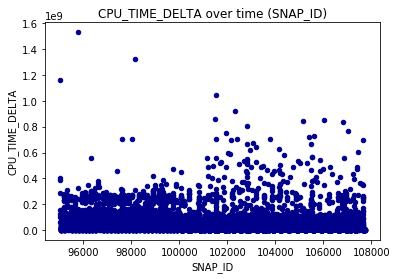

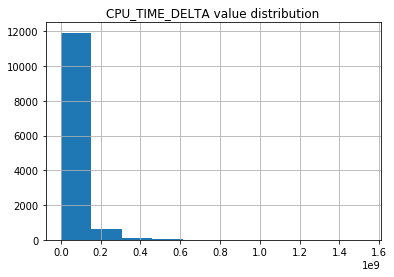

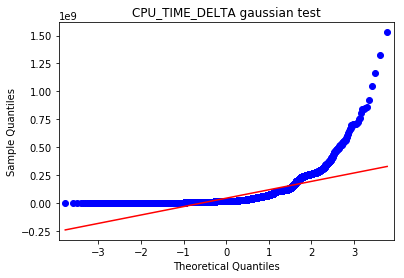

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistics=0.530, p=0.000
Sample does not look Gaussian (reject H0)


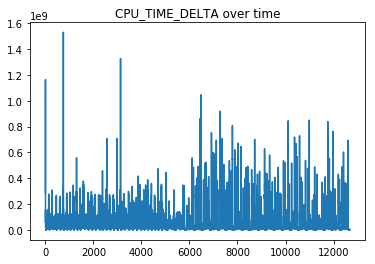

---------------------------------------------------------------


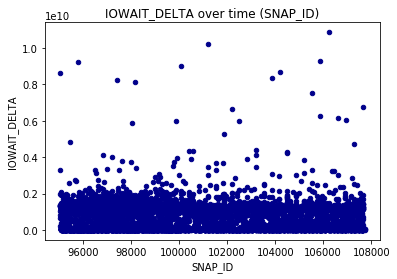

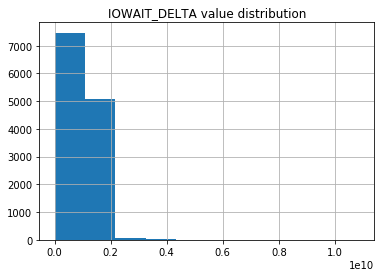

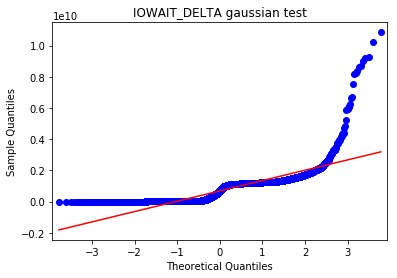

Statistics=0.760, p=0.000
Sample does not look Gaussian (reject H0)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


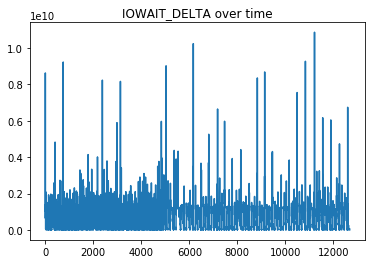

---------------------------------------------------------------


In [10]:
def shapiro_wilk(data):
    # normality test
    stat, p = sc.stats.shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

for label in y_label:
    
    df.plot.scatter(x='SNAP_ID',
                    y=label,
                    c='DarkBlue')
    plt.title(label + " over time (SNAP_ID)")
    plt.show()
    
    df[label].hist(bins=10)
    plt.title(label + ' value distribution')
    plt.show()
    
    qqplot(df[label], line='s')
    plt.title(label + ' gaussian test')
    plt.show()
    
    shapiro_wilk(data=df[label])
    
    df[label].plot.line()
    plt.title(label + ' over time')
    plt.show()
    print('---------------------------------------------------------------')

### Outlier Detection - Standard Deviation Method

Detection and transformation of outliers, categorized as more than 3 standard deviations away.

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

For example, within one standard deviation of the mean will cover 68% of the data.

So, if the mean is 50 and the standard deviation is 5, as in the test dataset above, then all data in the sample between 45 and 55 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows:

* 1 Standard Deviation from the Mean: 68%
* 2 Standard Deviations from the Mean: 95%
* 3 Standard Deviations from the Mean: 99.7%

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples.

Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

More infor here: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

### Outlier Detection - Interquartile Range Method

https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution.

A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short.

The IQR is calculated as the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot.

Remember that percentiles can be calculated by sorting the observations and selecting values at specific indices. The 50th percentile is the middle value, or the average of the two middle values for an even number of examples. If we had 10,000 samples, then the 50th percentile would be the average of the 5000th and 5001st values.

We refer to the percentiles as quartiles (“quart” meaning 4) because the data is divided into four groups via the 25th, 50th and 75th values.

The IQR defines the middle 50% of the data, or the body of the data.

The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots.

On a box and whisker plot, these limits are drawn as fences on the whiskers (or the lines) that are drawn from the box. Values that fall outside of these values are drawn as dots.

Outlier detected for column [CPU_TIME_DELTA] at location [0] with value [285533976]
Outlier detected for column [CPU_TIME_DELTA] at location [1] with value [402509154]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()



Outlier detected for column [CPU_TIME_DELTA] at location [2] with value [1163064072]
Outlier detected for column [CPU_TIME_DELTA] at location [3] with value [387856081]
Outlier detected for column [CPU_TIME_DELTA] at location [138] with value [278050958]
Outlier detected for column [CPU_TIME_DELTA] at location [270] with value [309265406]
Outlier detected for column [CPU_TIME_DELTA] at location [271] with value [270164765]
Outlier detected for column [CPU_TIME_DELTA] at location [281] with value [269807585]
Outlier detected for column [CPU_TIME_DELTA] at location [738] with value [327025257]
Outlier detected for column [CPU_TIME_DELTA] at location [747] with value [1529696755]
Outlier detected for column [CPU_TIME_DELTA] at location [895] with value [271719149]
Outlier detected for column [CPU_TIME_DELTA] at location [896] with value [284676432]
Outlier detected for column [CPU_TIME_DELTA] at location [1030] with value [275971466]
Outlier detected for column [CPU_TIME_DELTA] at locati

Outlier detected for column [CPU_TIME_DELTA] at location [6316] with value [403900021]
Outlier detected for column [CPU_TIME_DELTA] at location [6319] with value [278616347]
Outlier detected for column [CPU_TIME_DELTA] at location [6364] with value [491850340]
Outlier detected for column [CPU_TIME_DELTA] at location [6433] with value [860087650]
Outlier detected for column [CPU_TIME_DELTA] at location [6484] with value [317950272]
Outlier detected for column [CPU_TIME_DELTA] at location [6485] with value [1045900358]
Outlier detected for column [CPU_TIME_DELTA] at location [6486] with value [703653023]
Outlier detected for column [CPU_TIME_DELTA] at location [6488] with value [557021599]
Outlier detected for column [CPU_TIME_DELTA] at location [6492] with value [289686112]
Outlier detected for column [CPU_TIME_DELTA] at location [6493] with value [282381282]
Outlier detected for column [CPU_TIME_DELTA] at location [6586] with value [387700955]
Outlier detected for column [CPU_TIME_DELT

Outlier detected for column [CPU_TIME_DELTA] at location [10444] with value [461804625]
Outlier detected for column [CPU_TIME_DELTA] at location [10445] with value [666822181]
Outlier detected for column [CPU_TIME_DELTA] at location [10446] with value [339008910]
Outlier detected for column [CPU_TIME_DELTA] at location [10485] with value [376673168]
Outlier detected for column [CPU_TIME_DELTA] at location [10486] with value [274342171]
Outlier detected for column [CPU_TIME_DELTA] at location [10489] with value [566898944]
Outlier detected for column [CPU_TIME_DELTA] at location [10490] with value [291548143]
Outlier detected for column [CPU_TIME_DELTA] at location [10491] with value [566292523]
Outlier detected for column [CPU_TIME_DELTA] at location [10492] with value [275811551]
Outlier detected for column [CPU_TIME_DELTA] at location [10584] with value [729526137]
Outlier detected for column [CPU_TIME_DELTA] at location [10585] with value [386204420]
Outlier detected for column [CPU

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Outlier detected for column [IOWAIT_DELTA] at location [1] with value [3318661592]
Outlier detected for column [IOWAIT_DELTA] at location [2] with value [8621531022]
Outlier detected for column [IOWAIT_DELTA] at location [408] with value [4823320869]
Outlier detected for column [IOWAIT_DELTA] at location [747] with value [9221431666]
Outlier detected for column [IOWAIT_DELTA] at location [1444] with value [3292241621]
Outlier detected for column [IOWAIT_DELTA] at location [1477] with value [3107405505]
Outlier detected for column [IOWAIT_DELTA] at location [1783] with value [4137258354]
Outlier detected for column [IOWAIT_DELTA] at location [1933] with value [3333879155]
Outlier detected for column [IOWAIT_DELTA] at location [2174] with value [4008712288]
Outlier detected for column [IOWAIT_DELTA] at location [2377] with value [8227114392]
Outlier detected for column [IOWAIT_DELTA] at location [2457] with value [3321410966]
Outlier detected for column [IOWAIT_DELTA] at location [2570]

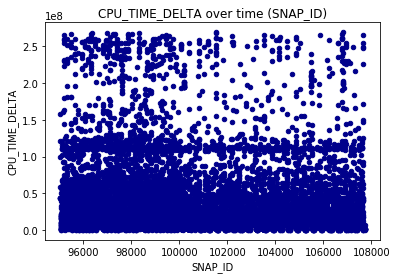

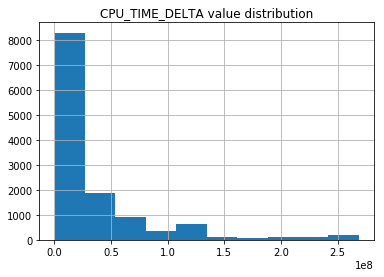

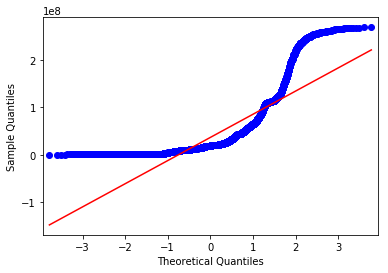

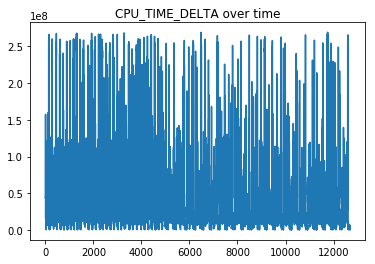

---------------------------------------------------------------


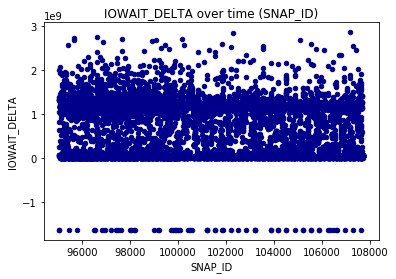

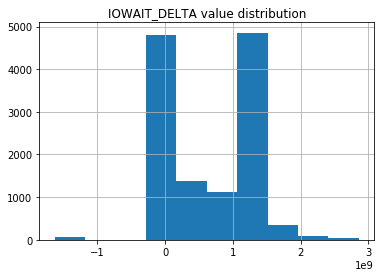

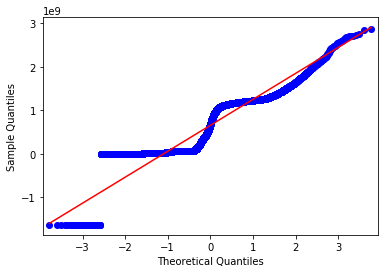

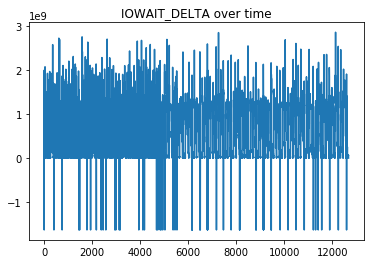

---------------------------------------------------------------


In [11]:
def detect_and_transform_outliers_zscore(df, threshold=3):
    """
    Iterates over input dataframe and transforms outliers (greater then 3 std threshold) into mean value
    
    :param: (Pandas 2D Matrix) Input dataframe
    :param: (Integer) Input standard deviation threshold - 3 equates to the .99% threshold
    """
    for col in df.columns:
        mean = np.mean(df[col])
        std = np.std(df[col])
        
        counter = 0
        for val in df[col]:
            z_score = (val - mean) / std
            if np.abs(z_score) > threshold:
                df[col].iloc[counter] = mean
                print('Outlier detected for column [' + col + '] at location [' + str(counter) + '] with value [' + str(val) + ']')
            counter += 1
                
    return df

def detect_and_transform_outliers_iqr(df):
    """
    Iterates over input dataframe and transforms outliers (greater then 3 std threshold) into mean value
    
    :param: (Pandas 2D Matrix) Input dataframe
    :param: (Integer) Input standard deviation threshold - 3 equates to the .99% threshold
    """
    for col in df.columns:
        quartile_1, quartile_3 = np.percentile(df.values, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        
        counter = 0
        for val in df[col]:
            if (val > upper_bound) or (val < lower_bound):
                df[col].iloc[counter] = lower_bound
                print('Outlier detected for column [' + col + '] at location [' + str(counter) + '] with value [' + str(val) + ']')
            counter += 1
                
    return df

df[[y_label[0]]] = detect_and_transform_outliers_zscore(df=df[[y_label[0]]])
df[[y_label[1]]] = detect_and_transform_outliers_iqr(df=df[[y_label[1]]])

for label in y_label:
    
    df.plot.scatter(x='SNAP_ID',
                    y=label,
                    c='DarkBlue')
    plt.title(label + " over time (SNAP_ID)")
    plt.show()
    
    df[label].hist(bins=10)
    plt.title(label + ' value distribution')
    plt.show()
    
    qqplot(df[label], line='s')
    plt.show()
    
    df[label].plot.line()
    plt.title(label + ' over time')
    plt.show()
    print('---------------------------------------------------------------')

### Normalization

Relavent Sources:

* http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf
* https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

In [12]:
# MINMAX SCALER
#df = Normalizer.minmax_scaler(dataframe=df)
train, test = train_test_split(df, test_size=0.5)
trainheaders = train.columns
testheaders = test.columns
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
train = pd.DataFrame(train, columns=trainheaders)
test = pd.DataFrame(test, columns=testheaders)
df = train.append(test, ignore_index=True)
# NORMALIZER
#df = Normalizer.normalize(dataframe=df)

print('\n\n------------------AFTER------------------')
print('------------------df------------------')
print(df.shape)
print('\n\n')
print('\n\ndf')
print(df.head())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)




------------------AFTER------------------
------------------df------------------
(12678, 516)





df
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FORCE_MATCHING_SIGNATURE  \
0  0.903211    4.061139e-09      0.603403                  0.673163   
1  0.065315    6.761723e-08      0.125509                  0.489568   
2  0.461308    1.730894e-09      0.288415                  0.629406   
3  0.514396    1.665506e-09      0.350775                  0.331684   
4  0.842865    1.711104e-07      0.628716                  0.570639   

   FETCHES_TOTAL  FETCHES_DELTA  END_OF_FETCH_COUNT_TOTAL  \
0       0.151994       0.002614                  0.088756   
1       0.268272       0.004921                  0.285760   
2       0.256057       0.000840                  0.103569   
3       0.355246       0.006228                  0.233407   
4       0.760057       0.006069                  0.753439   

   END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  SORTS_DELTA  \
0                  0.009448     0.118476     

### Split Train Test

Splits dataset into training and validation subsets

In [13]:
y_df = df[y_label]
X_df = df
print("Label " + str(y_label) + " shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(X_df.shape))
print(X_df.head())

Label ['CPU_TIME_DELTA', 'IOWAIT_DELTA'] shape: (12678, 2)
Feature matrix shape: (12678, 516)
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FORCE_MATCHING_SIGNATURE  \
0  0.903211    4.061139e-09      0.603403                  0.673163   
1  0.065315    6.761723e-08      0.125509                  0.489568   
2  0.461308    1.730894e-09      0.288415                  0.629406   
3  0.514396    1.665506e-09      0.350775                  0.331684   
4  0.842865    1.711104e-07      0.628716                  0.570639   

   FETCHES_TOTAL  FETCHES_DELTA  END_OF_FETCH_COUNT_TOTAL  \
0       0.151994       0.002614                  0.088756   
1       0.268272       0.004921                  0.285760   
2       0.256057       0.000840                  0.103569   
3       0.355246       0.006228                  0.233407   
4       0.760057       0.006069                  0.753439   

   END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  SORTS_DELTA  \
0                  0.009448     0.118476     0.002867  

### Lag and Autocorrelation Analysis

This section checks for potential autocorrelation within the presented time series. Three seperate plots are layed out as follows:

* Plot 1 - Lag plot denoting correlation between time lag 0 and time lag 1.
* Plot 2 - Auto correlation plot denoting time series correlation over a number of lag values
* Plot 3 - Auto correlation plot denoting time series correlation up till lag value 100. This achieves a much more closer look towards the first 100 lag correlations for the time series, achieving a more detailed plot.
Relavent sources:

* http://pandasplotting.blogspot.com/2012/06/autocorrelation-plot.html
* https://pandas.pydata.org/pandas-docs/stable/visualization.html
* https://machinelearningmastery.com/time-series-data-visualization-with-python/

Label - [CPU_TIME_DELTA]


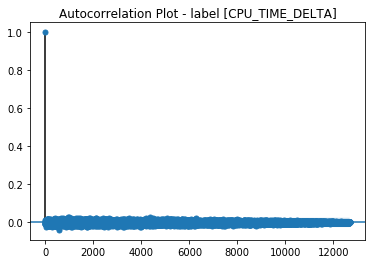

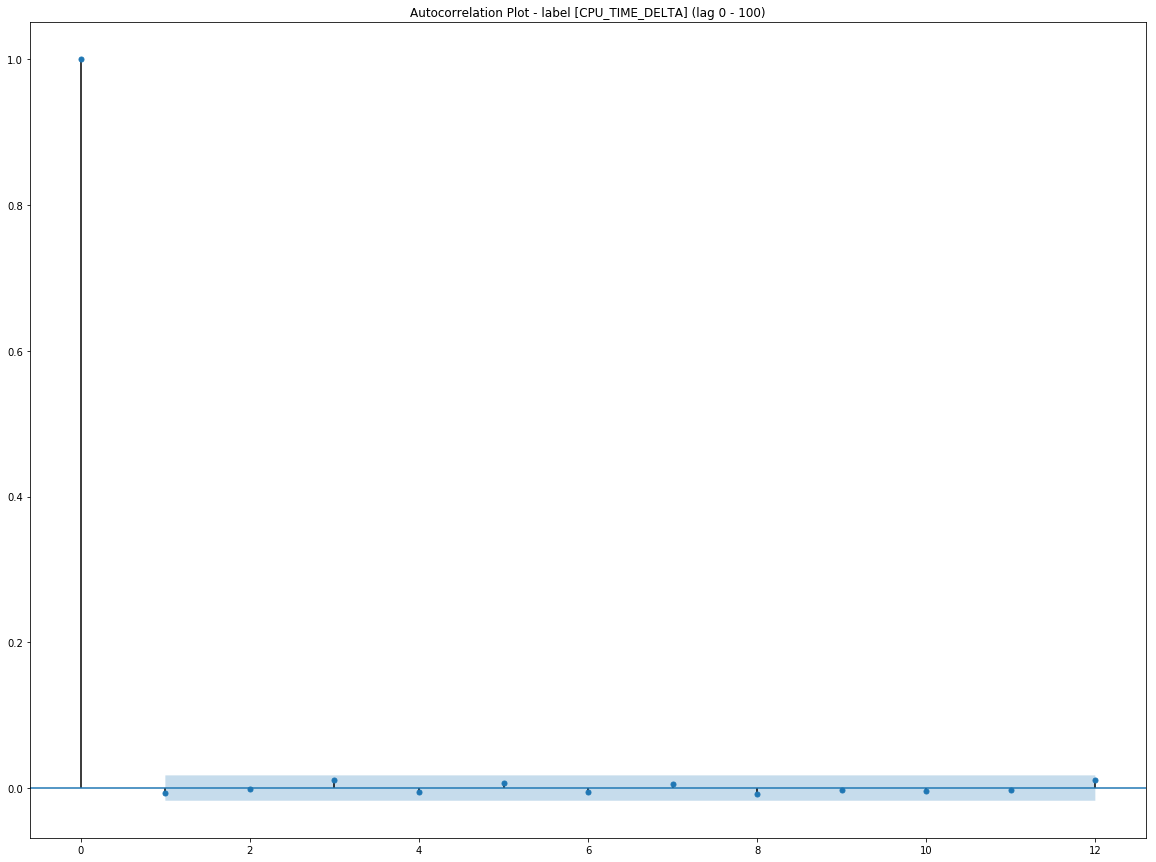

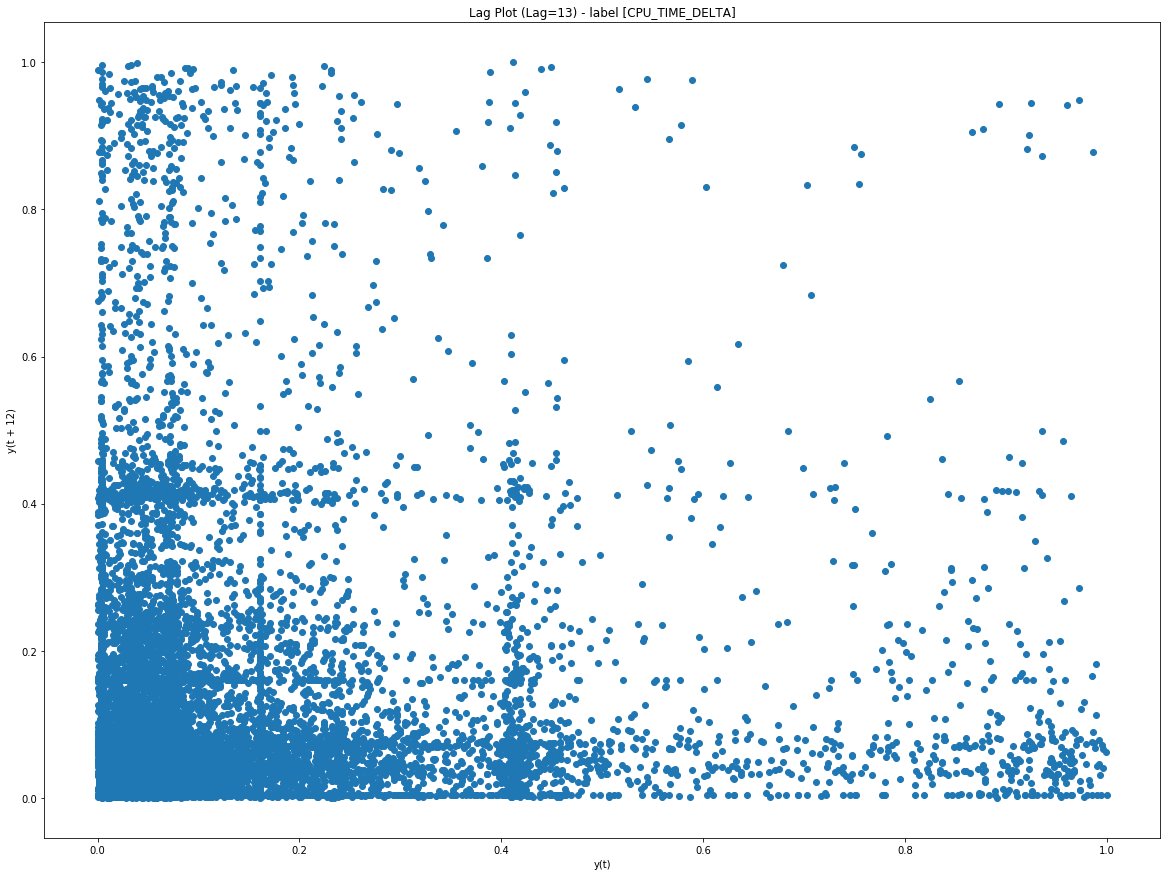

Label - [IOWAIT_DELTA]


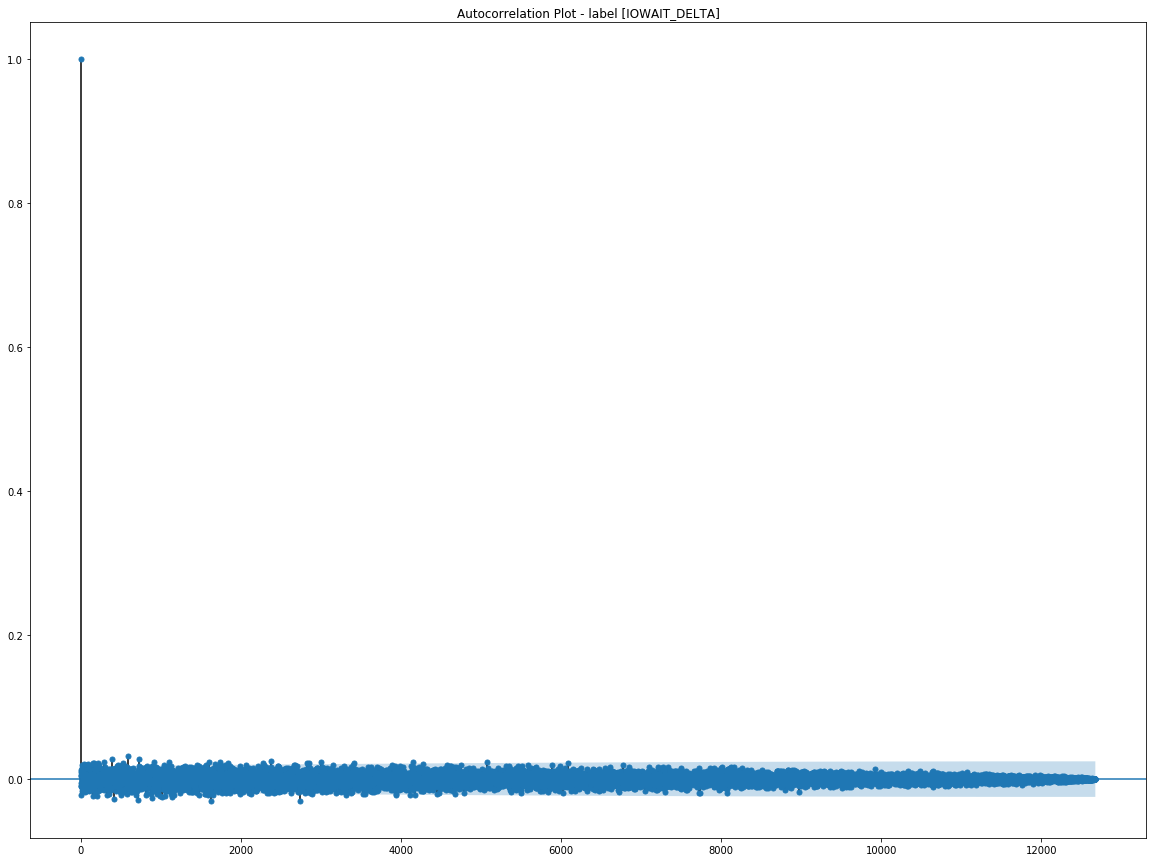

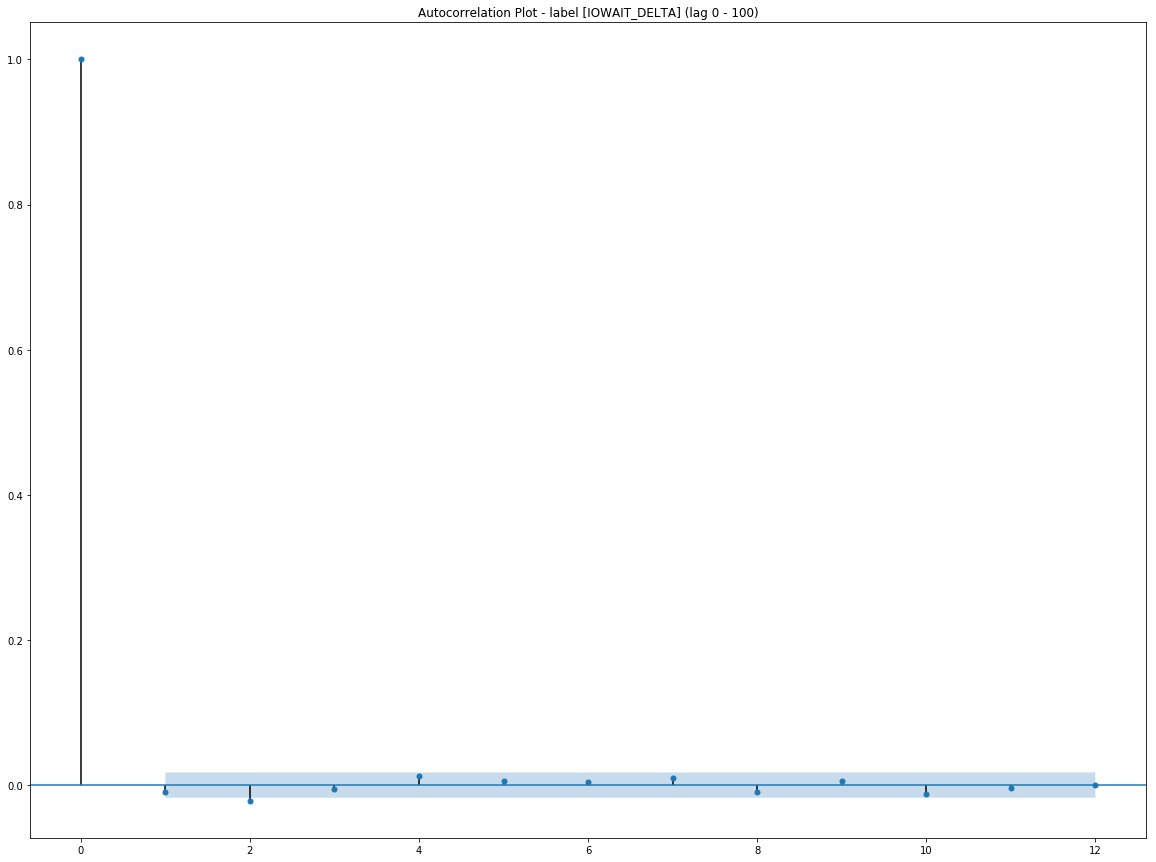

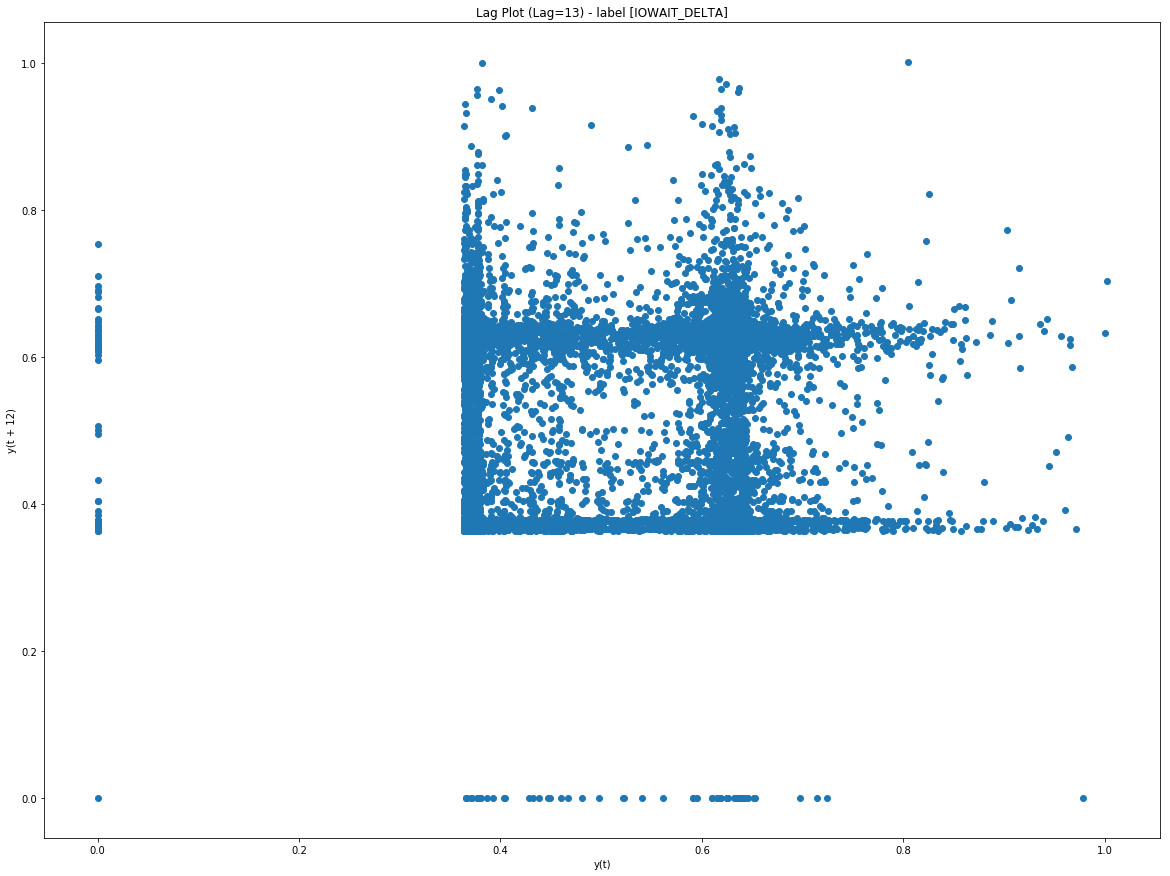

In [14]:
def qualify_lag(data, labels, lag):
    for label in labels:
        print('Label - [' + label + ']')
        plot_acf(data[label])
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.title('Autocorrelation Plot - label [' + label + ']')
        plt.show()
        plot_acf(data[label], lags=lag)
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.title('Autocorrelation Plot - label [' + label + '] (lag 0 - 100)')
        plt.show()
        lag_plot(data[label], lag=lag)
        plt.rcParams['figure.figsize'] = [20, 15]
        plt.title('Lag Plot (Lag=13) - label [' + label + ']')
        plt.show()

qualify_lag(data=df,
            labels=y_label,
            lag=lag)

### Discrete Training

This section converts the established features from the continuous domain into the discrete domain. Continous values will be converted into discrete, and used to train the model using such values (Utilizes bucket function).

https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/

In [15]:
class BinClass:
    """
    Takes data column, and scales them into discrete buckets. Parameter 'n' denotes number of buckets. This class needs
    to be defined before the LSTM class, since it is referenced during the prediction stage. Since Keras models output a
    continuous output (even when trained on discrete data), the 'BinClass' is required by the LSTM class.
    """
    
    @staticmethod
    def __bucket_val(val, avg):
        """
        Receives threshold value and buckets the val according to the passed threshold
        """
        return np.where(val > avg, 1, 0)

    @staticmethod
    def discretize_value(X, threshold):
        """
        param: X - Input data
        """
        try:
            myfunc_vec = np.vectorize(lambda x: BinClass.__bucket_val(x, threshold))
            return myfunc_vec(X)
        except:
            return BinClass.__bucket_val(X, threshold)

cpu_avg = y_df[y_label[0]].mean()
y_df_cpu = pd.DataFrame(BinClass.discretize_value(y_df[[y_label[0]]].values, cpu_avg), columns=[y_label[0]])
print('CPU y:')
print(np.unique(y_df_cpu.values))
print('Number of 0s: ' + str(np.count_nonzero(y_df_cpu == 0)))
print('Number of 1s: ' + str(np.count_nonzero(y_df_cpu == 1)))
#
io_avg = y_df[y_label[1]].mean()
y_df_io = pd.DataFrame(BinClass.discretize_value(y_df[[y_label[1]]].values, io_avg), columns=[y_label[1]])
print('I/O y:')
print(np.unique(y_df_io.values))
print('Number of 0s: ' + str(np.count_nonzero(y_df_io == 0)))
print('Number of 1s: ' + str(np.count_nonzero(y_df_io == 1)))

CPU y:
[0 1]
Number of 0s: 9006
Number of 1s: 3672
I/O y:
[0 1]
Number of 0s: 6312
Number of 1s: 6366


### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Frame as supervised learning set
X_df = series_to_supervised(X_df, lag, 0)
y_df = series_to_supervised(y_df, 0, lag)

print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nLabels')
print(y_df.columns)
print(y_df.shape)


-------------
Features
Index(['var1(t-12)', 'var2(t-12)', 'var3(t-12)', 'var4(t-12)', 'var5(t-12)',
       'var6(t-12)', 'var7(t-12)', 'var8(t-12)', 'var9(t-12)', 'var10(t-12)',
       ...
       'var507(t)', 'var508(t)', 'var509(t)', 'var510(t)', 'var511(t)',
       'var512(t)', 'var513(t)', 'var514(t)', 'var515(t)', 'var516(t)'],
      dtype='object', length=6708)
(12666, 6708)

-------------
Labels
Index(['var1(t)', 'var2(t)', 'var1(t+1)', 'var2(t+1)', 'var1(t+2)',
       'var2(t+2)', 'var1(t+3)', 'var2(t+3)', 'var1(t+4)', 'var2(t+4)',
       'var1(t+5)', 'var2(t+5)', 'var1(t+6)', 'var2(t+6)', 'var1(t+7)',
       'var2(t+7)', 'var1(t+8)', 'var2(t+8)', 'var1(t+9)', 'var2(t+9)',
       'var1(t+10)', 'var2(t+10)', 'var1(t+11)', 'var2(t+11)', 'var1(t+12)',
       'var2(t+12)'],
      dtype='object')
(12666, 26)


### Test Split Train / Validation / Test

Split main feature/label matrix/vector into 2 subsets. 
* First subset will be used for training the model
* The other subset is split into two further subsets:
    - Model Validation
    - Model Testing
    
The training test itself is further reshaped, so as to satisfy the format required by LSTMS

X_train shape [(6333, 6708)] Type - <class 'numpy.ndarray'>
y_train shape [(6333, 26)] Type - <class 'numpy.ndarray'>
X_validate shape [(3166, 6708)] Type - <class 'numpy.ndarray'>
y_validate shape [(3166, 26)] Type - <class 'numpy.ndarray'>
X_test shape [(3167, 6708)] Type - <class 'numpy.ndarray'>
y_test shape [(3167, 26)] Type - <class 'numpy.ndarray'>


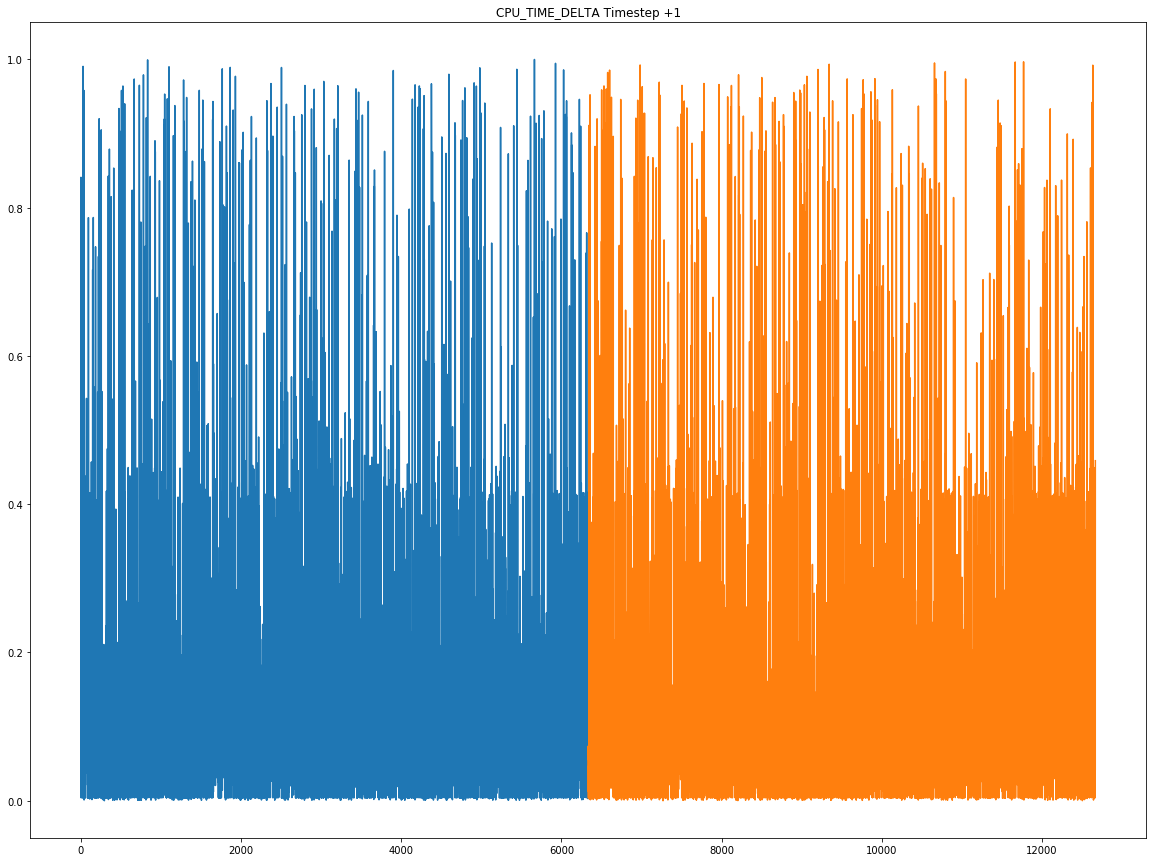

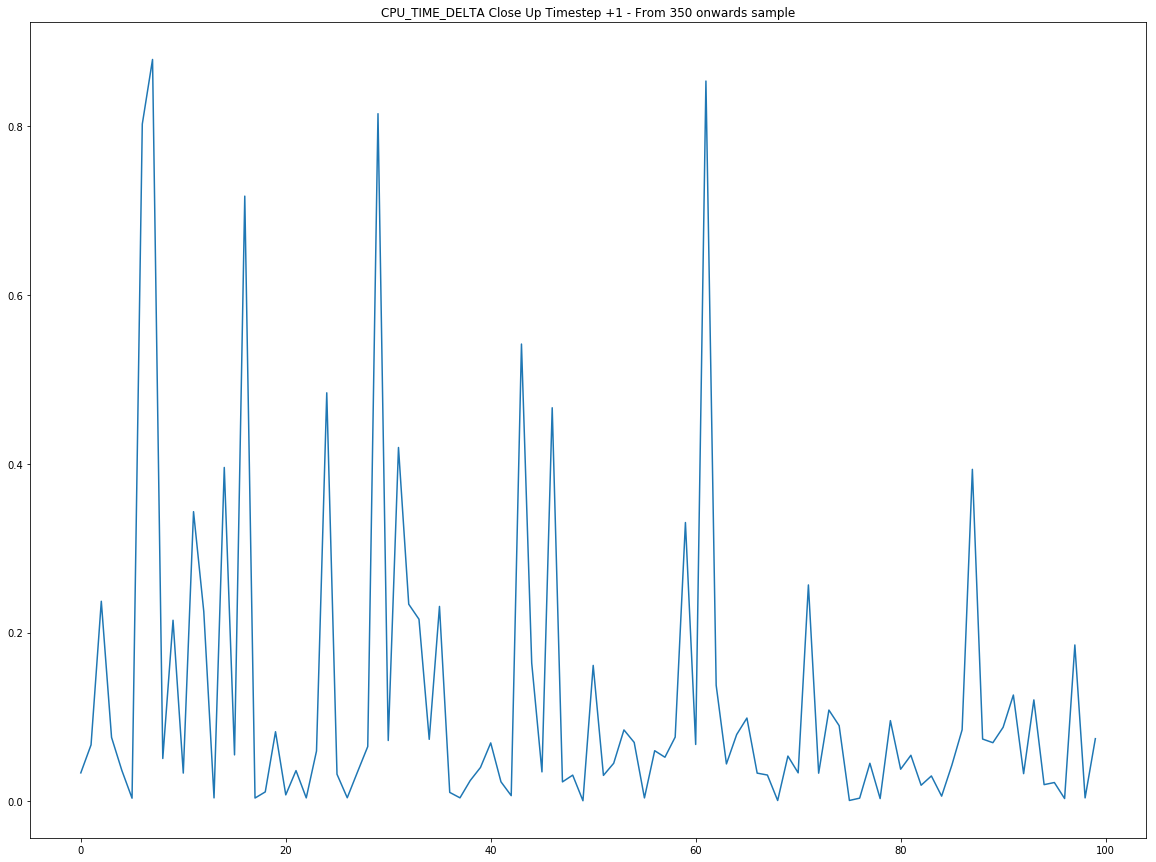

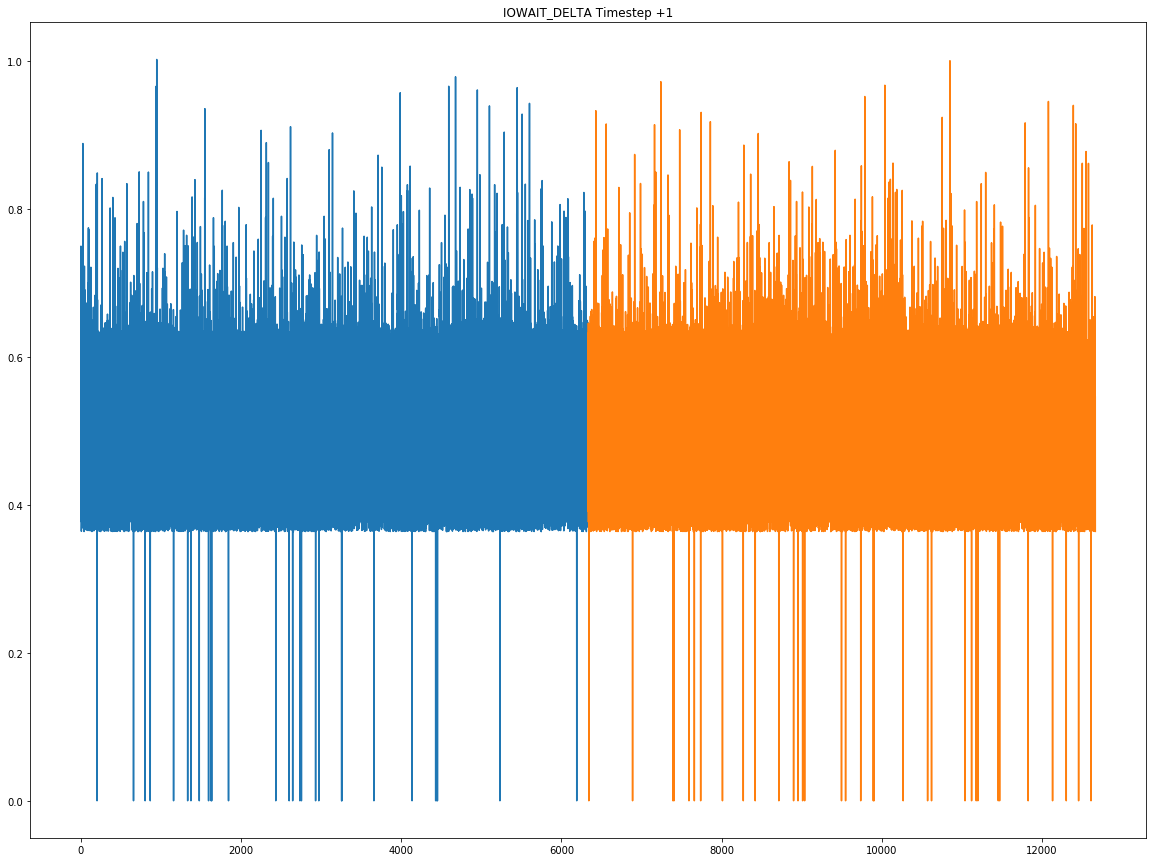

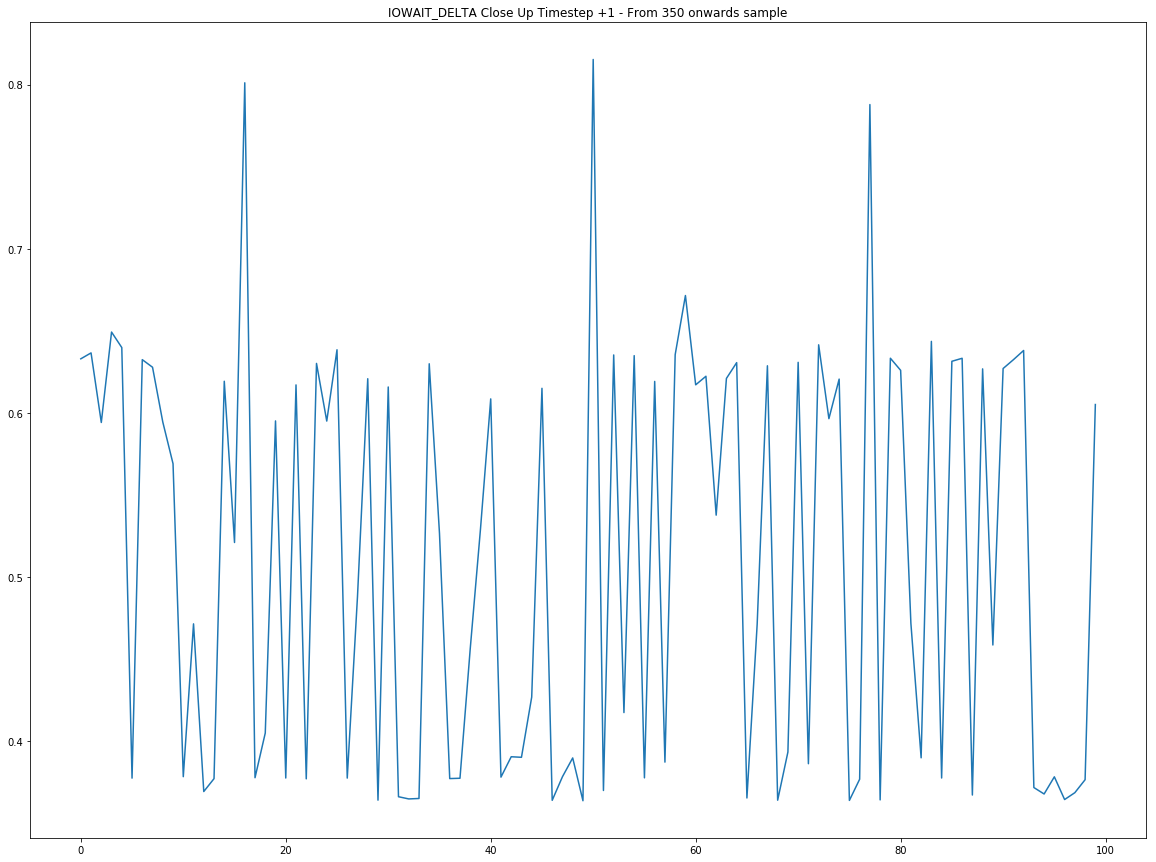

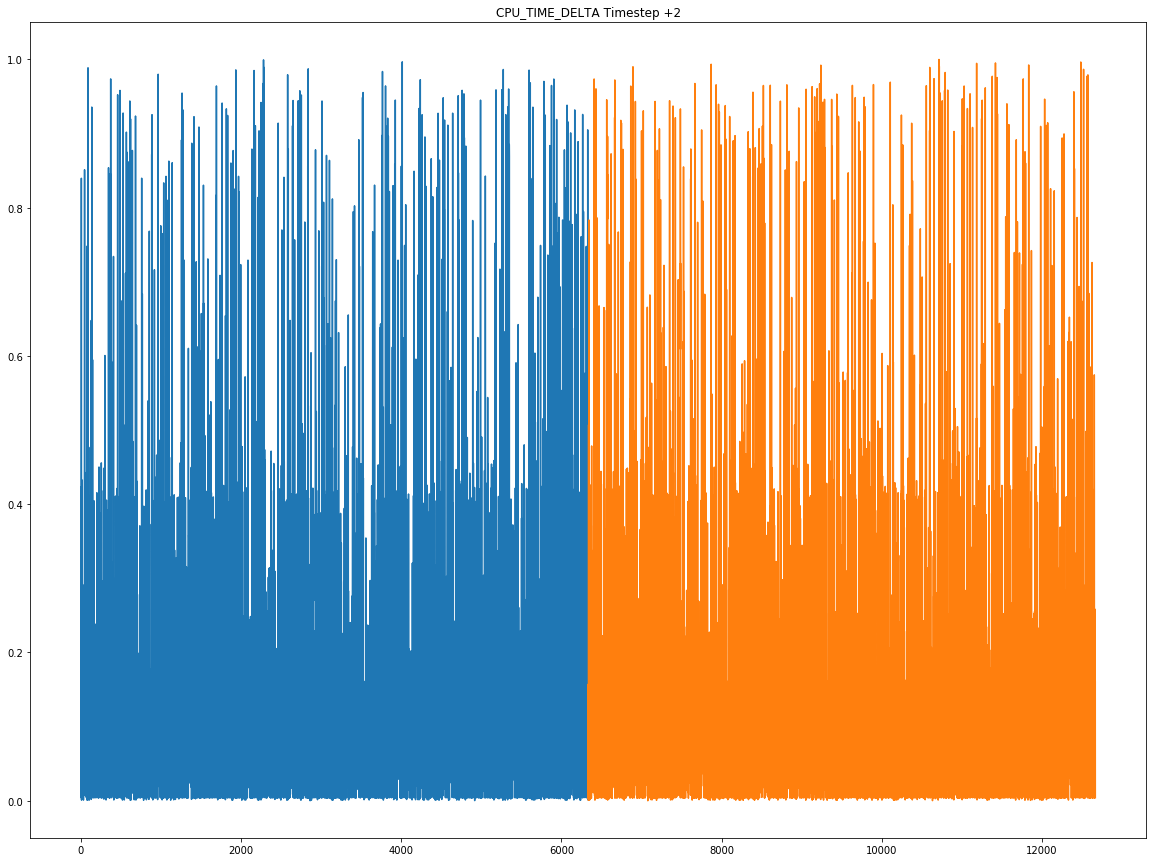

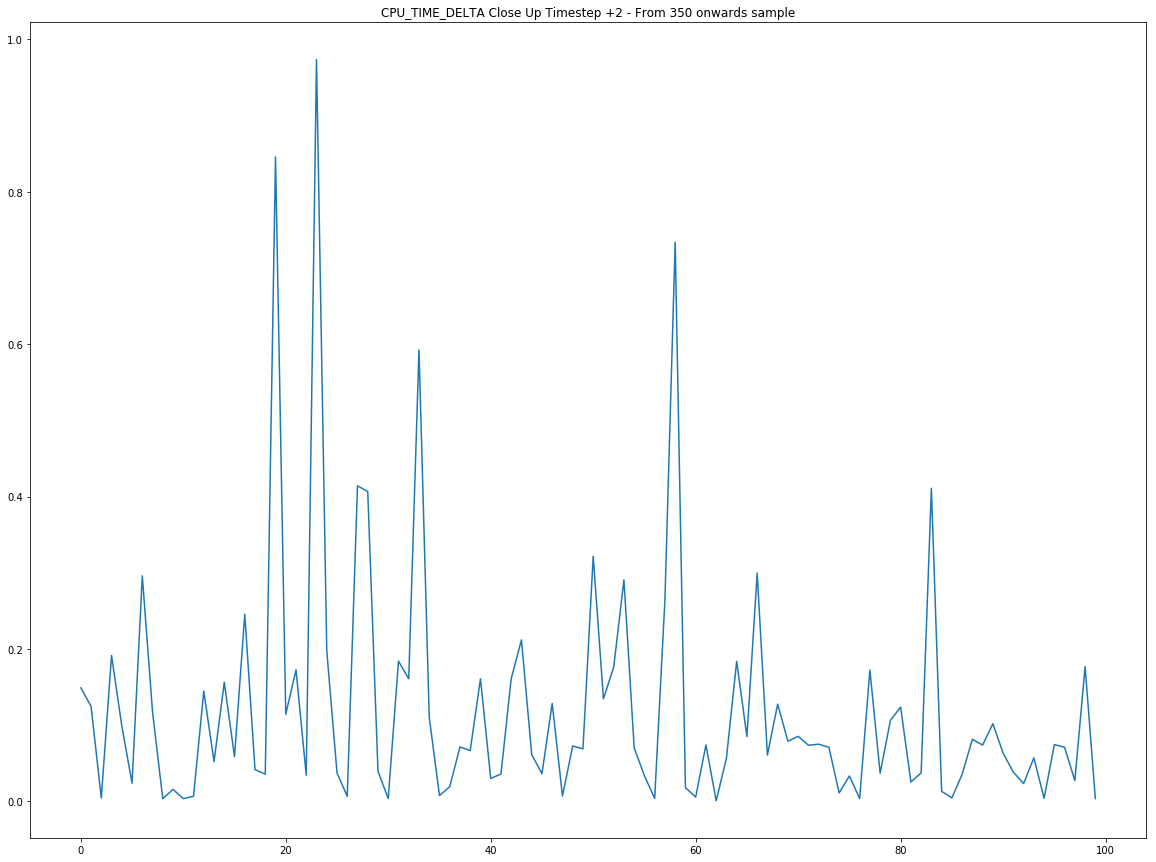

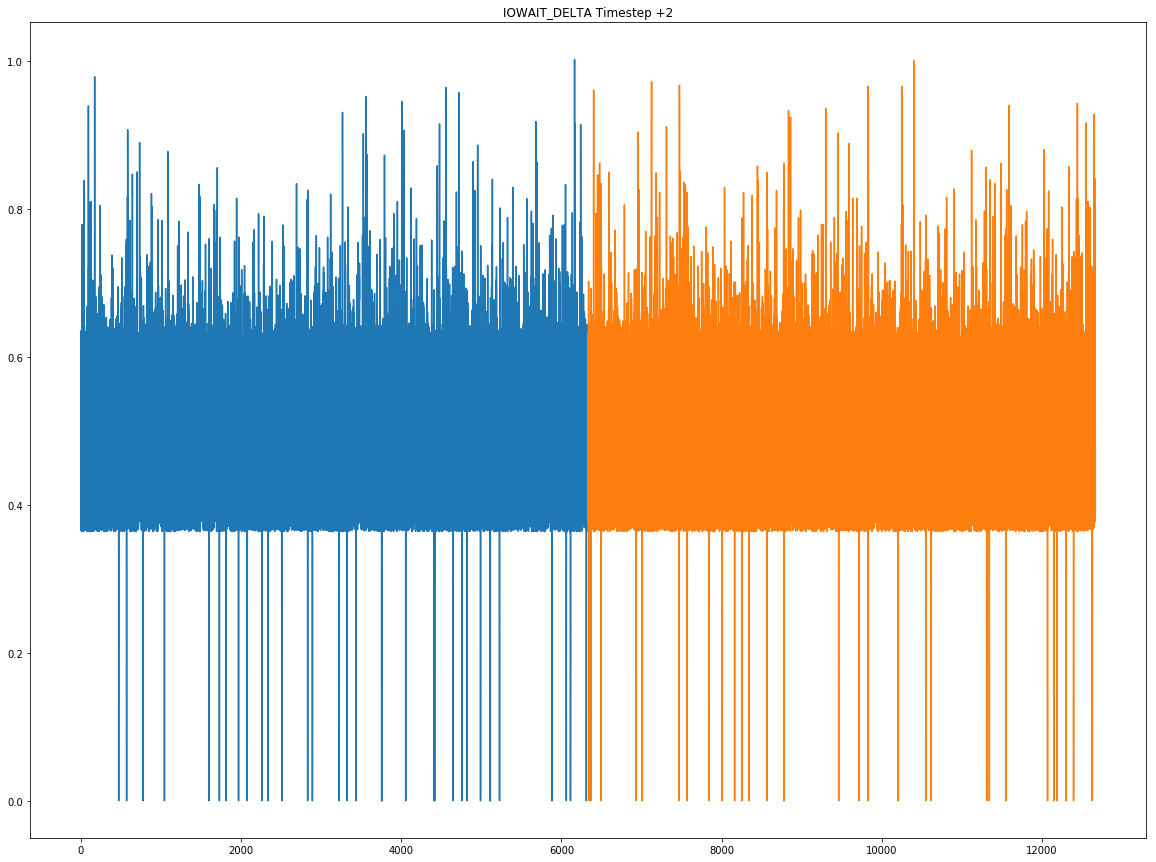

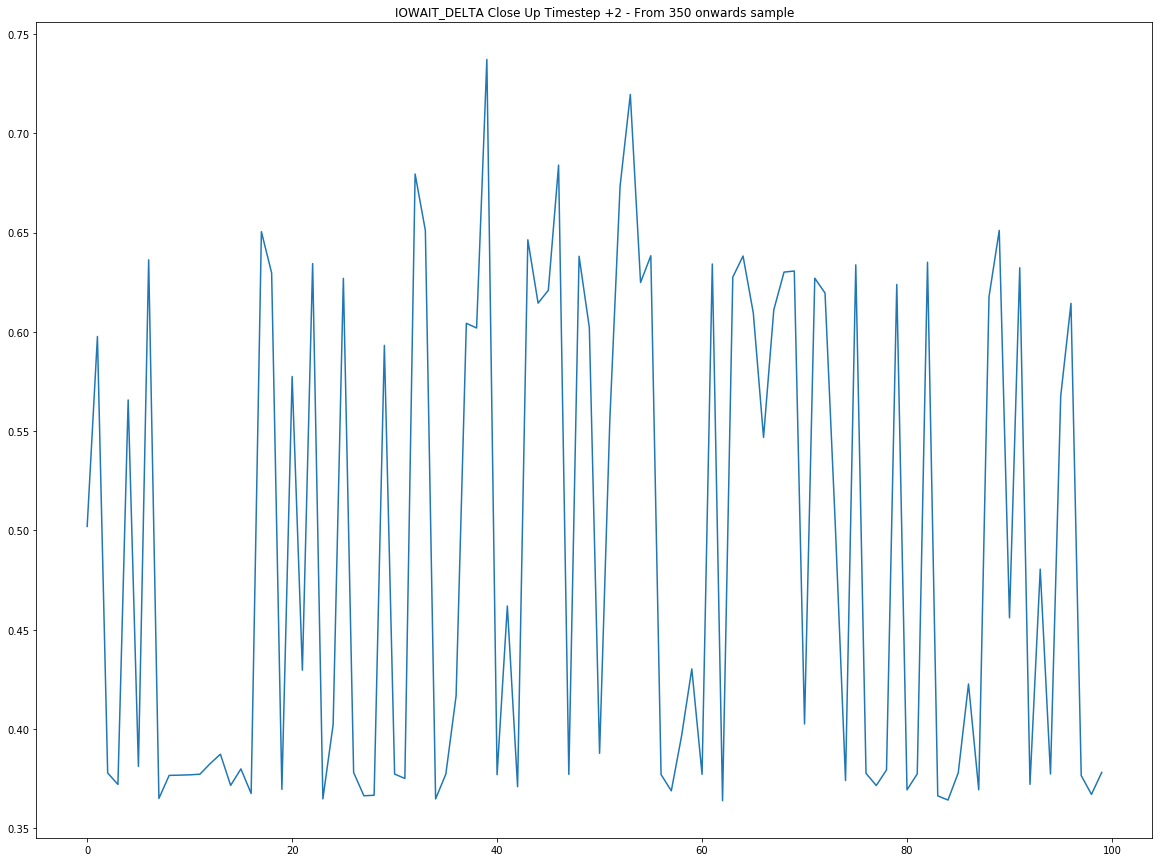

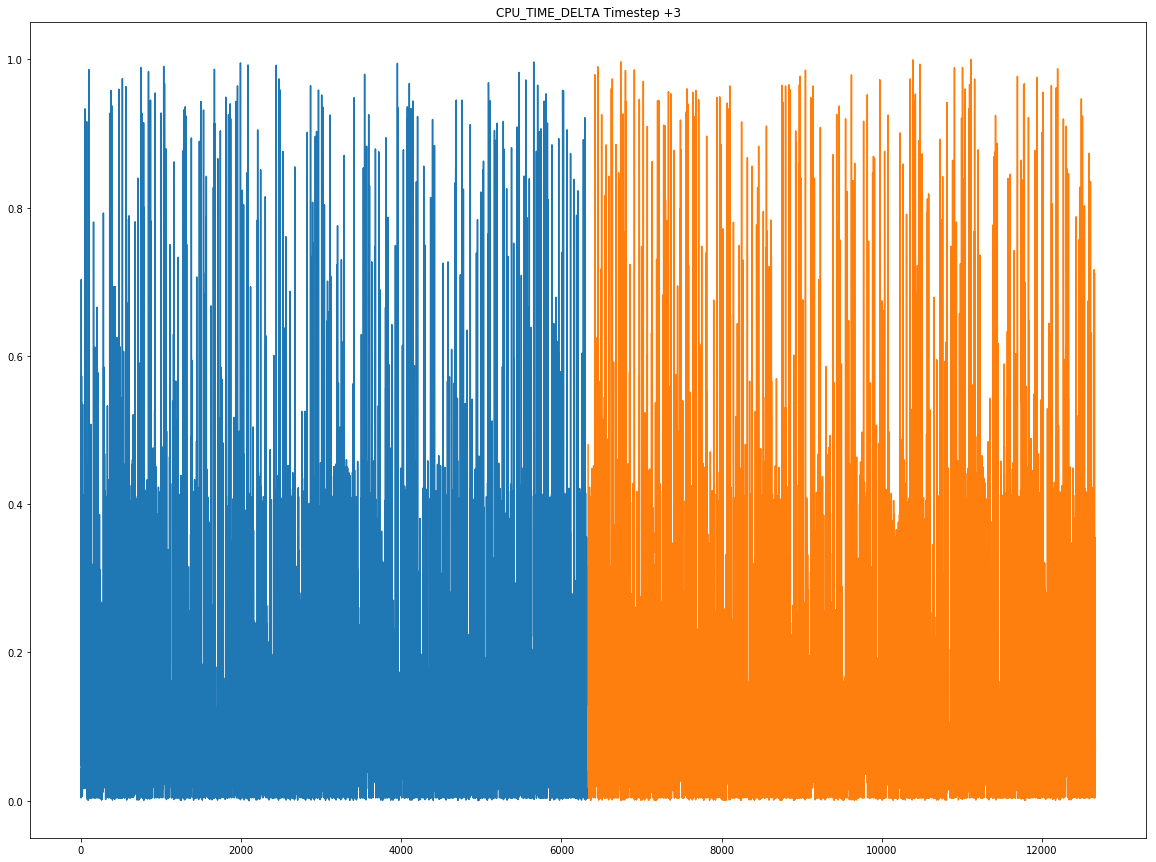

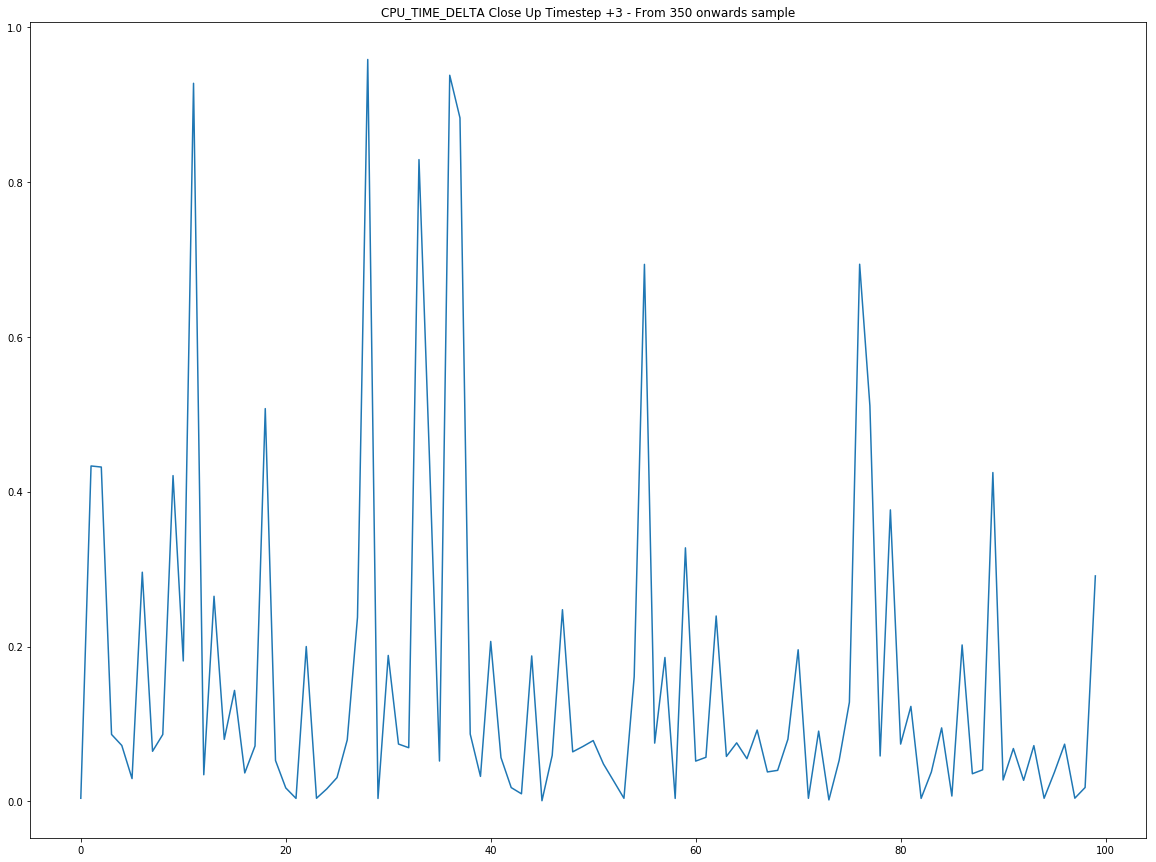

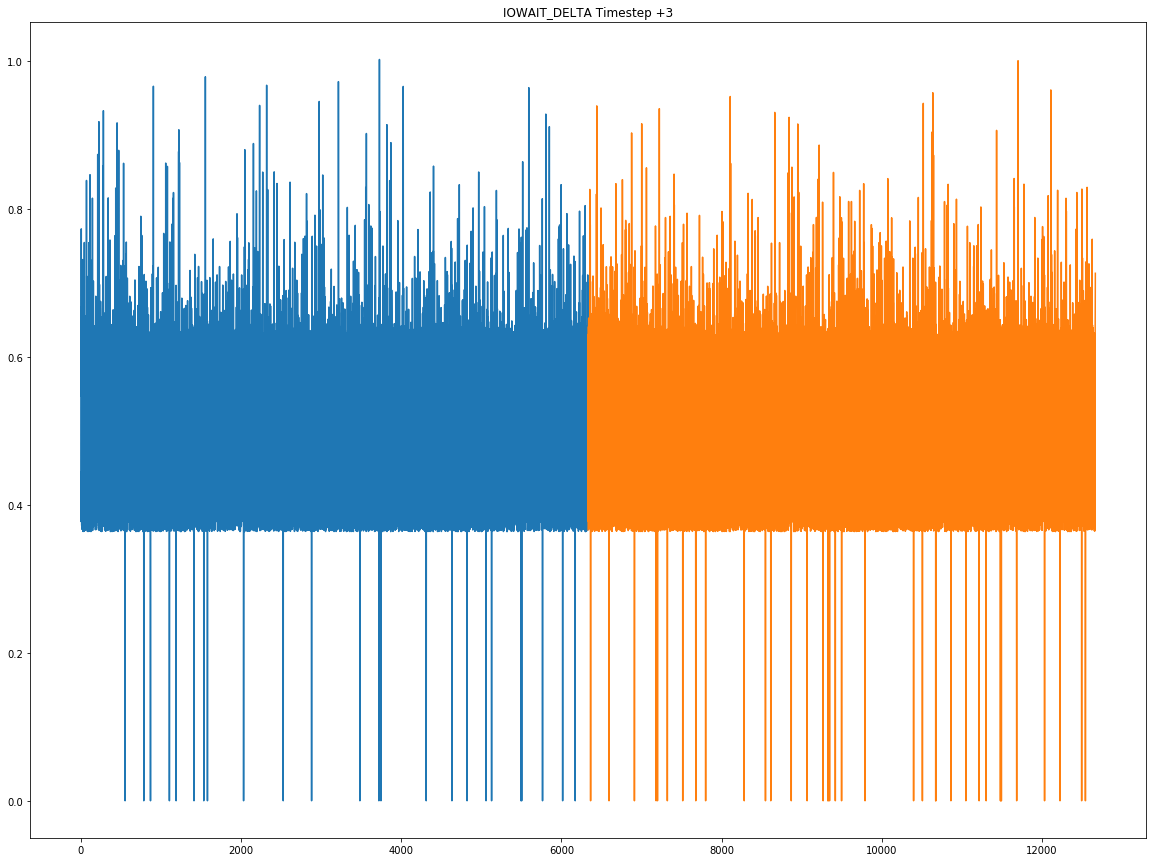

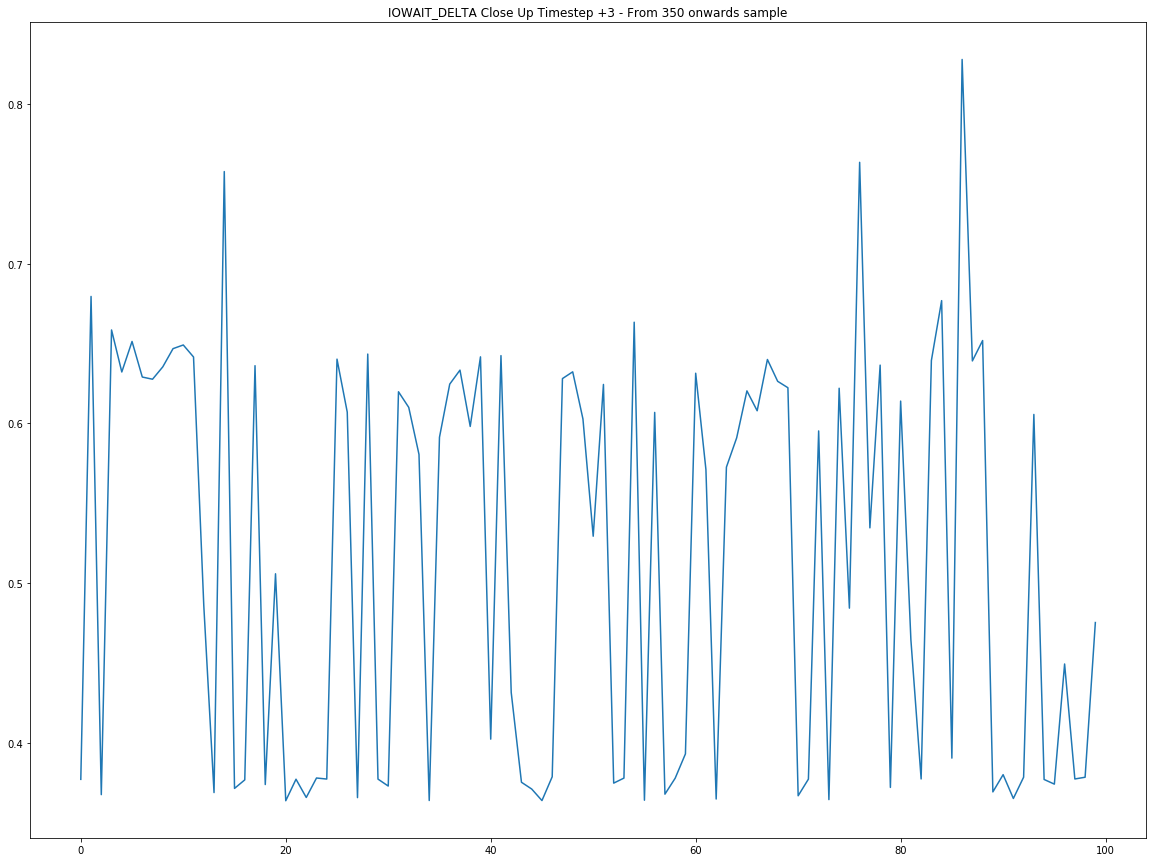

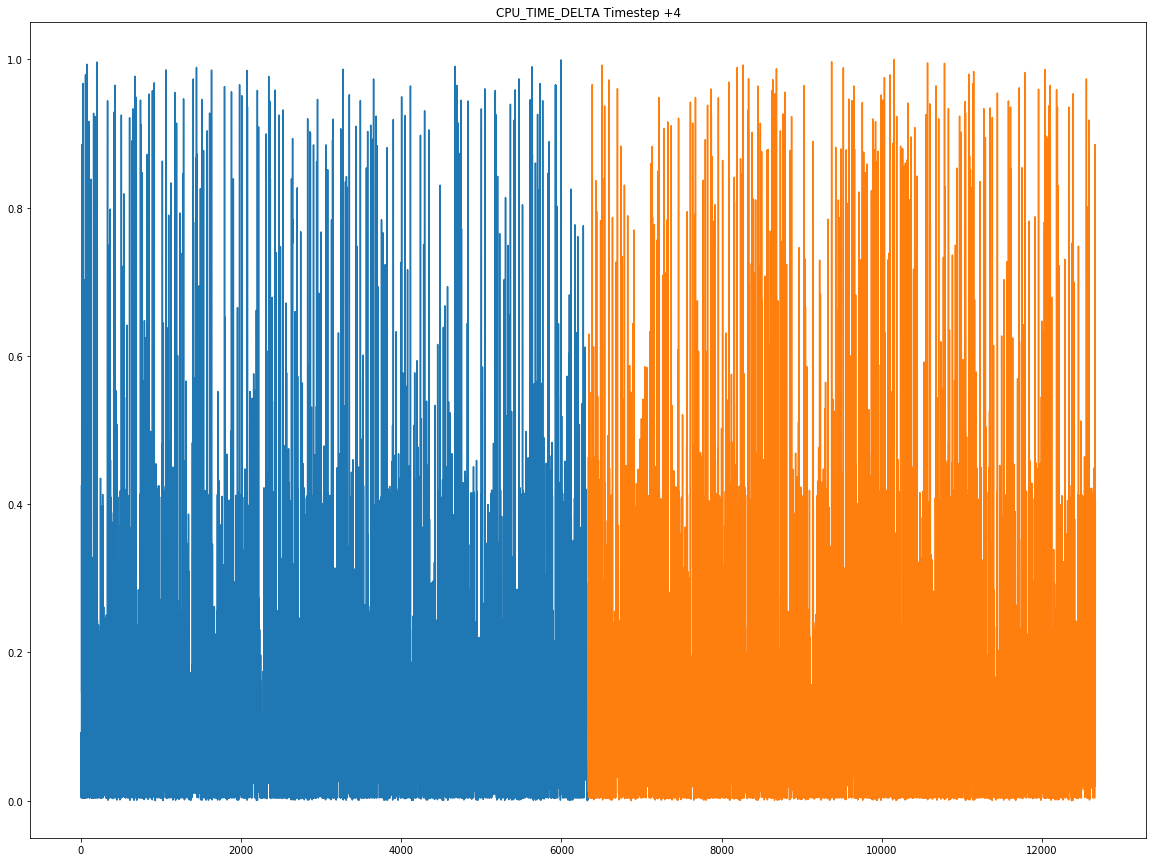

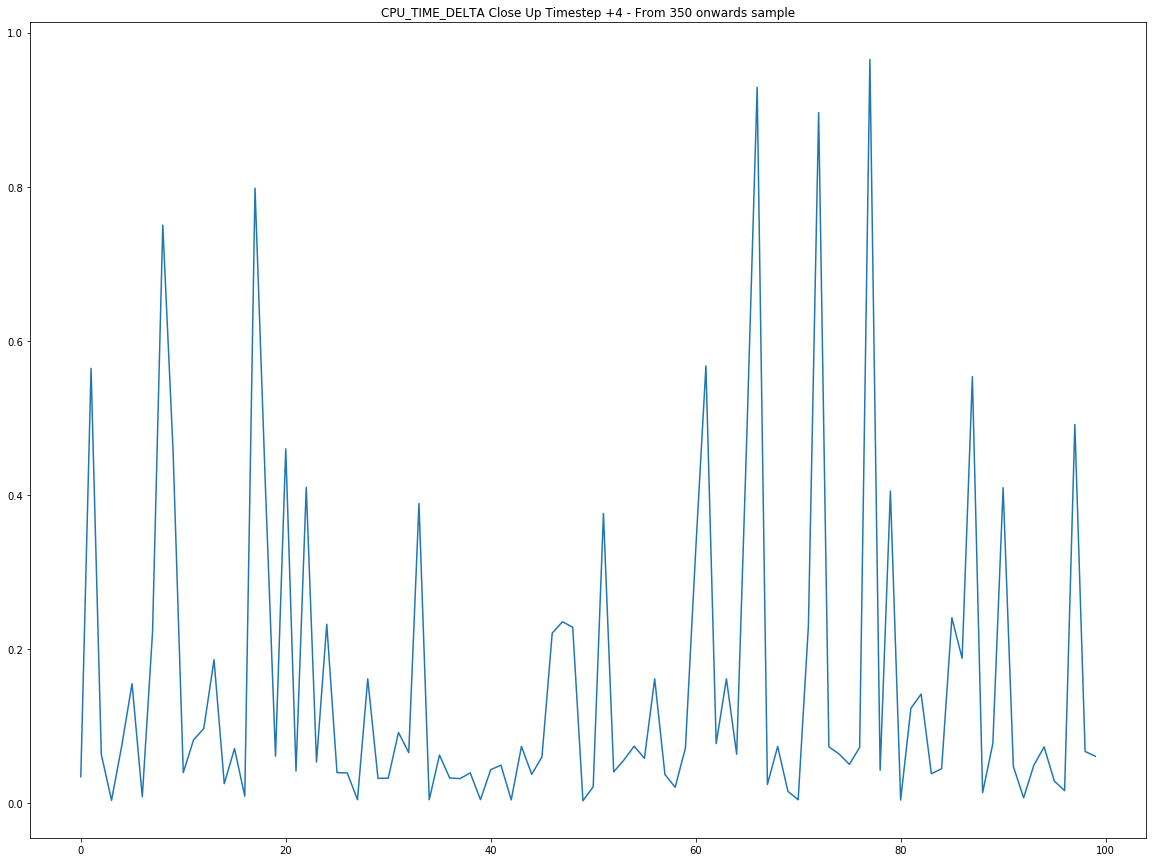

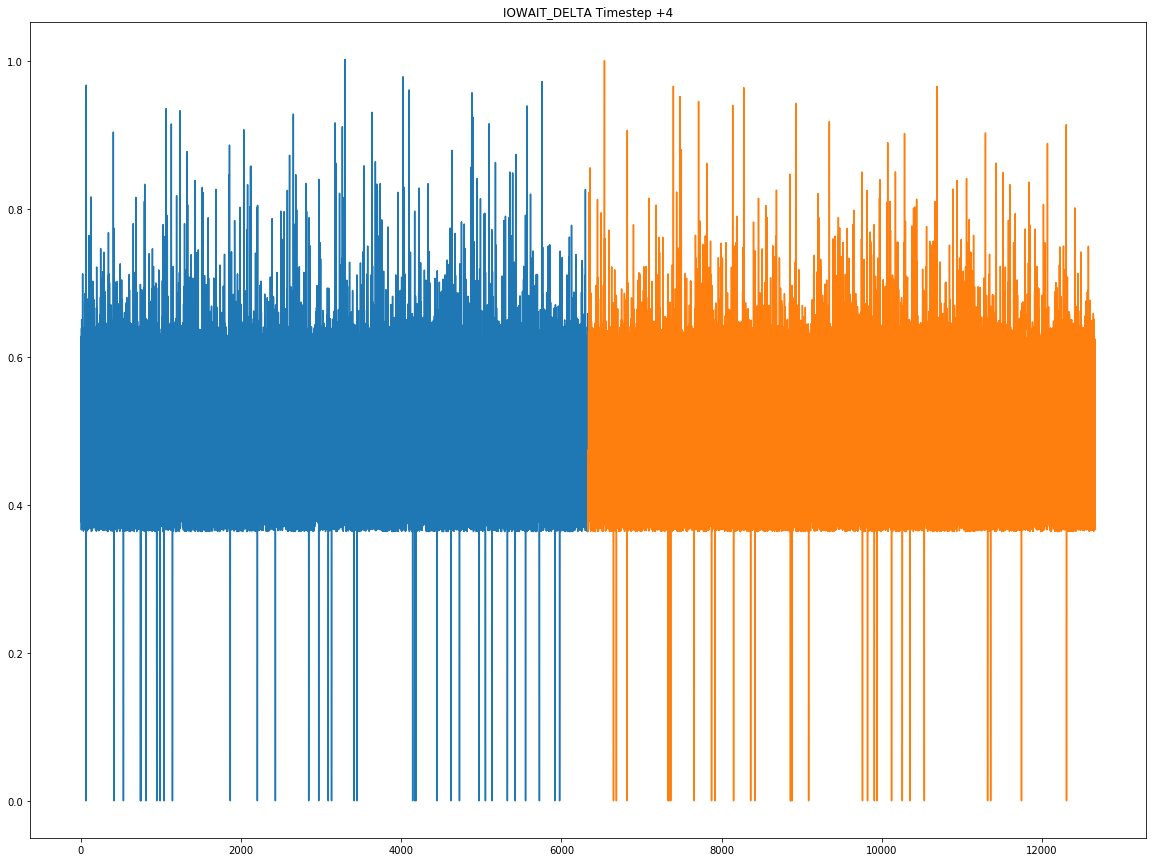

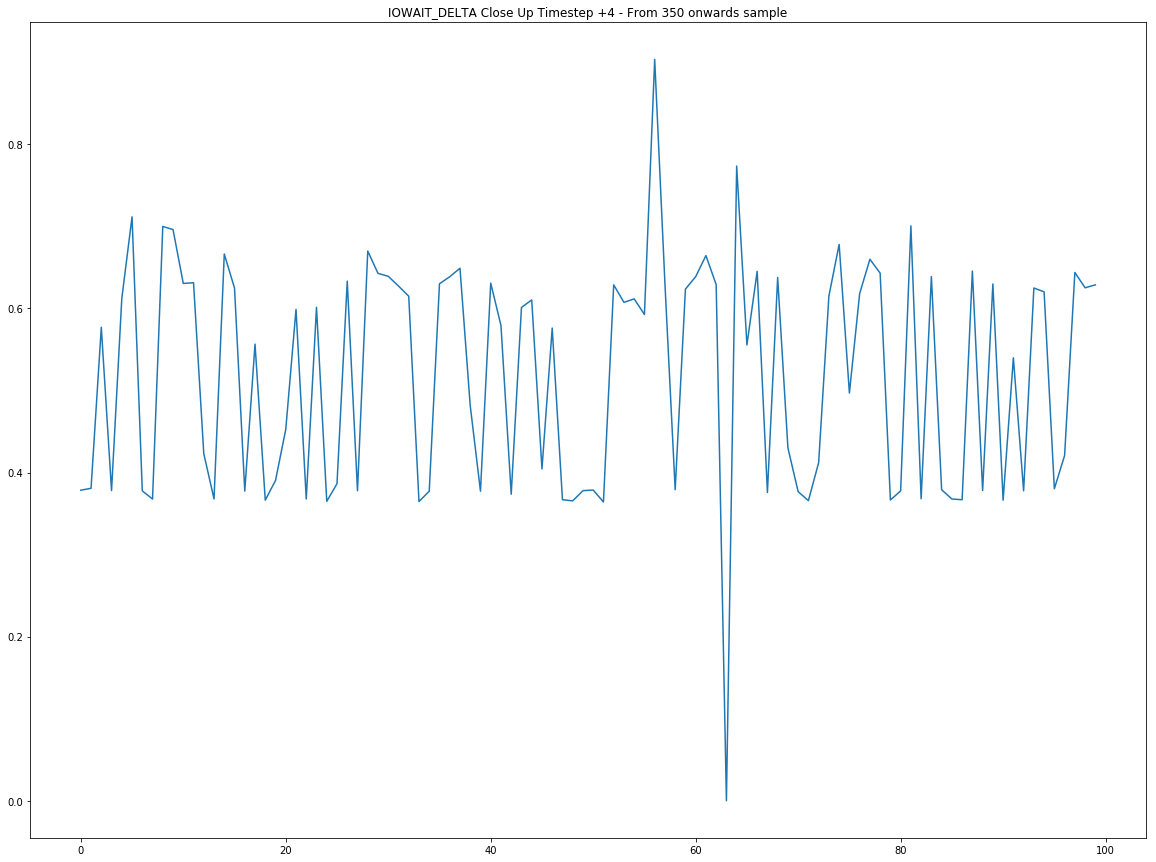

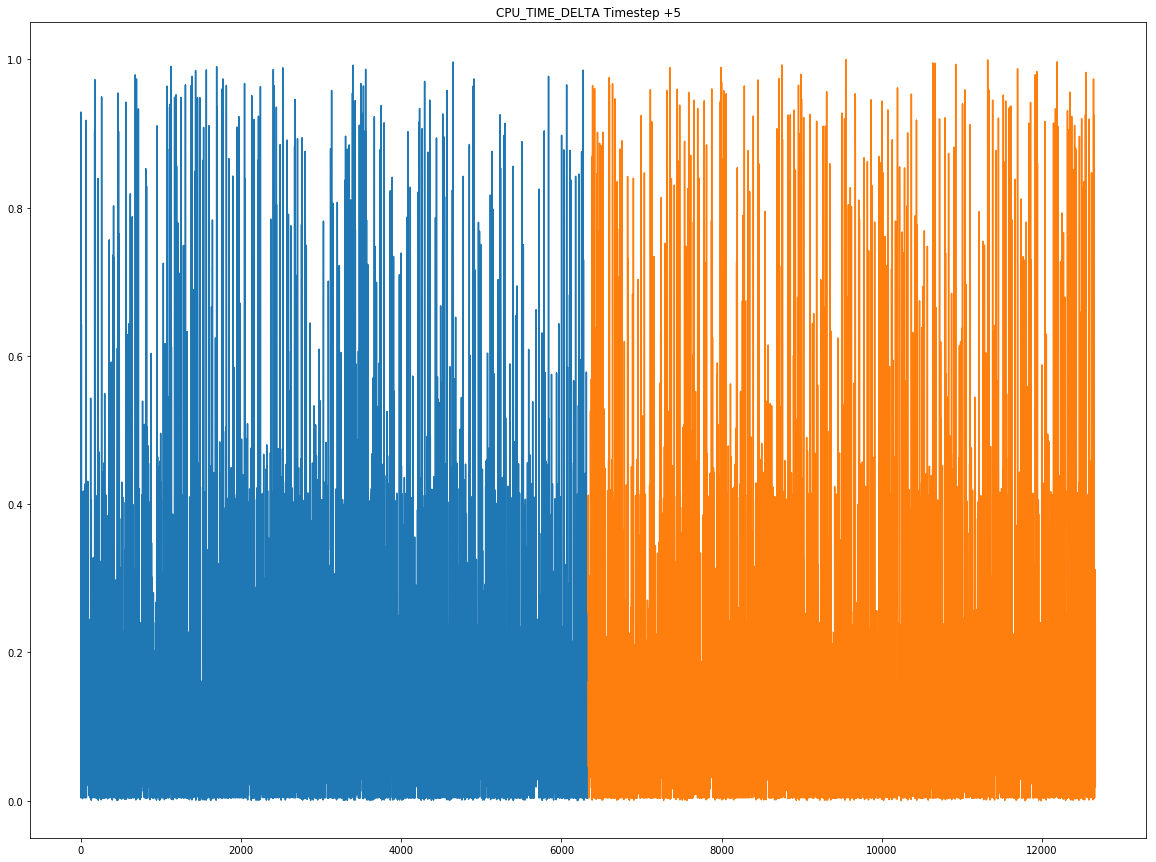

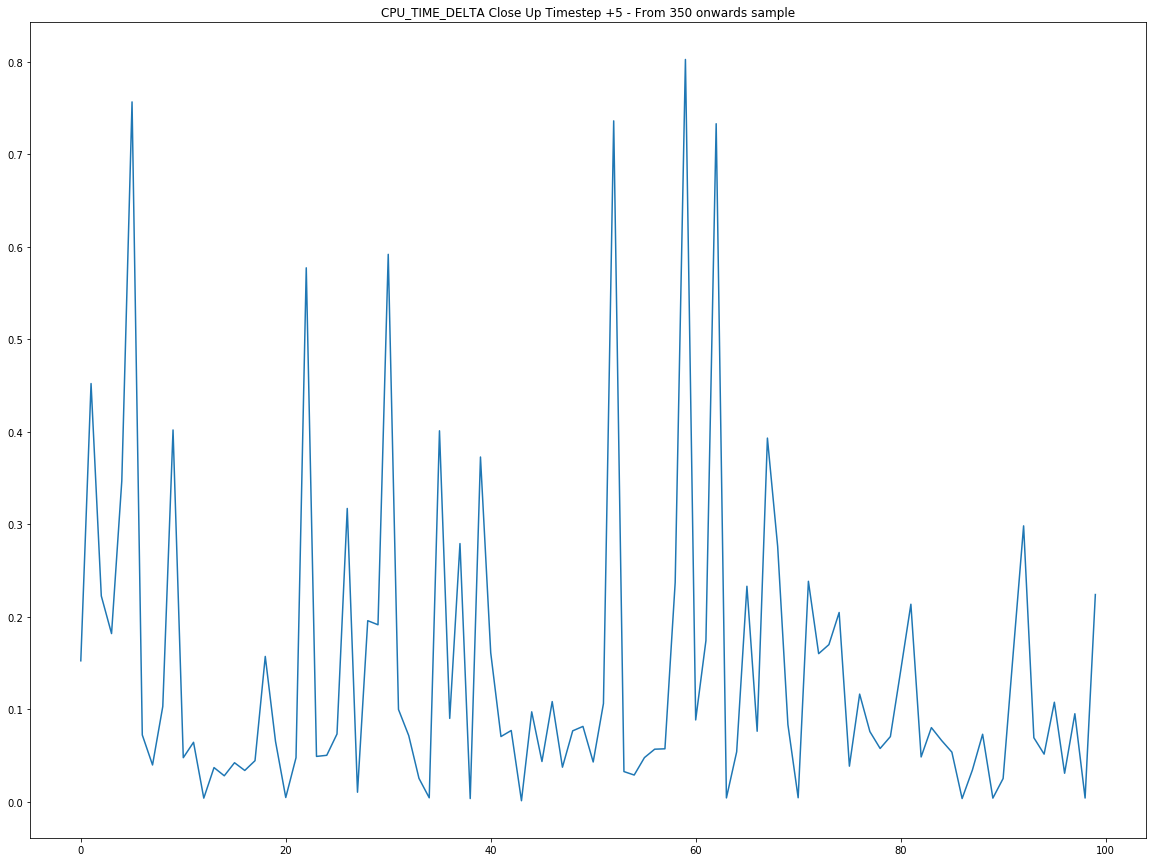

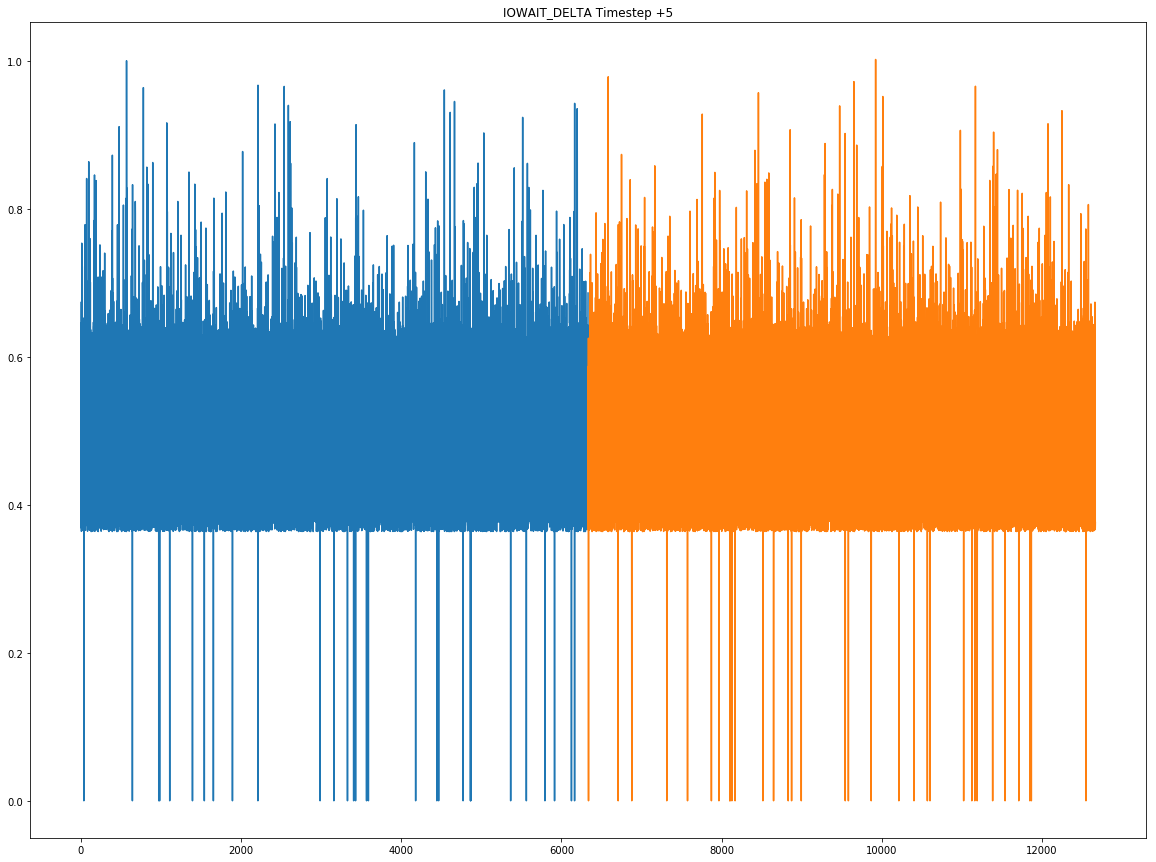

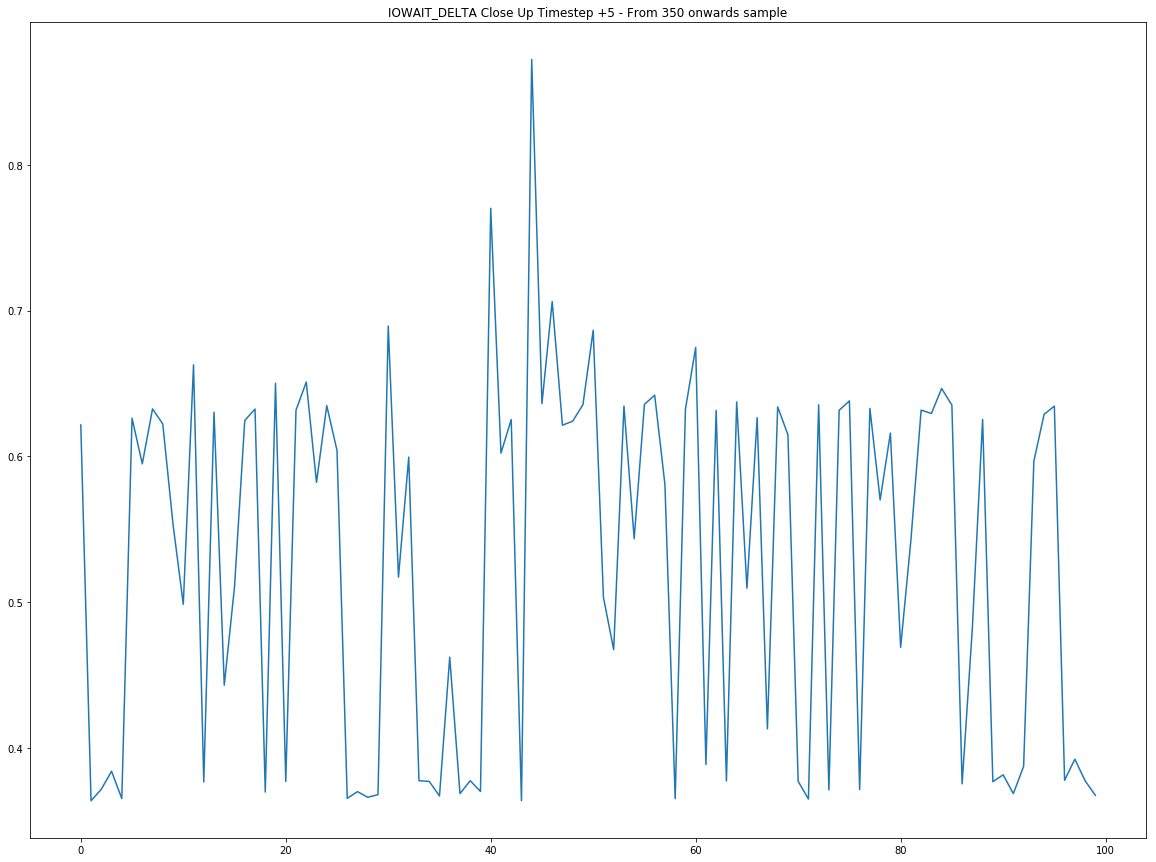

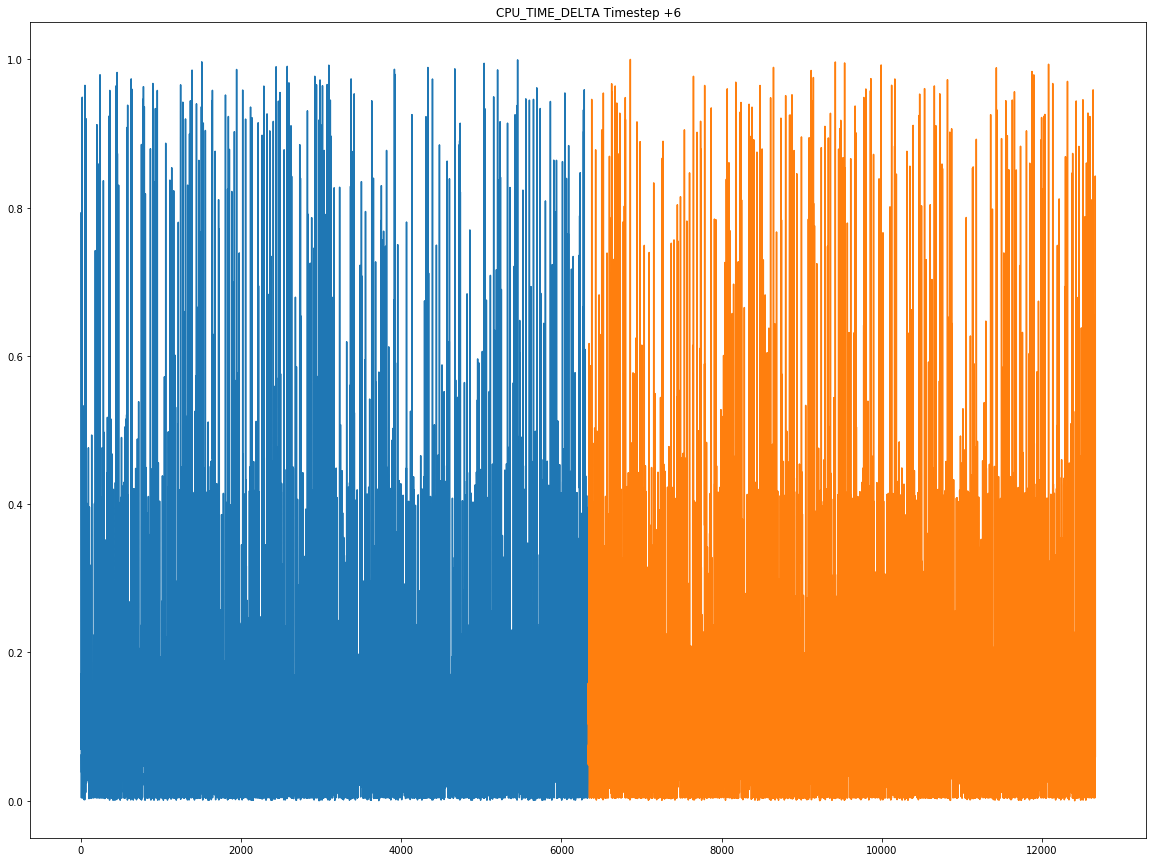

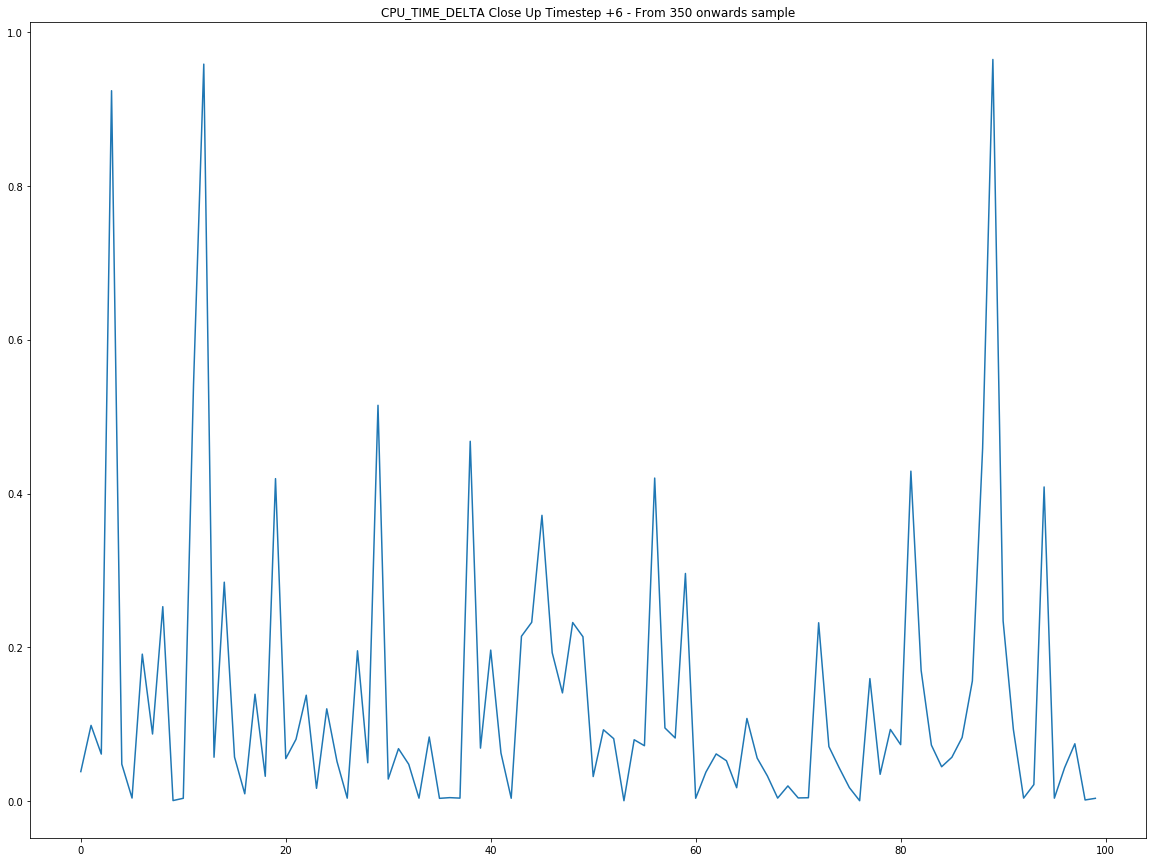

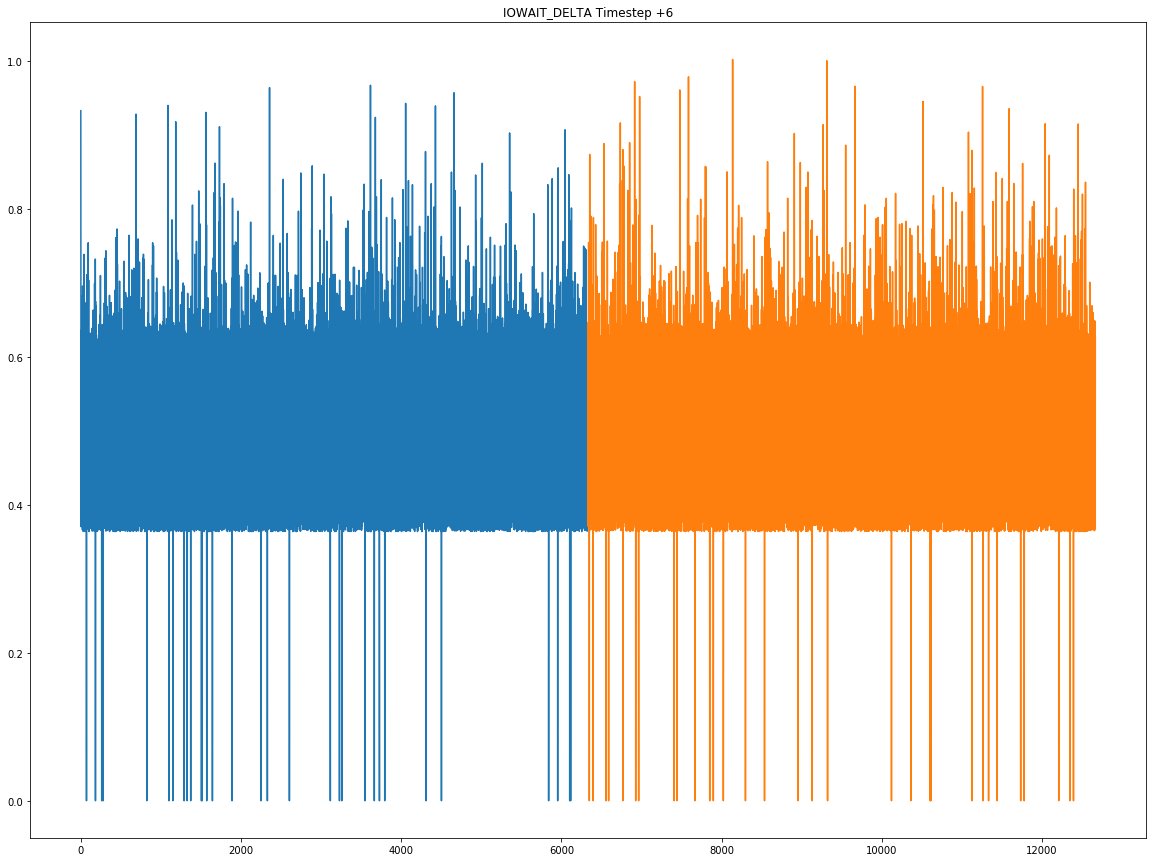

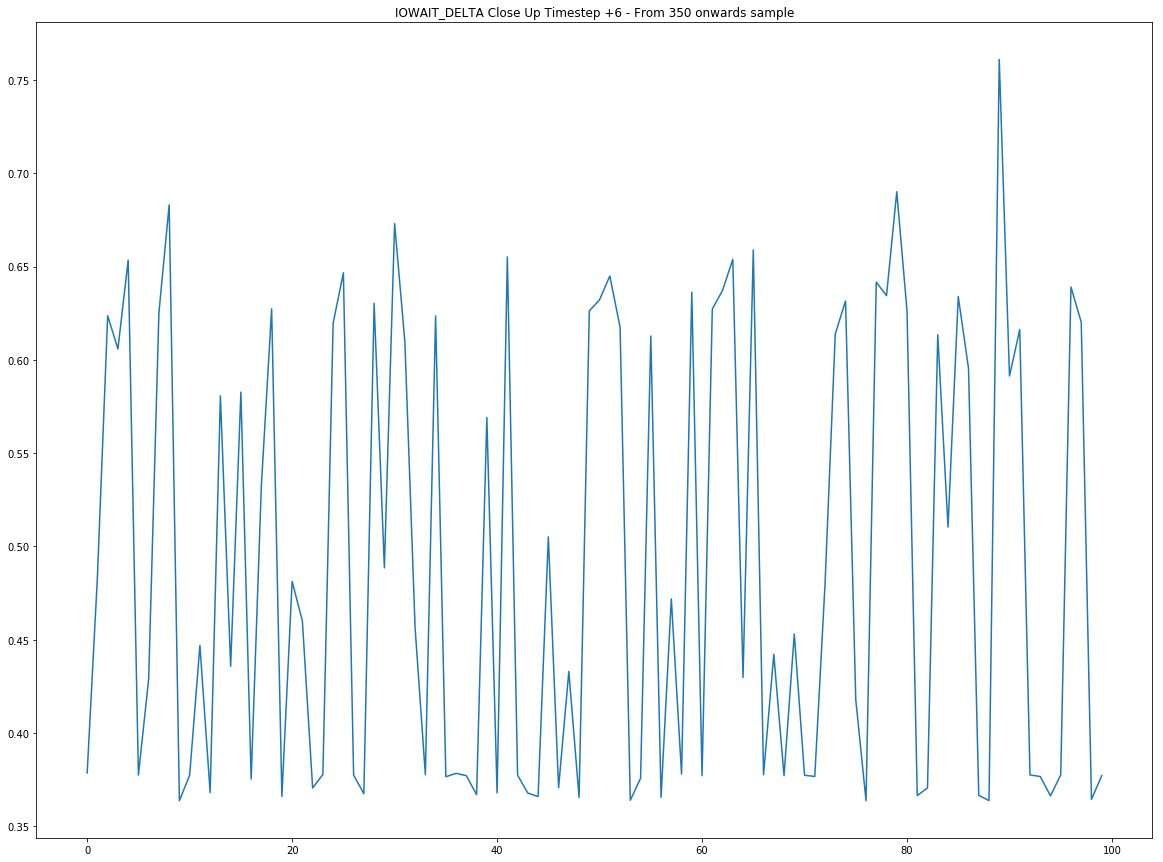

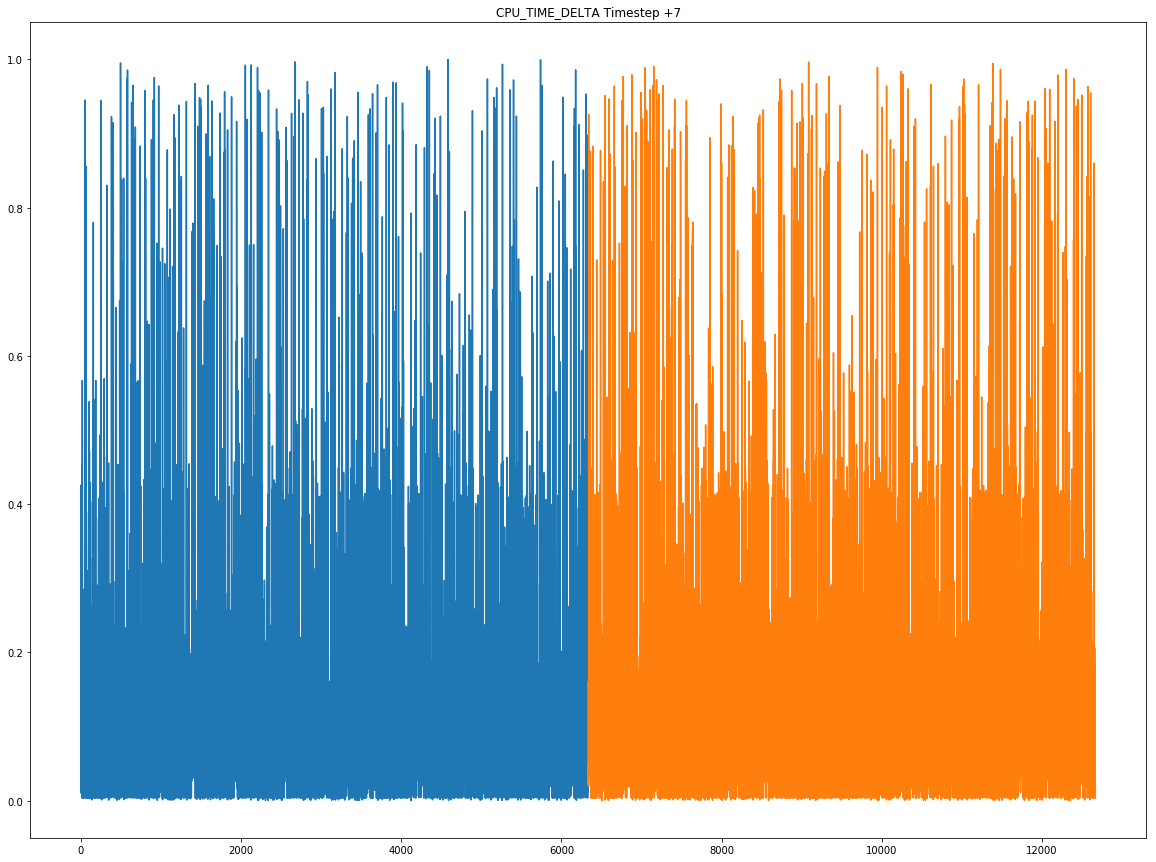

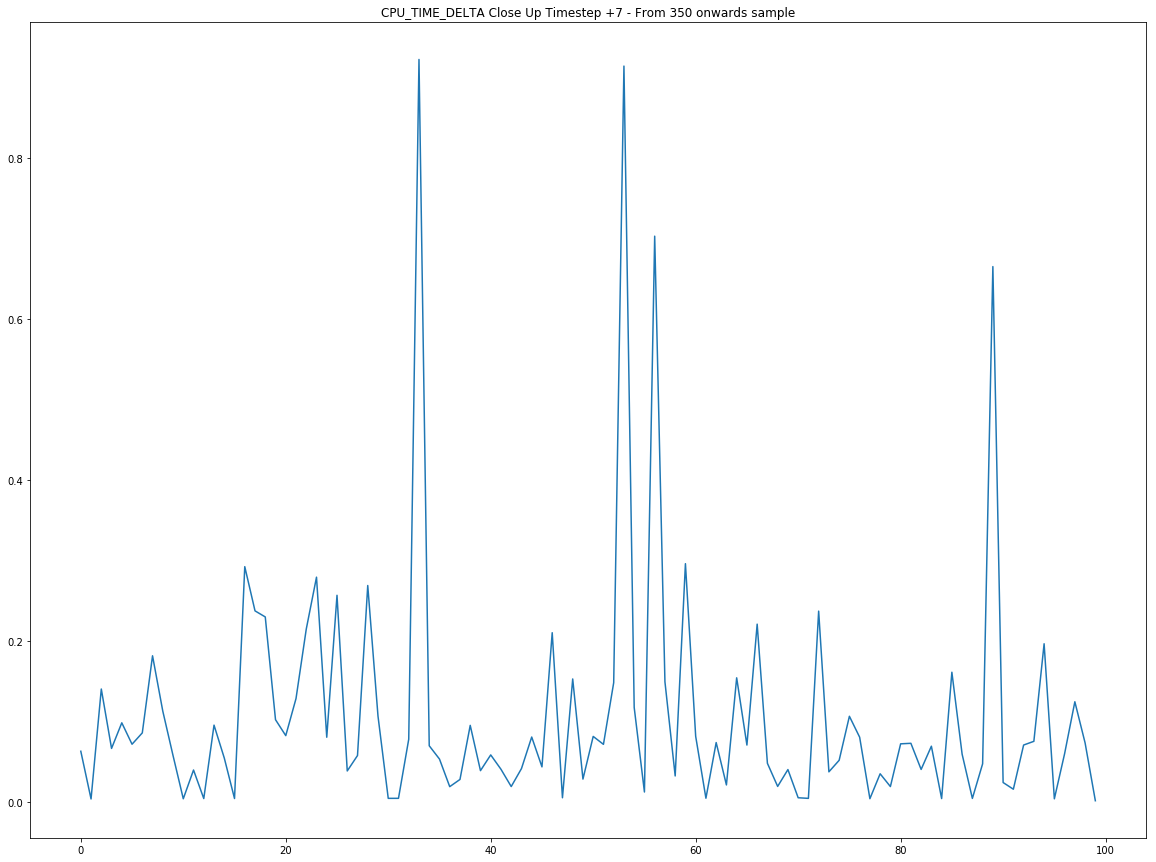

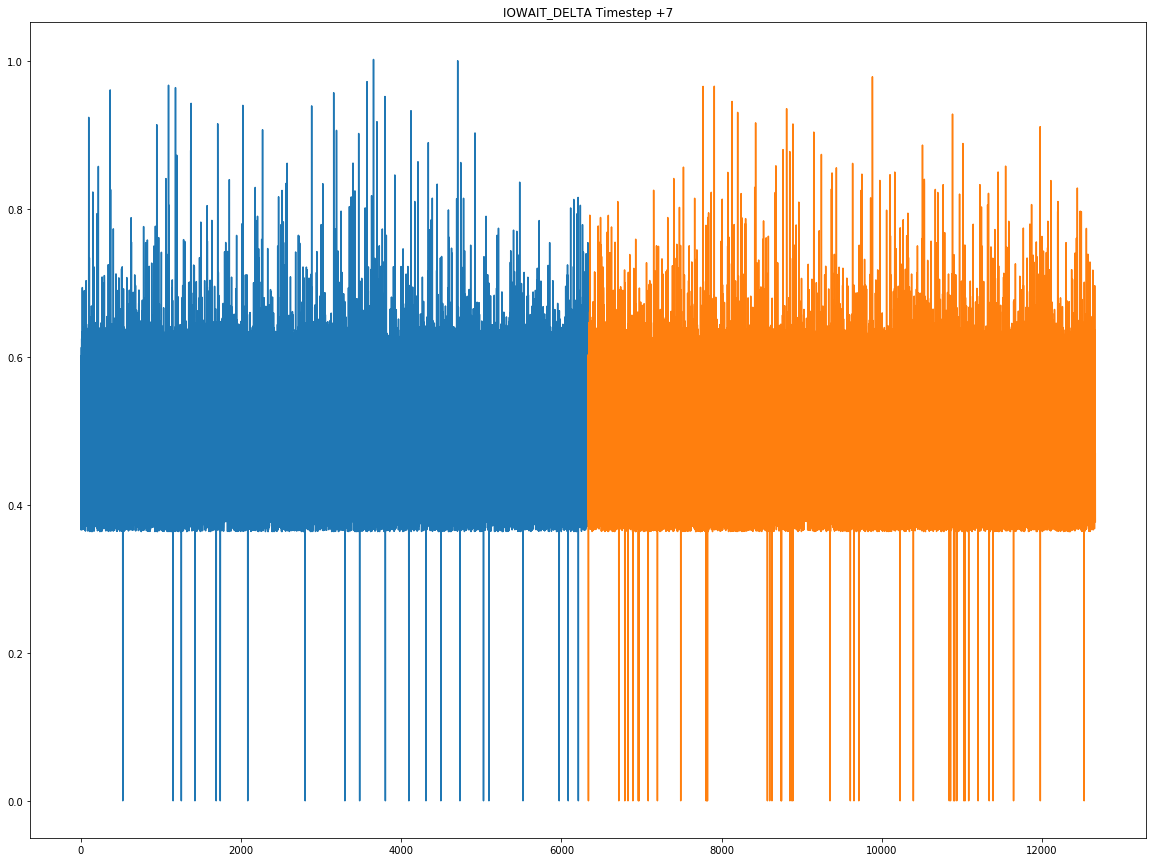

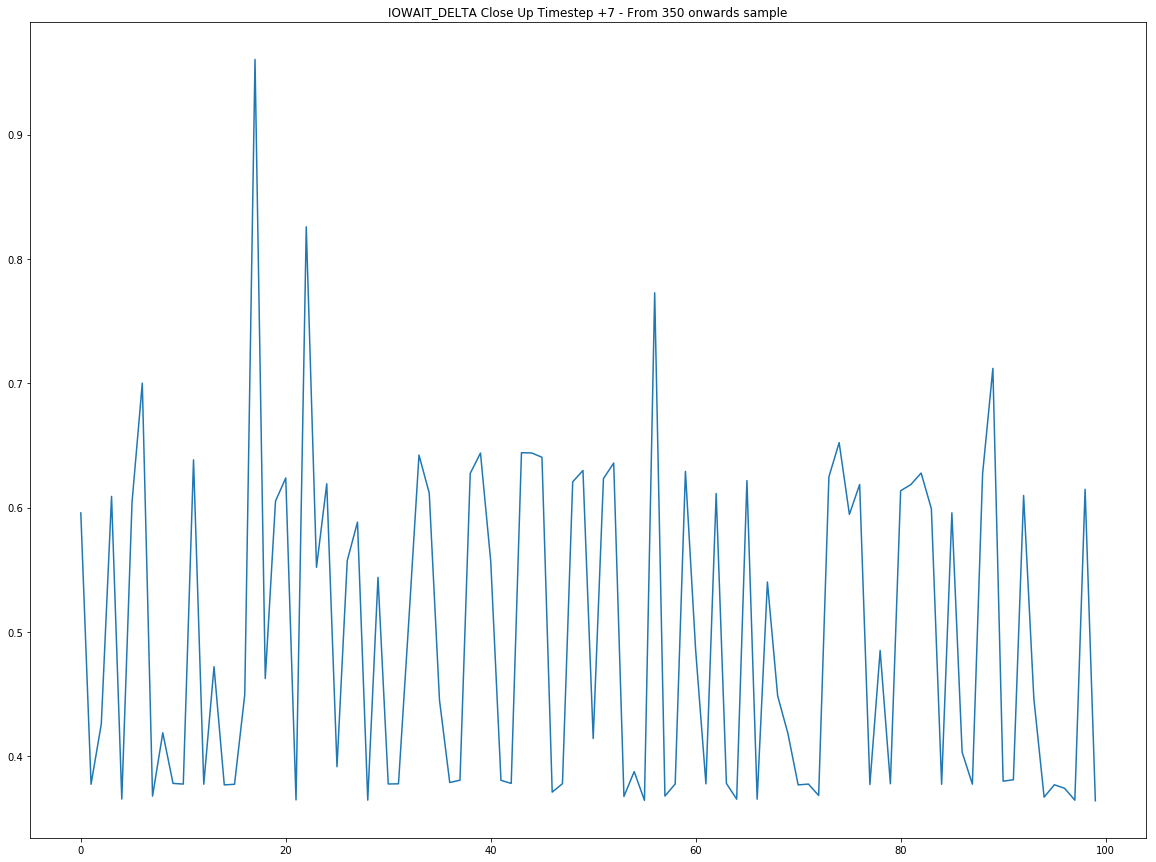

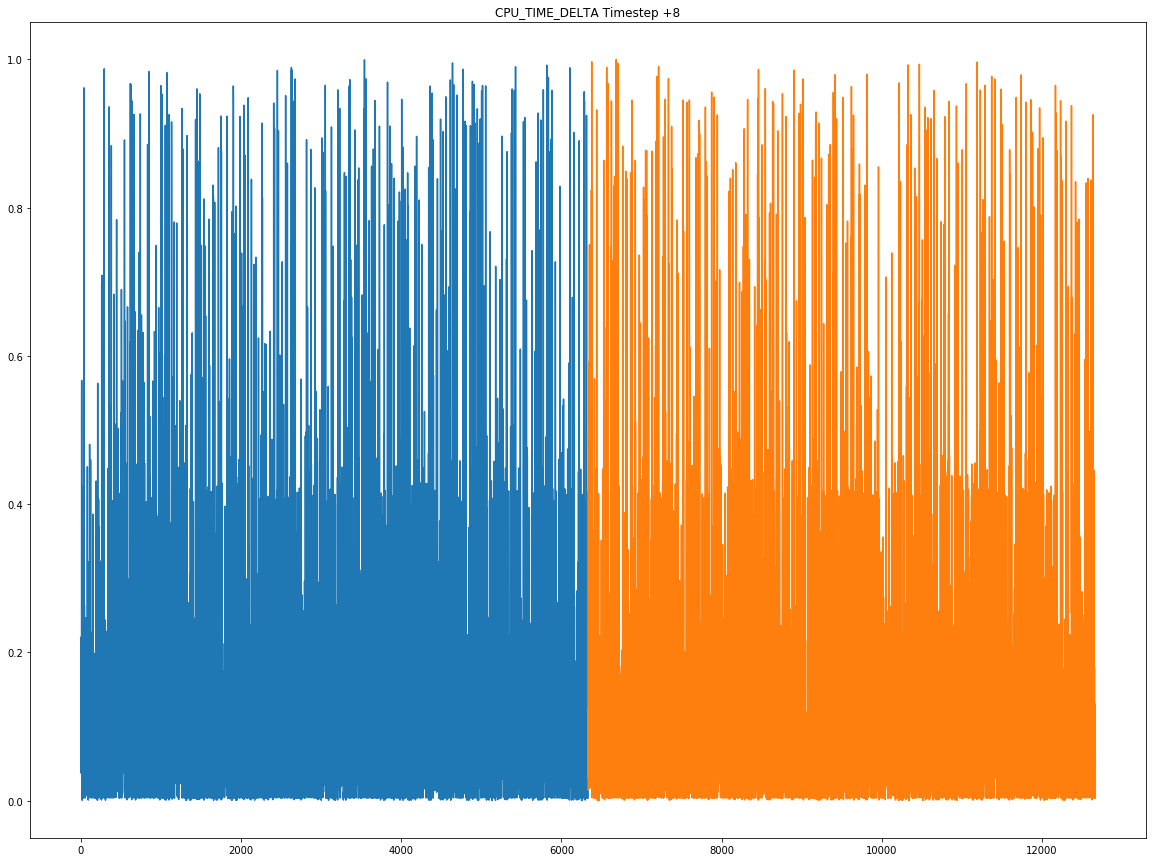

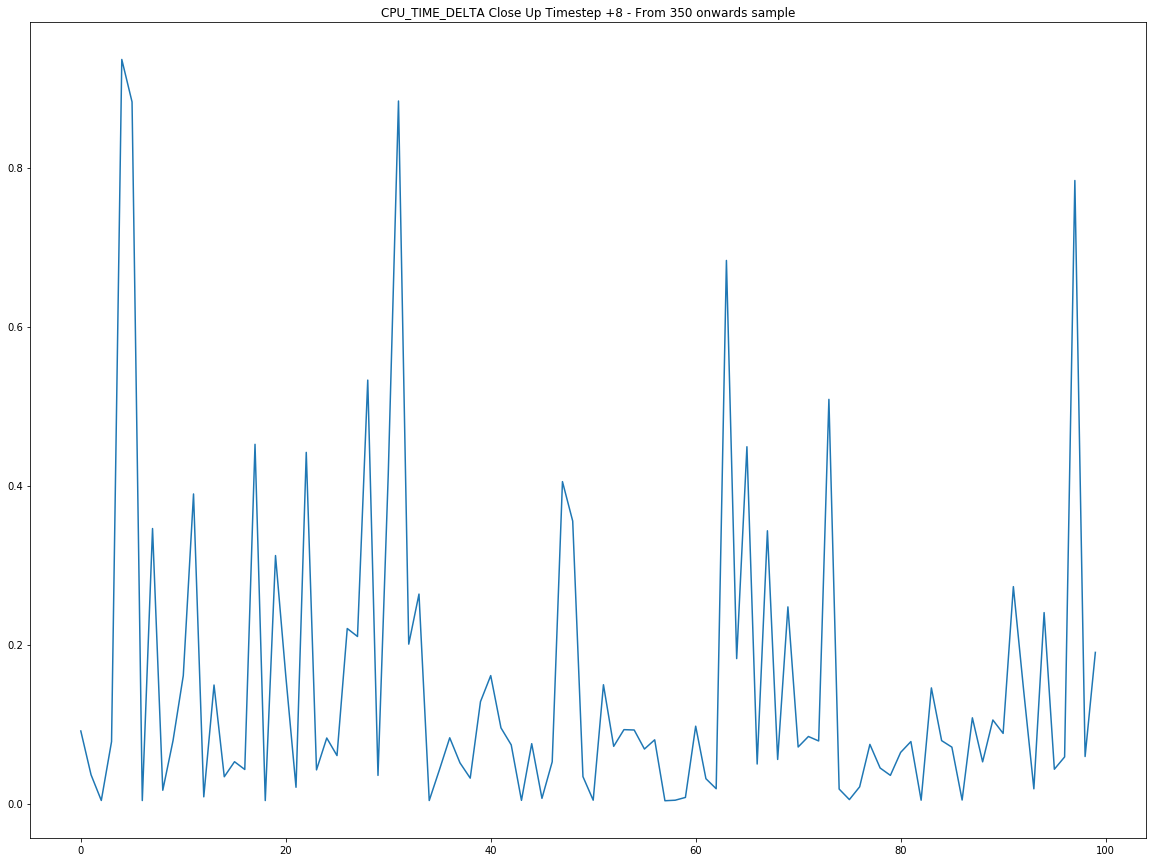

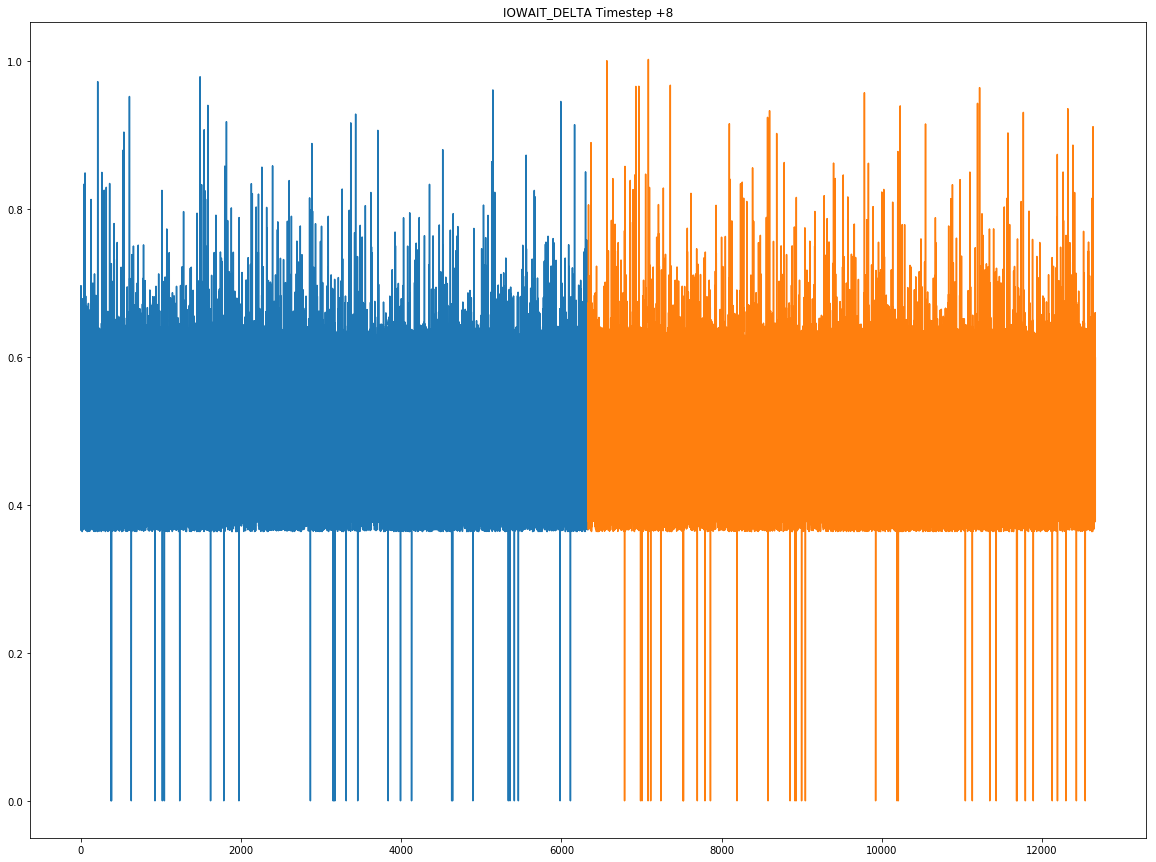

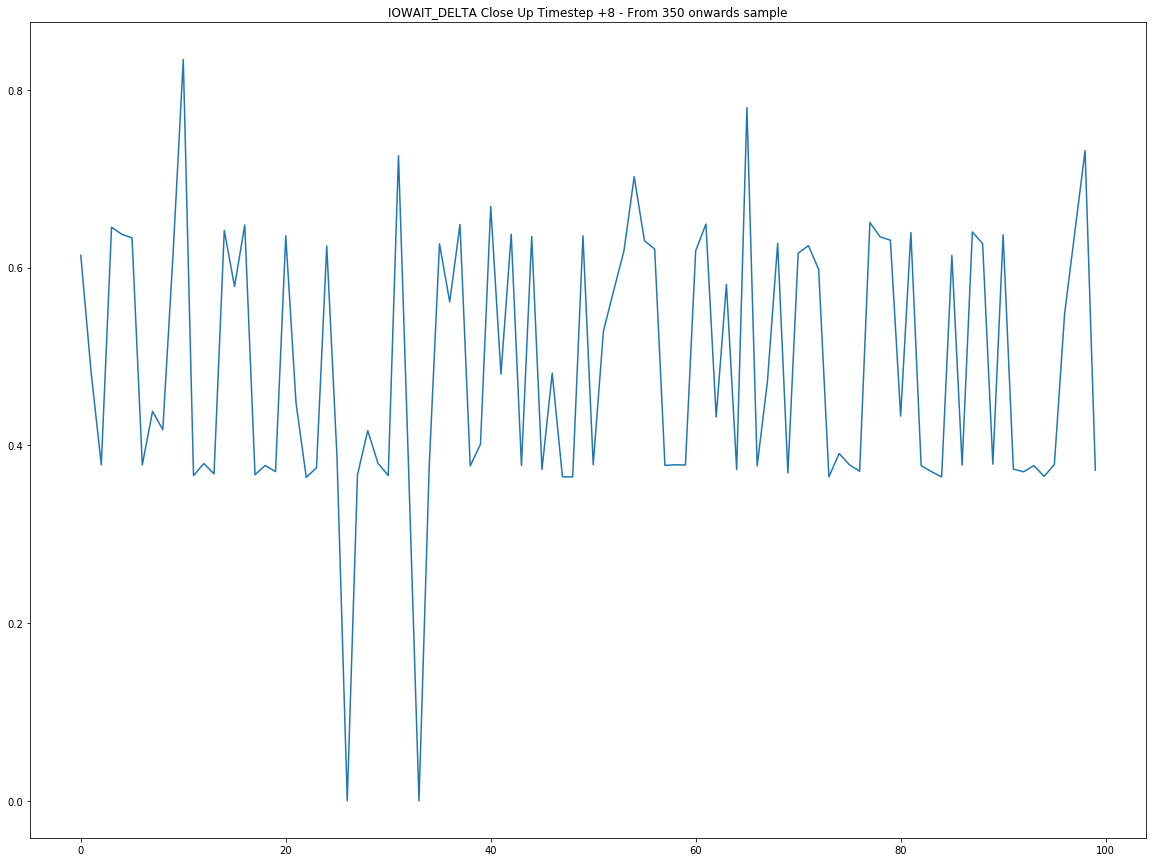

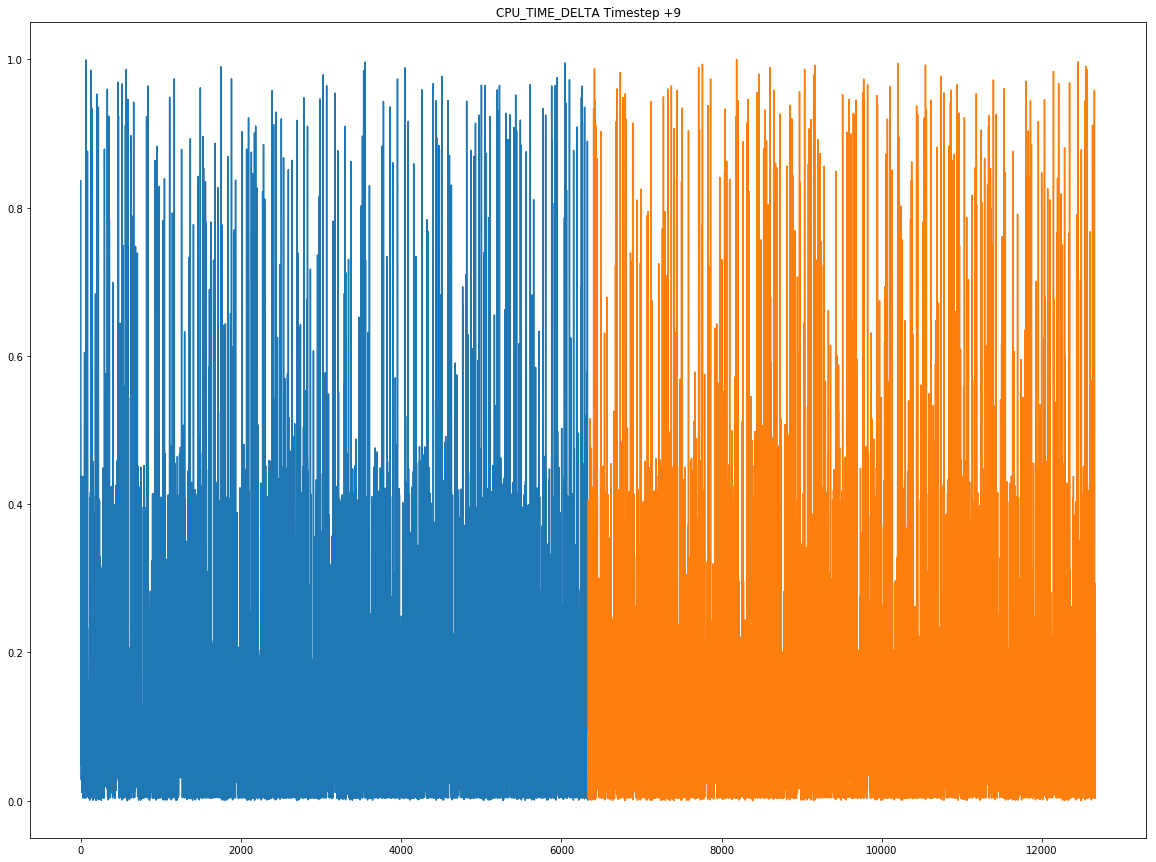

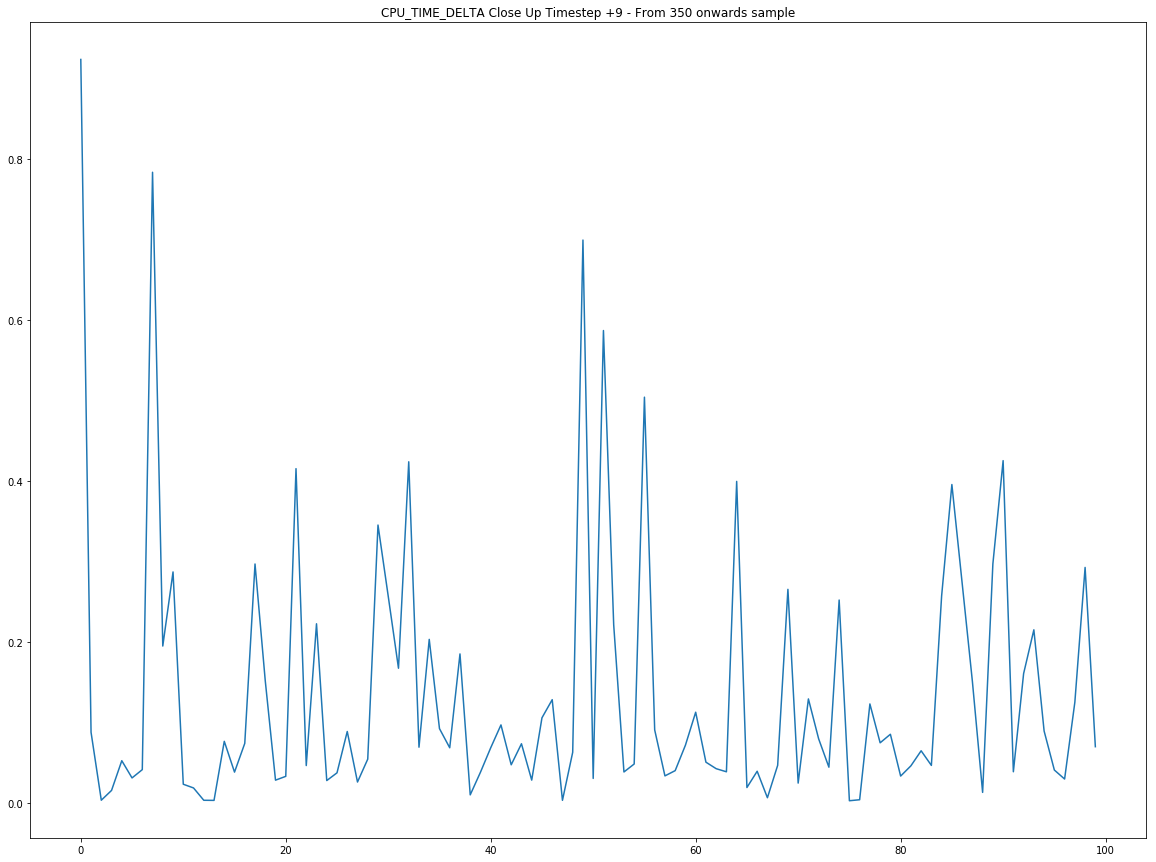

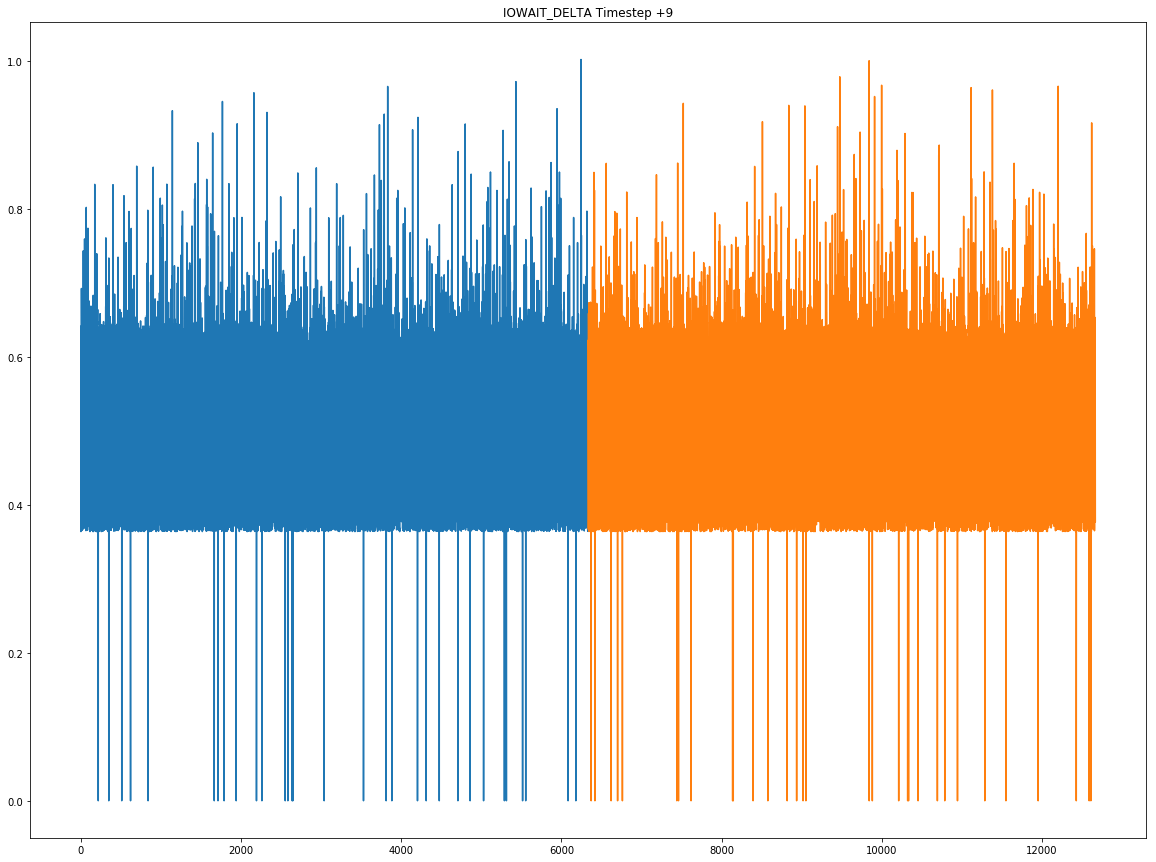

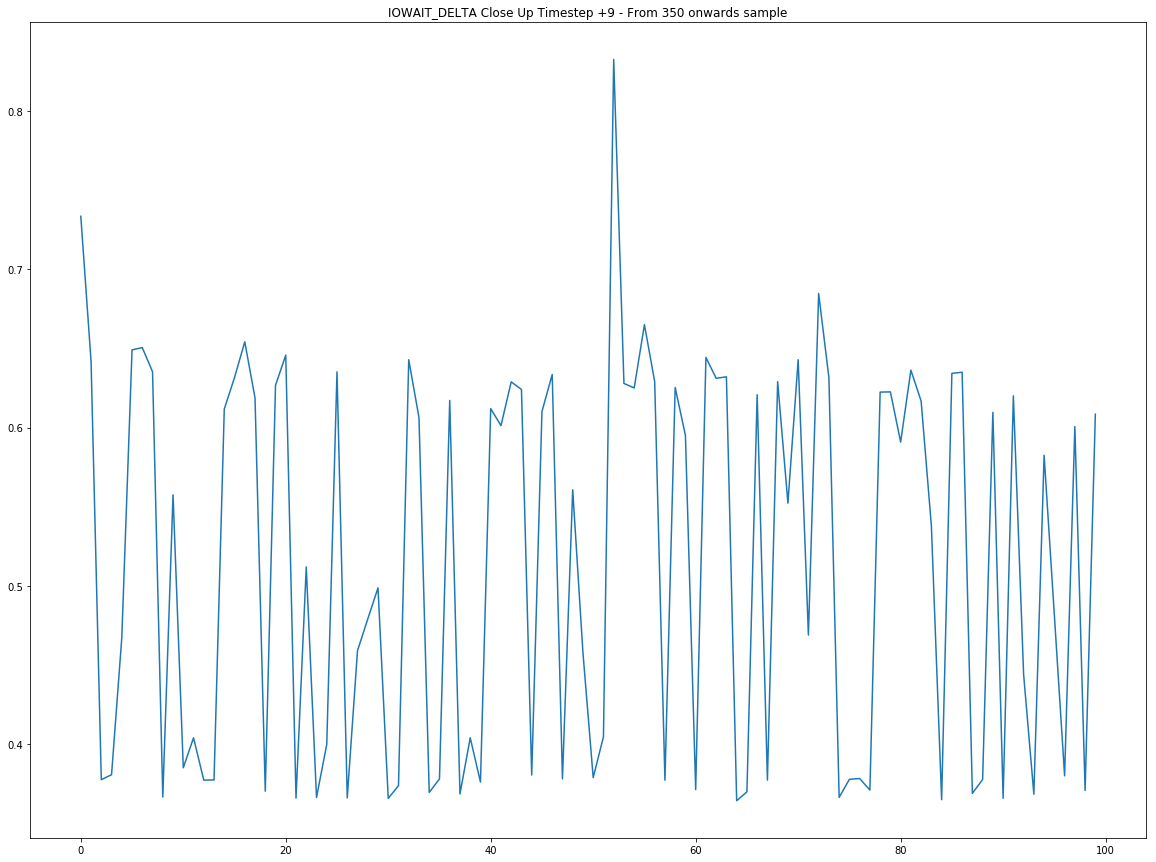

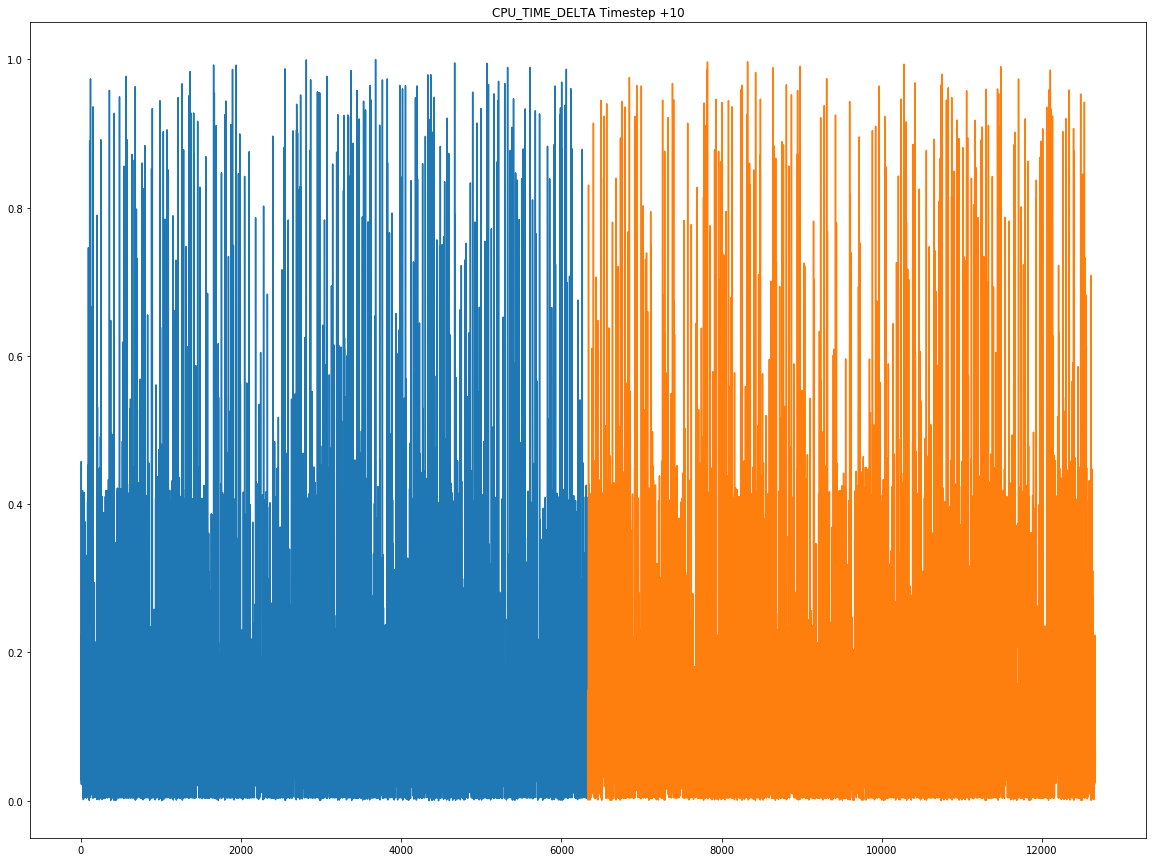

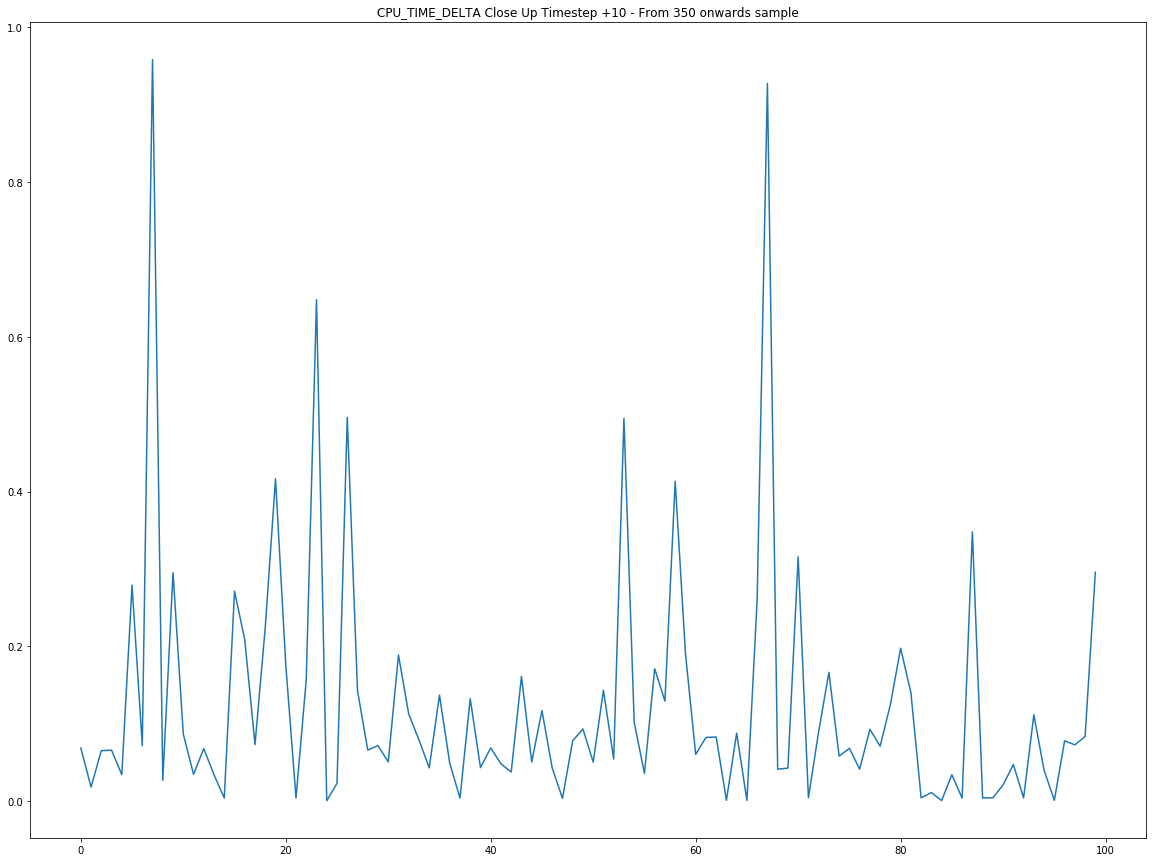

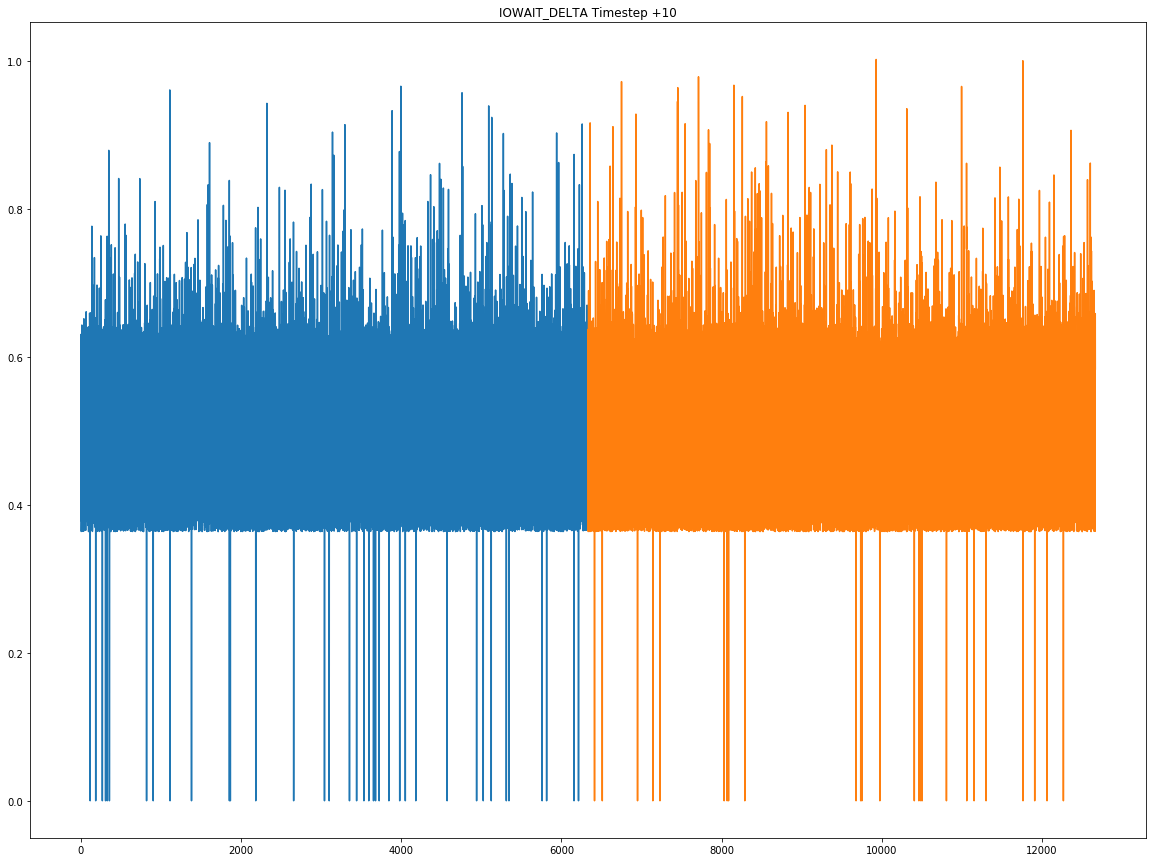

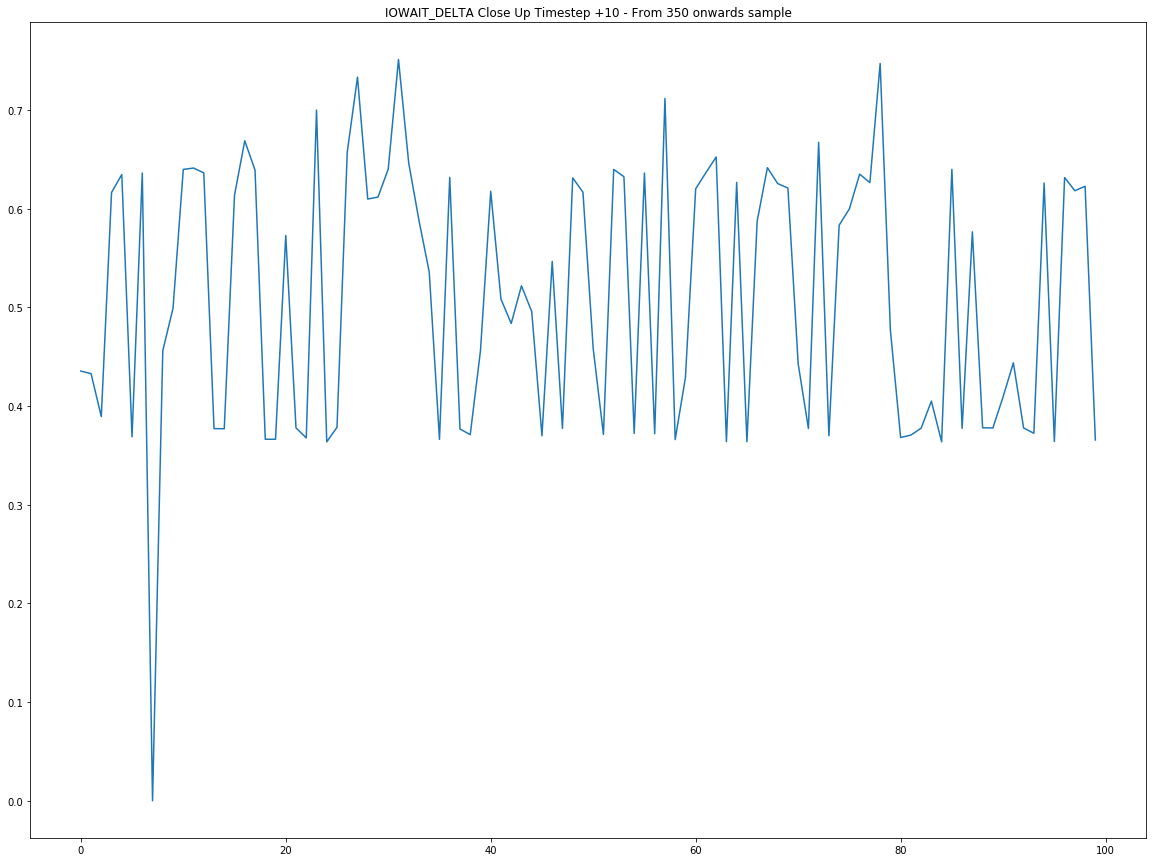

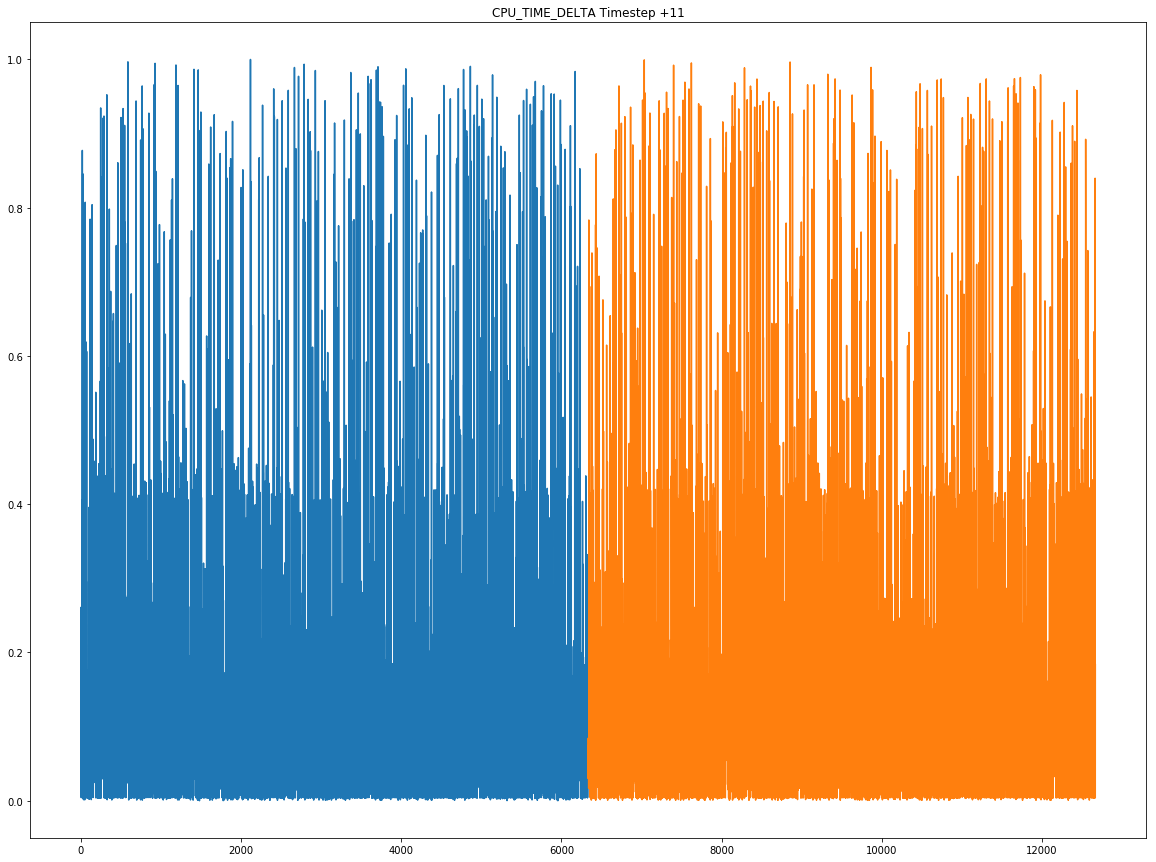

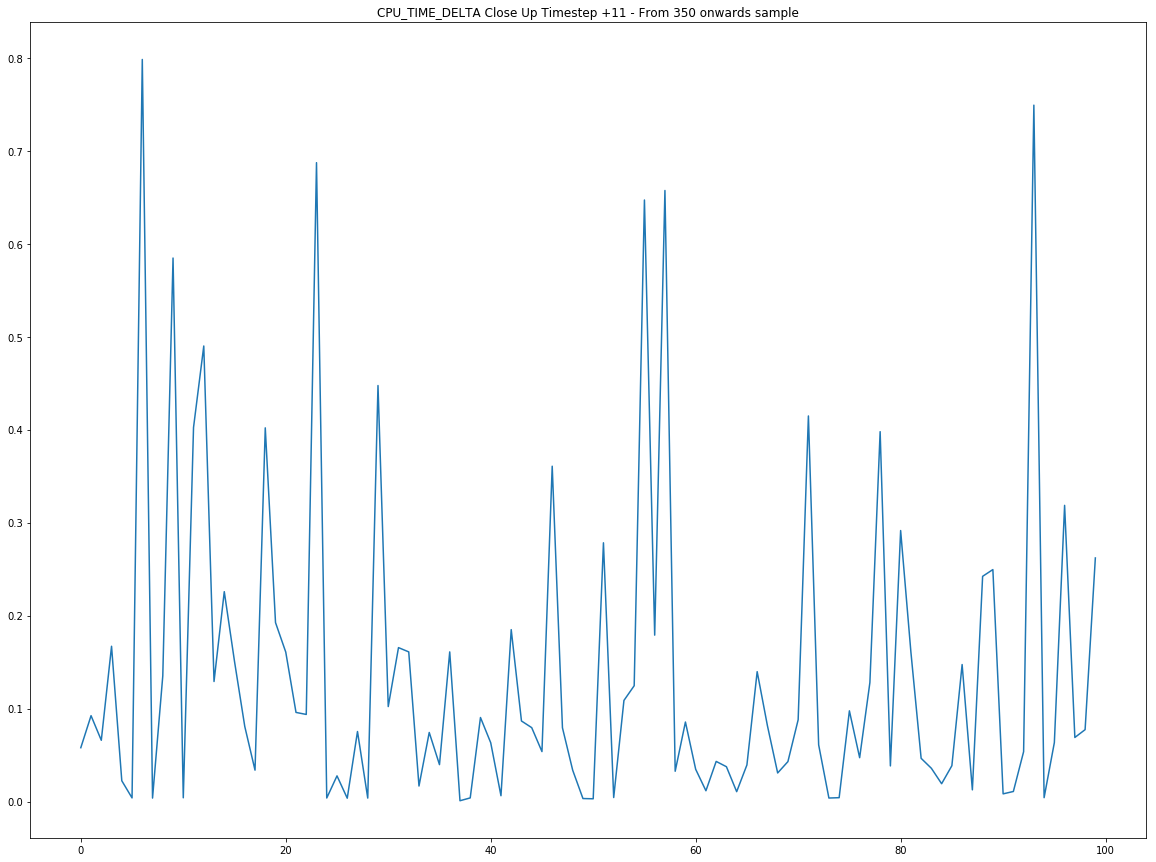

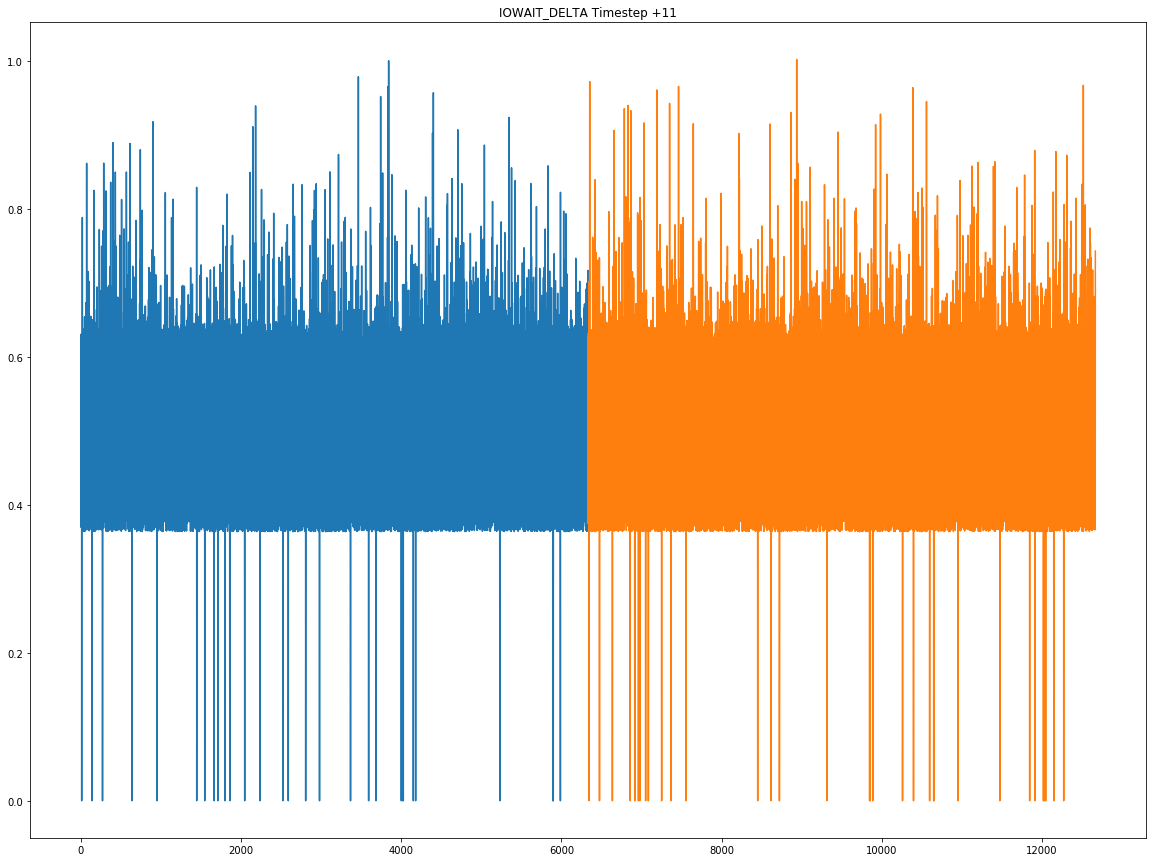

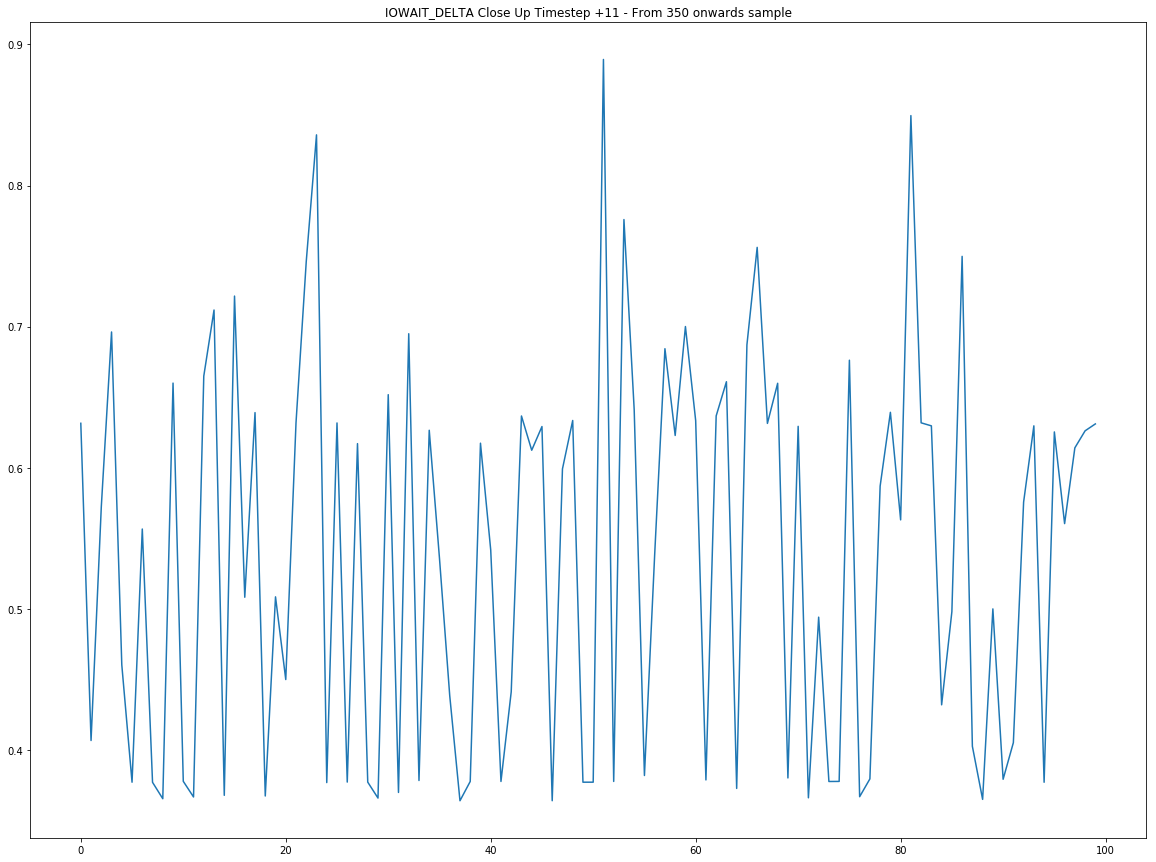

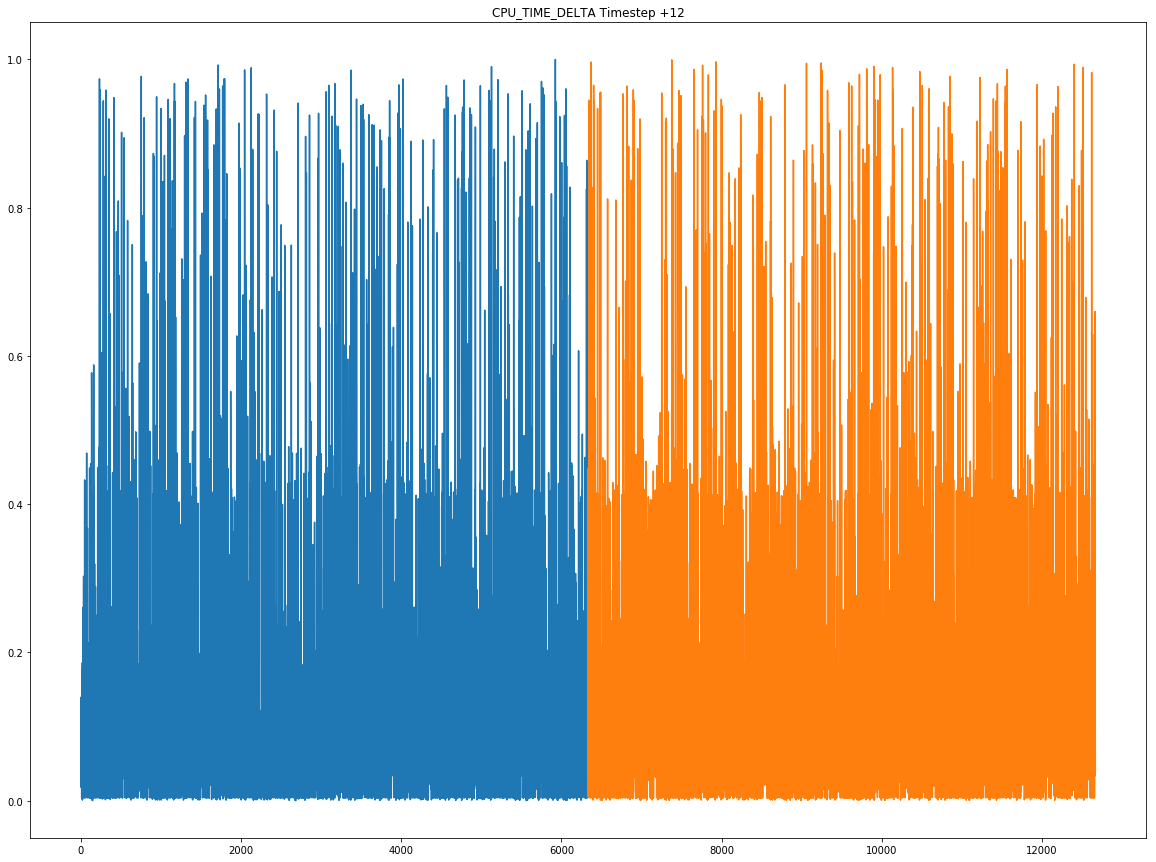

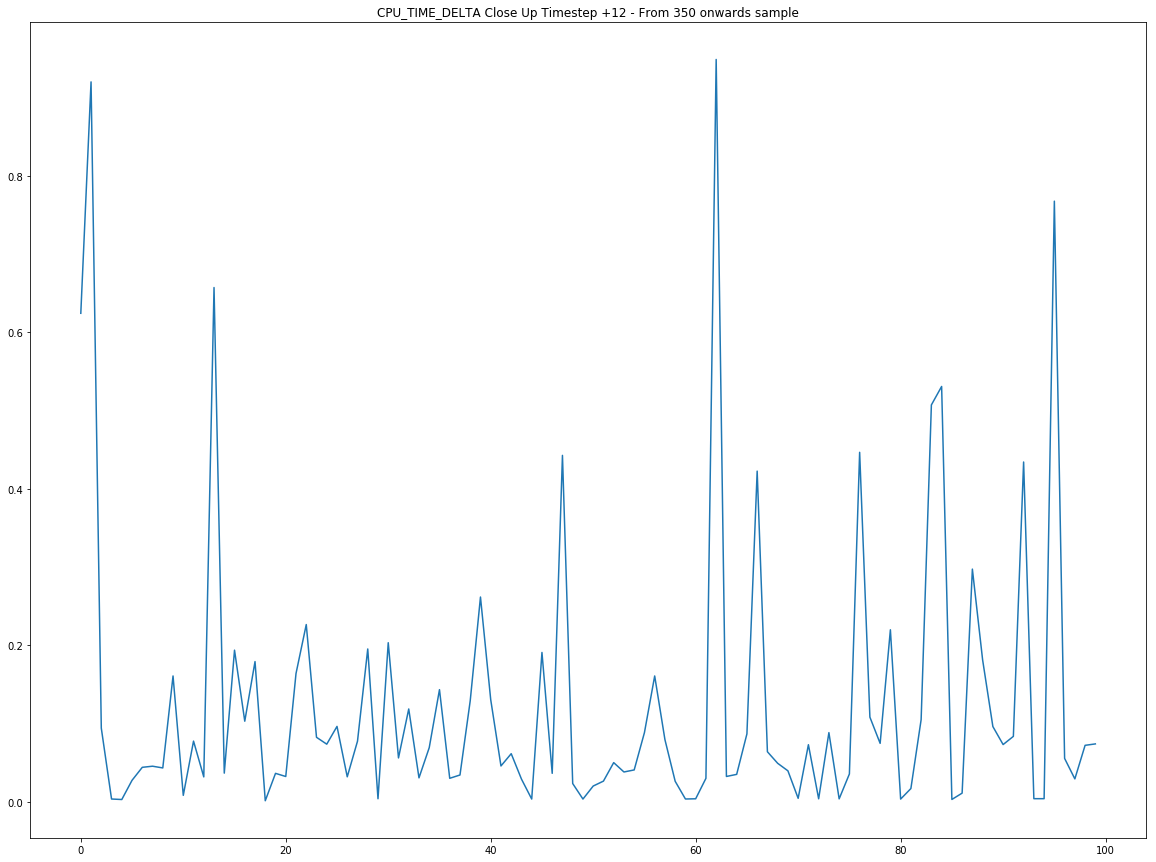

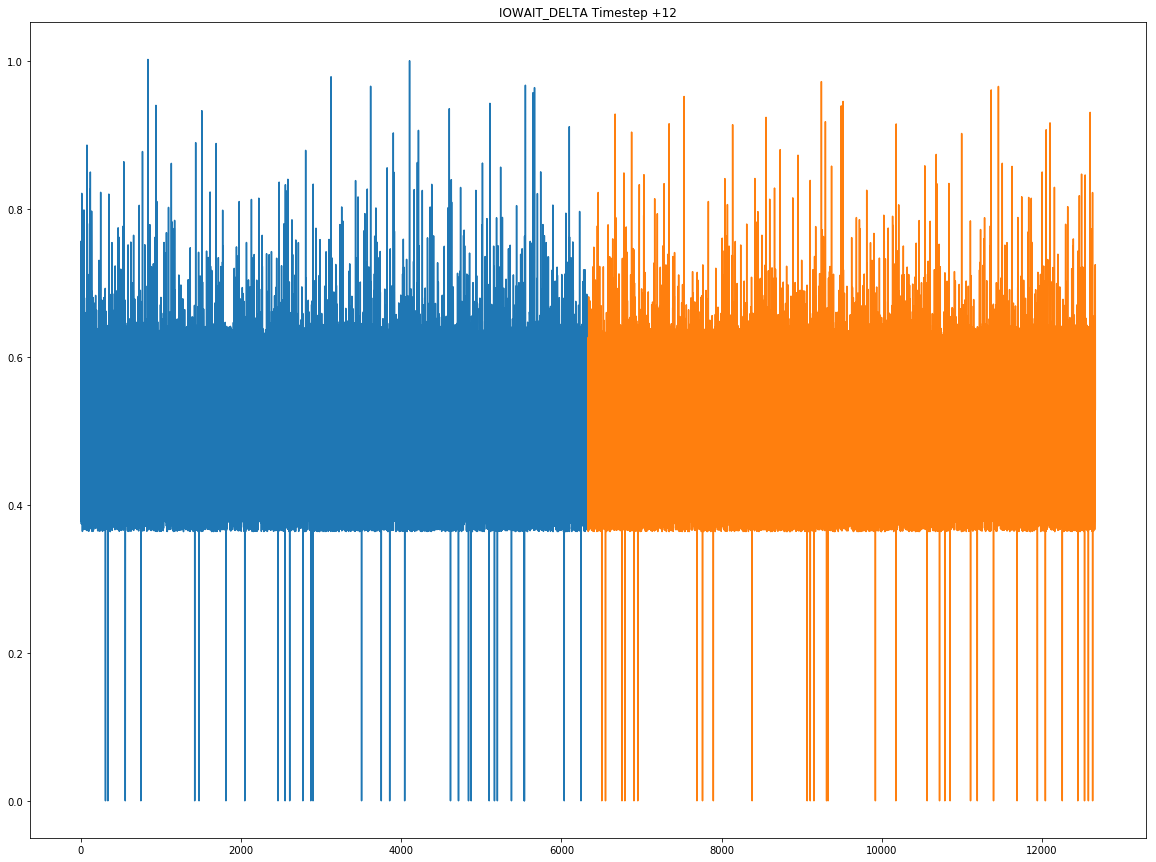

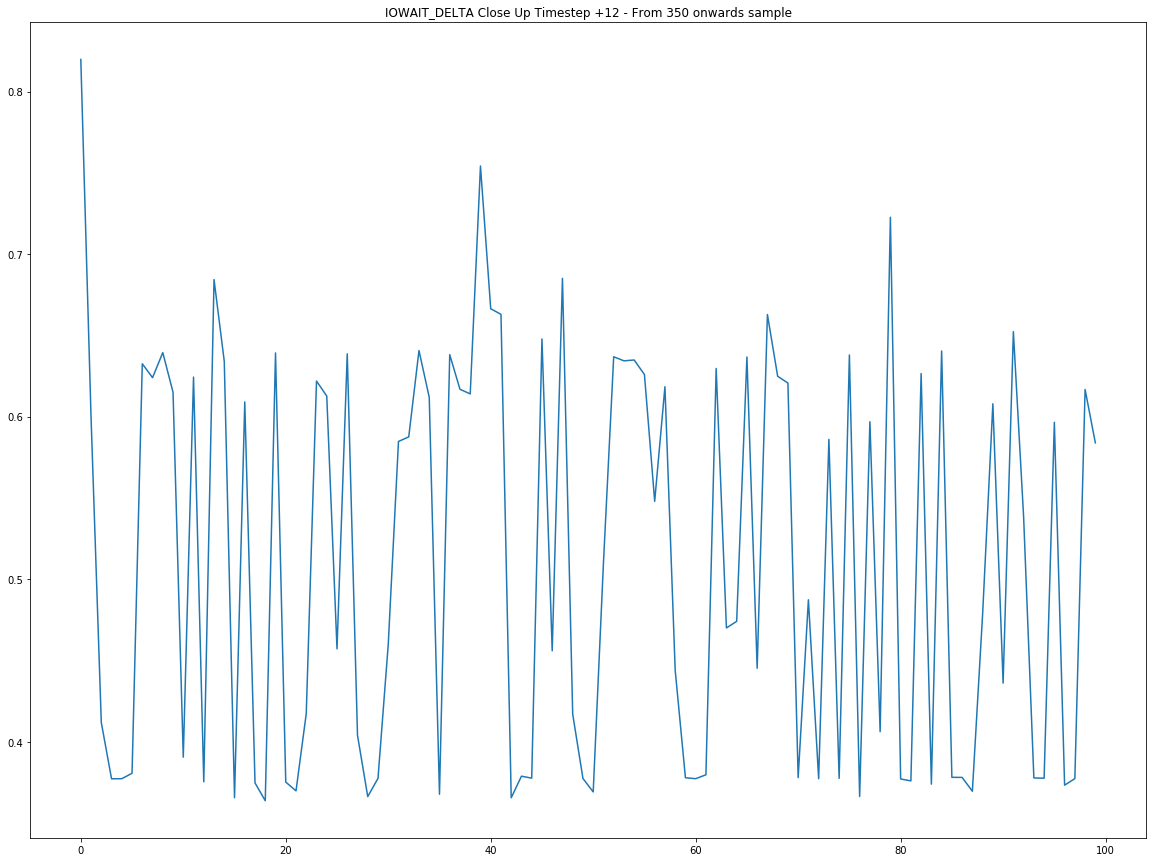

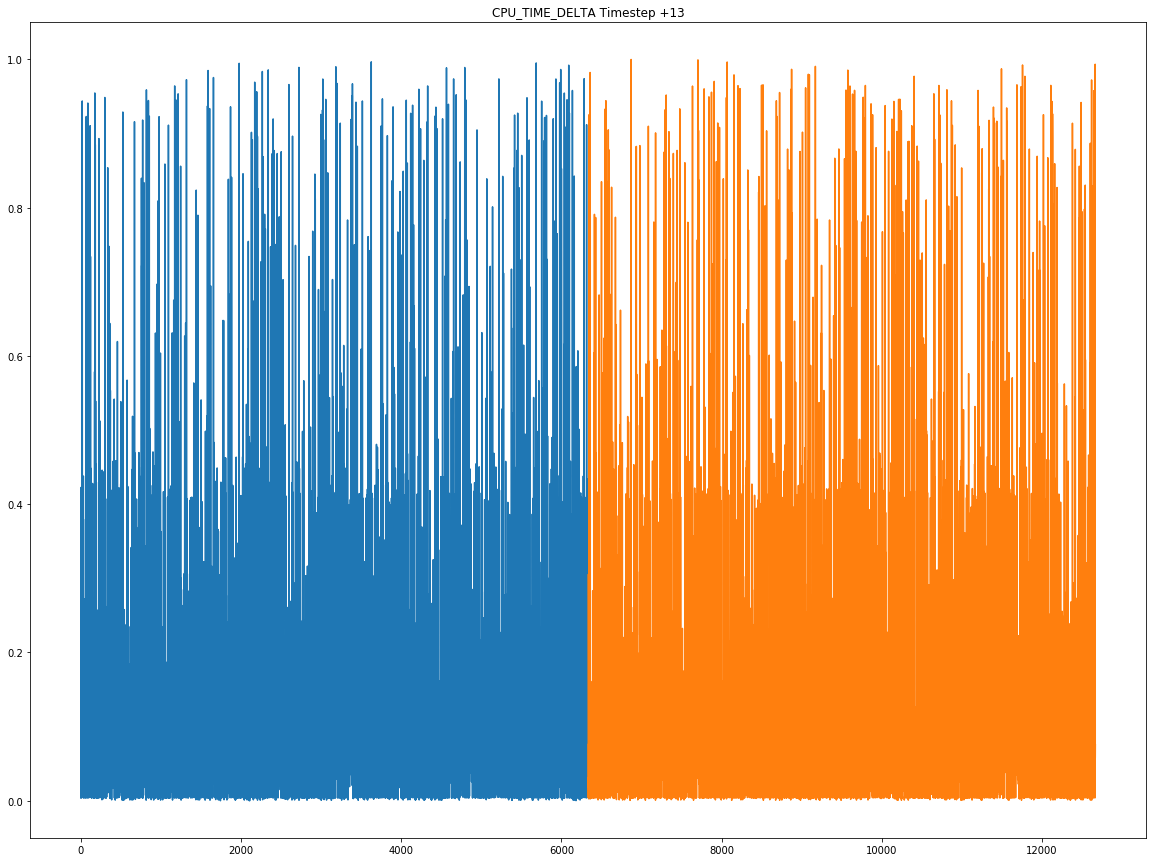

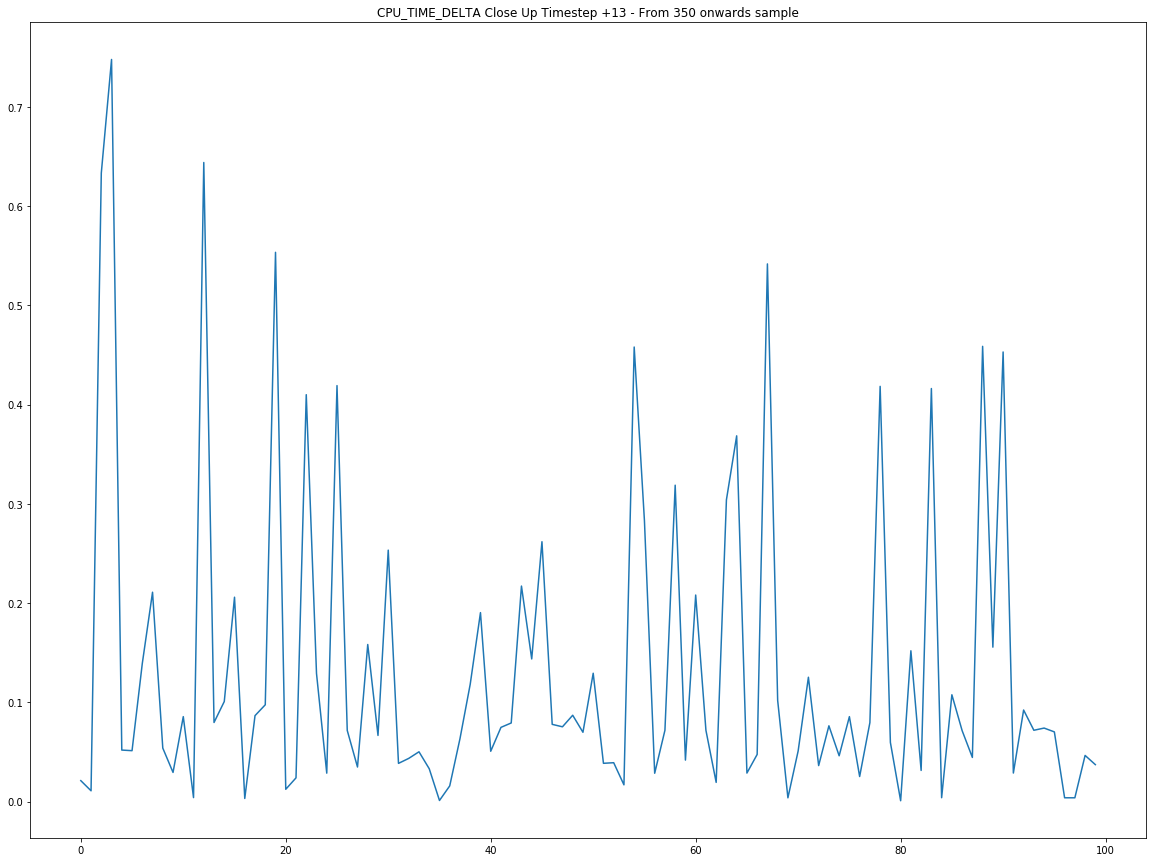

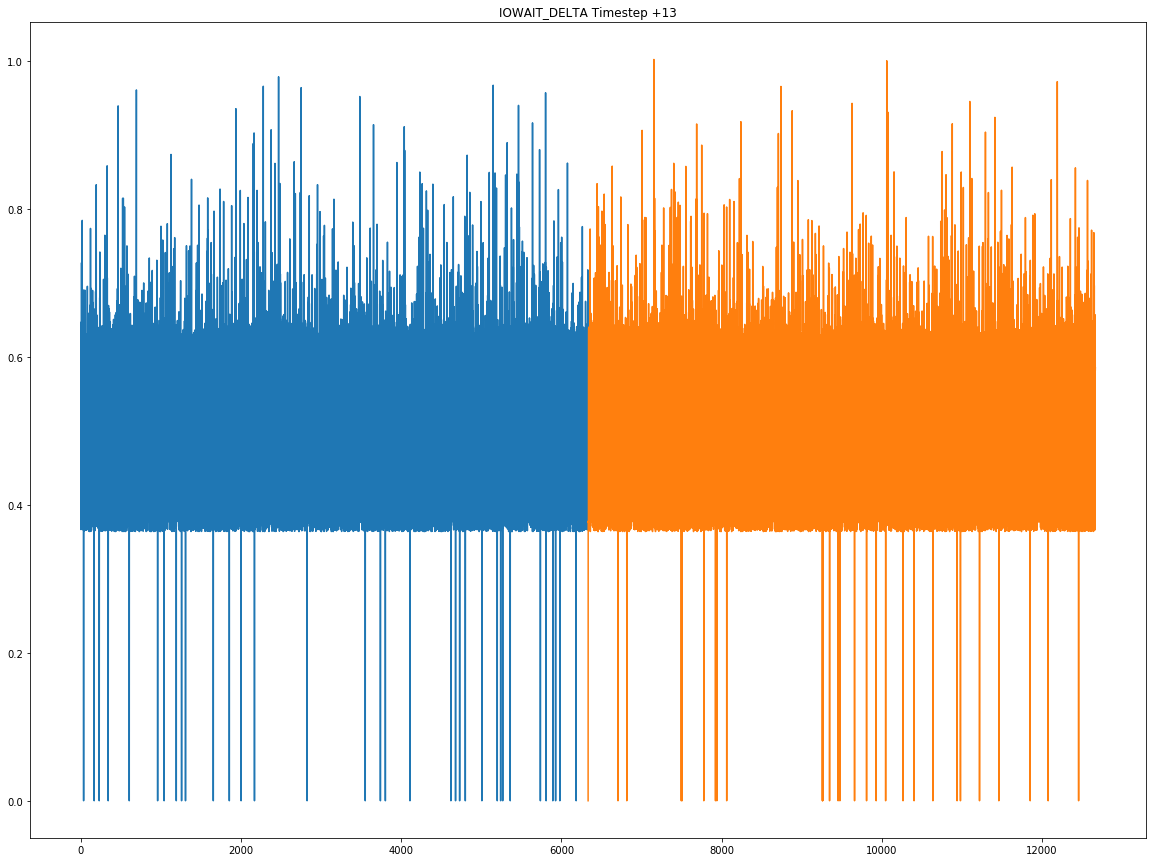

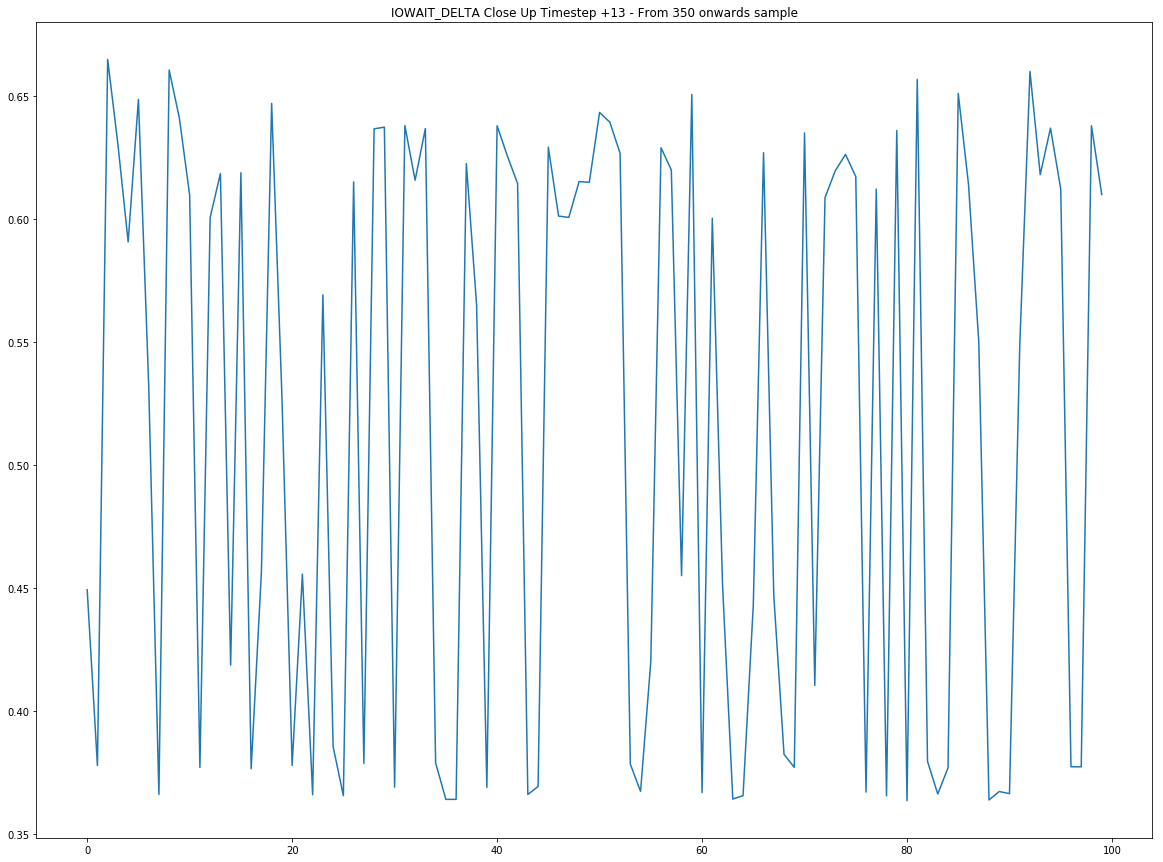

In [17]:
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=.5)
X_validate = X_validate.values
X_test = X_test.values
y_validate = y_validate.values
y_test = y_test.values
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
print("X_test shape [" + str(X_test.shape) + "] Type - " + str(type(X_test)))
print("y_test shape [" + str(y_test.shape) + "] Type - " + str(type(y_test)))

# Plotting label over time for train, test
for i in range(0, len(y_validate[0])):
  
    # Whole Sample
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot(y_train[:,i])
    validate_and_test = list(y_validate[:,i]) + list(y_test[:,i])
    plt.plot([None for j in y_train[:,i]] + [x for x in validate_and_test])
    plt.title(y_label[i%len(y_label)] + " Timestep +" + str(math.ceil((i+1)/len(y_label))))
    plt.show()
   
    # Sub-Sample (100 range)
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.plot([j for j in y_train[sub_sample_start:sub_sample_start+100,i]])
    plt.title(y_label[i%len(y_label)] + " Close Up Timestep +" + str(math.ceil((i+1)/len(y_label))) +" - From " + str(sub_sample_start) + " onwards sample")
    plt.show()

### Feature Selection

Implements a recursive solution, where in features are eliminated based on an ensemble evaluator.

In [18]:
class FeatureEliminator:
    """
    This class is dedicated to housing logic pertaining to feature selection - retaining only labels which are considered
    important.
    """
    def __init__(self, X_df, y_df):
        """
        Class constructor.
        :param X_df: (Pandas) Pandas feature matrix.
        :param y_df: (Pandas) Pandas label matrix.
        :return: None
        """
        self.__X_df = X_df
        self.__y_df = y_df
    
    def rfe_selector(self, test_split=.4, optimum_feature_count=0, parallel_degree=1, max_depth=None, max_features='sqrt', n_estimators=100):
        """
        Recursive Feature Elimination Function. Isolates and eliminated features one by one, up till the desired amount, starting
        by features which are considered less important.
        :param test_split:            (Float) Denotes training/testing data split.
        :param optimum_feature_count: (Integer) Denotes the best estimated number of features to retain before a performance drop
                                                is estimated.
        :param parallel_degree:       (Integer) Denotes model training parallel degree.
        :param max_depth:             (Integer) Denotes number of leaves to evaluate during decision tree pruning.
        :param max_features:          (Integer) Denotes number of features to consider during random subselection.
        :param n_estimators:          (Integer) Number of estimators (trees) to build for decision making.
        :return: (List) This list is composed of boolean values, which correspond to the input feature column headers. True List 
                        values denote columns which have been retained. False values denote eliminated feature headers.
        :return: (List) This list denotes feature rankings, which correspond to the input feature column headers. Values of '1',
                        denote that features have been retained.
        """
        X_df = self.__X_df.values
        y_df = self.__y_df[self.__y_df.columns[0]].values  # We can only use a single target column since RandomForests do not support multi target labels
        print(X_df.shape)
        print(y_df.shape)
        optimum_feature_count = int(optimum_feature_count)
        
        X_train, X_test, y_train, y_test = train_test_split(X_df, 
                                                            y_df, 
                                                            test_size=test_split)
        model = RandomForestRegressor(n_estimators=int(n_estimators), 
                                      n_jobs=parallel_degree,
                                      max_depth=max_depth,
                                      max_features='sqrt')

        # create the RFE model and select N attributes
        rfe_model = RFE(model, optimum_feature_count, step=1)
        rfe_model = rfe_model.fit(X_train, y_train)

        # summarize the selection of the attributes
        print(rfe_model.support_)
        print(rfe_model.ranking_)

        # evaluate the model on testing set
        pred_y = rfe_model.predict(X_test)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        
        return rfe_model.support_, rfe_model.ranking_
    
    def get_selected_features(self, column_mask):
        """
        Retrieves features which have not been eliminated from the RFE function.
        :param column_mask: (List) This list is composed of boolean values, which correspond to the input feature column headers. 
                                   True list values denote columns which have been retained. False values denote eliminated 
                                   feature headers. 
        :return: (Pandas) Pandas data matrix.
        """
        recommended_columns = []
        for i in range(len(self.__X_df.columns)):
            if (column_mask[i]):
                recommended_columns.append(self.__X_df.columns[i])
                
        return self.__X_df[recommended_columns]
    
# fe = FeatureEliminator(X_df=X_df,
#                        y_df=y_df)
# column_mask, column_rankings = fe.rfe_selector(test_split=test_split,
#                                                optimum_feature_count=int(X_df.shape[1]/8),
#                                                parallel_degree=2,
#                                                max_depth=1,
#                                                max_features='sqrt',
#                                                n_estimators=n_estimators)
# print(X_df.columns)
# X_df = fe.get_selected_features(column_mask=column_mask)
# print(X_df.columns)
recursively_eliminated_columns = ['var501(t-5)', 'var502(t-5)', 'var504(t-5)', 'var507(t-5)', 'var509(t-5)', 'var511(t-5)', 'var513(t-5)', 'var514(t-5)', 'var515(t-5)', 'var516(t-5)', 'var1(t-4)', 'var3(t-4)', 'var4(t-4)', 'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var12(t-4)', 'var13(t-4)', 'var14(t-4)', 'var15(t-4)', 'var16(t-4)', 'var17(t-4)', 'var18(t-4)', 'var19(t-4)', 'var20(t-4)', 'var22(t-4)', 'var23(t-4)', 'var24(t-4)', 'var34(t-4)', 'var36(t-4)', 'var39(t-4)', 'var40(t-4)', 'var41(t-4)', 'var42(t-4)', 'var47(t-4)', 'var48(t-4)', 'var49(t-4)', 'var50(t-4)', 'var51(t-4)', 'var52(t-4)', 'var53(t-4)', 'var54(t-4)', 'var55(t-4)', 'var62(t-4)', 'var63(t-4)', 'var64(t-4)', 'var66(t-4)', 'var67(t-4)', 'var69(t-4)', 'var70(t-4)', 'var71(t-4)', 'var74(t-4)', 'var76(t-4)', 'var77(t-4)', 'var78(t-4)', 'var79(t-4)', 'var80(t-4)', 'var81(t-4)', 'var85(t-4)', 'var86(t-4)', 'var90(t-4)', 'var91(t-4)', 'var92(t-4)', 'var93(t-4)', 'var102(t-4)', 'var104(t-4)', 'var105(t-4)', 'var112(t-4)', 'var113(t-4)', 'var114(t-4)', 'var115(t-4)', 'var117(t-4)', 'var118(t-4)', 'var120(t-4)', 'var121(t-4)', 'var122(t-4)', 'var123(t-4)', 'var124(t-4)', 'var125(t-4)', 'var126(t-4)', 'var127(t-4)', 'var128(t-4)', 'var129(t-4)', 'var130(t-4)', 'var131(t-4)', 'var132(t-4)', 'var133(t-4)', 'var134(t-4)', 'var135(t-4)', 'var136(t-4)', 'var138(t-4)', 'var139(t-4)', 'var140(t-4)', 'var141(t-4)', 'var142(t-4)', 'var143(t-4)', 'var144(t-4)', 'var145(t-4)', 'var146(t-4)', 'var147(t-4)', 'var148(t-4)', 'var149(t-4)', 'var150(t-4)', 'var151(t-4)', 'var152(t-4)', 'var153(t-4)', 'var155(t-4)', 'var156(t-4)', 'var157(t-4)', 'var158(t-4)', 'var159(t-4)', 'var160(t-4)', 'var161(t-4)', 'var162(t-4)', 'var163(t-4)', 'var164(t-4)', 'var165(t-4)', 'var166(t-4)', 'var167(t-4)', 'var168(t-4)', 'var169(t-4)', 'var170(t-4)', 'var171(t-4)', 'var172(t-4)', 'var173(t-4)', 'var174(t-4)', 'var175(t-4)', 'var176(t-4)', 'var177(t-4)', 'var178(t-4)', 'var179(t-4)', 'var180(t-4)', 'var181(t-4)', 'var182(t-4)', 'var183(t-4)', 'var184(t-4)', 'var185(t-4)', 'var186(t-4)', 'var187(t-4)', 'var188(t-4)', 'var189(t-4)', 'var190(t-4)', 'var191(t-4)', 'var192(t-4)', 'var193(t-4)', 'var194(t-4)', 'var195(t-4)', 'var196(t-4)', 'var197(t-4)', 'var198(t-4)', 'var199(t-4)', 'var200(t-4)', 'var201(t-4)', 'var202(t-4)', 'var203(t-4)', 'var204(t-4)', 'var205(t-4)', 'var206(t-4)', 'var207(t-4)', 'var208(t-4)', 'var209(t-4)', 'var210(t-4)', 'var211(t-4)', 'var212(t-4)', 'var213(t-4)', 'var214(t-4)', 'var215(t-4)', 'var220(t-4)', 'var221(t-4)', 'var222(t-4)', 'var224(t-4)', 'var225(t-4)', 'var226(t-4)', 'var227(t-4)', 'var228(t-4)', 'var229(t-4)', 'var230(t-4)', 'var231(t-4)', 'var232(t-4)', 'var233(t-4)', 'var236(t-4)', 'var237(t-4)', 'var239(t-4)', 'var240(t-4)', 'var241(t-4)', 'var244(t-4)', 'var247(t-4)', 'var248(t-4)', 'var249(t-4)', 'var250(t-4)', 'var252(t-4)', 'var254(t-4)', 'var255(t-4)', 'var256(t-4)', 'var257(t-4)', 'var258(t-4)', 'var259(t-4)', 'var260(t-4)', 'var261(t-4)', 'var264(t-4)', 'var265(t-4)', 'var266(t-4)', 'var267(t-4)', 'var268(t-4)', 'var270(t-4)', 'var271(t-4)', 'var273(t-4)', 'var274(t-4)', 'var275(t-4)', 'var276(t-4)', 'var277(t-4)', 'var278(t-4)', 'var287(t-4)', 'var289(t-4)', 'var291(t-4)', 'var292(t-4)', 'var294(t-4)', 'var297(t-4)', 'var298(t-4)', 'var299(t-4)', 'var301(t-4)', 'var302(t-4)', 'var303(t-4)', 'var304(t-4)', 'var305(t-4)', 'var306(t-4)', 'var311(t-4)', 'var312(t-4)', 'var313(t-4)', 'var316(t-4)', 'var317(t-4)', 'var318(t-4)', 'var321(t-4)', 'var322(t-4)', 'var323(t-4)', 'var324(t-4)', 'var326(t-4)', 'var327(t-4)', 'var328(t-4)', 'var331(t-4)', 'var332(t-4)', 'var333(t-4)', 'var335(t-4)', 'var336(t-4)', 'var337(t-4)', 'var338(t-4)', 'var339(t-4)', 'var341(t-4)', 'var344(t-4)', 'var348(t-4)', 'var349(t-4)', 'var355(t-4)', 'var358(t-4)', 'var359(t-4)', 'var362(t-4)', 'var363(t-4)', 'var365(t-4)', 'var366(t-4)', 'var368(t-4)', 'var369(t-4)', 'var376(t-4)', 'var377(t-4)', 'var378(t-4)', 'var379(t-4)', 'var381(t-4)', 'var382(t-4)', 'var383(t-4)', 'var384(t-4)', 'var385(t-4)', 'var386(t-4)', 'var388(t-4)', 'var389(t-4)', 'var390(t-4)', 'var393(t-4)', 'var395(t-4)', 'var397(t-4)', 'var400(t-4)', 'var401(t-4)', 'var403(t-4)', 'var404(t-4)', 'var405(t-4)', 'var407(t-4)', 'var408(t-4)', 'var409(t-4)', 'var410(t-4)', 'var411(t-4)', 'var412(t-4)', 'var413(t-4)', 'var414(t-4)', 'var415(t-4)', 'var416(t-4)', 'var417(t-4)', 'var418(t-4)', 'var419(t-4)', 'var420(t-4)', 'var421(t-4)', 'var422(t-4)', 'var423(t-4)', 'var424(t-4)', 'var425(t-4)', 'var426(t-4)', 'var427(t-4)', 'var428(t-4)', 'var429(t-4)', 'var430(t-4)', 'var431(t-4)', 'var432(t-4)', 'var433(t-4)', 'var434(t-4)', 'var435(t-4)', 'var436(t-4)', 'var437(t-4)', 'var438(t-4)', 'var439(t-4)', 'var440(t-4)', 'var441(t-4)', 'var442(t-4)', 'var443(t-4)', 'var444(t-4)', 'var445(t-4)', 'var446(t-4)', 'var447(t-4)', 'var448(t-4)', 'var449(t-4)', 'var450(t-4)', 'var451(t-4)', 'var452(t-4)', 'var453(t-4)', 'var454(t-4)', 'var455(t-4)', 'var456(t-4)', 'var457(t-4)', 'var458(t-4)', 'var459(t-4)', 'var460(t-4)', 'var461(t-4)', 'var462(t-4)', 'var463(t-4)', 'var464(t-4)', 'var465(t-4)', 'var466(t-4)', 'var467(t-4)', 'var468(t-4)', 'var469(t-4)', 'var470(t-4)', 'var471(t-4)', 'var472(t-4)', 'var473(t-4)', 'var474(t-4)', 'var475(t-4)', 'var476(t-4)', 'var477(t-4)', 'var478(t-4)', 'var479(t-4)', 'var480(t-4)', 'var481(t-4)', 'var482(t-4)', 'var483(t-4)', 'var484(t-4)', 'var485(t-4)', 'var486(t-4)', 'var487(t-4)', 'var488(t-4)', 'var489(t-4)', 'var490(t-4)', 'var491(t-4)', 'var492(t-4)', 'var493(t-4)', 'var494(t-4)', 'var495(t-4)', 'var496(t-4)', 'var497(t-4)', 'var498(t-4)', 'var499(t-4)', 'var500(t-4)', 'var501(t-4)', 'var502(t-4)', 'var503(t-4)', 'var504(t-4)', 'var505(t-4)', 'var510(t-4)', 'var511(t-4)', 'var513(t-4)', 'var514(t-4)', 'var1(t-3)', 'var2(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var10(t-3)', 'var11(t-3)', 'var14(t-3)', 'var15(t-3)', 'var17(t-3)', 'var18(t-3)', 'var25(t-3)', 'var26(t-3)', 'var28(t-3)', 'var29(t-3)', 'var30(t-3)', 'var31(t-3)', 'var32(t-3)', 'var33(t-3)', 'var34(t-3)', 'var35(t-3)', 'var41(t-3)', 'var42(t-3)', 'var44(t-3)', 'var47(t-3)', 'var50(t-3)', 'var51(t-3)', 'var53(t-3)', 'var57(t-3)', 'var62(t-3)', 'var67(t-3)', 'var68(t-3)', 'var71(t-3)', 'var77(t-3)', 'var78(t-3)', 'var79(t-3)', 'var80(t-3)', 'var81(t-3)', 'var82(t-3)', 'var83(t-3)', 'var84(t-3)', 'var85(t-3)', 'var86(t-3)', 'var89(t-3)', 'var96(t-3)', 'var97(t-3)', 'var98(t-3)', 'var101(t-3)', 'var109(t-3)', 'var110(t-3)', 'var113(t-3)', 'var115(t-3)', 'var116(t-3)', 'var117(t-3)', 'var118(t-3)', 'var125(t-3)', 'var126(t-3)', 'var127(t-3)', 'var130(t-3)', 'var131(t-3)', 'var133(t-3)', 'var134(t-3)', 'var137(t-3)', 'var139(t-3)', 'var140(t-3)', 'var142(t-3)', 'var143(t-3)', 'var144(t-3)', 'var145(t-3)', 'var146(t-3)', 'var147(t-3)', 'var149(t-3)', 'var156(t-3)', 'var157(t-3)', 'var158(t-3)', 'var159(t-3)', 'var160(t-3)', 'var161(t-3)', 'var167(t-3)', 'var168(t-3)', 'var169(t-3)', 'var170(t-3)', 'var171(t-3)', 'var172(t-3)', 'var173(t-3)', 'var175(t-3)', 'var177(t-3)', 'var179(t-3)', 'var181(t-3)', 'var182(t-3)', 'var184(t-3)', 'var187(t-3)', 'var192(t-3)', 'var194(t-3)', 'var196(t-3)', 'var197(t-3)', 'var198(t-3)', 'var199(t-3)', 'var200(t-3)', 'var202(t-3)', 'var203(t-3)', 'var204(t-3)', 'var205(t-3)', 'var206(t-3)', 'var207(t-3)', 'var208(t-3)', 'var209(t-3)', 'var210(t-3)', 'var211(t-3)', 'var212(t-3)', 'var214(t-3)', 'var215(t-3)', 'var216(t-3)', 'var217(t-3)', 'var218(t-3)', 'var219(t-3)', 'var220(t-3)', 'var221(t-3)', 'var222(t-3)', 'var223(t-3)', 'var224(t-3)', 'var225(t-3)', 'var226(t-3)', 'var227(t-3)', 'var228(t-3)', 'var229(t-3)', 'var230(t-3)', 'var231(t-3)', 'var232(t-3)', 'var234(t-3)', 'var235(t-3)', 'var236(t-3)', 'var237(t-3)', 'var238(t-3)', 'var239(t-3)', 'var240(t-3)', 'var241(t-3)', 'var242(t-3)', 'var243(t-3)', 'var244(t-3)', 'var245(t-3)', 'var246(t-3)', 'var247(t-3)', 'var248(t-3)', 'var249(t-3)', 'var250(t-3)', 'var251(t-3)', 'var252(t-3)', 'var253(t-3)', 'var254(t-3)', 'var255(t-3)', 'var256(t-3)', 'var257(t-3)', 'var258(t-3)', 'var259(t-3)', 'var260(t-3)', 'var261(t-3)', 'var262(t-3)', 'var263(t-3)', 'var264(t-3)', 'var266(t-3)', 'var267(t-3)', 'var268(t-3)', 'var269(t-3)', 'var270(t-3)', 'var271(t-3)', 'var272(t-3)', 'var273(t-3)', 'var274(t-3)', 'var275(t-3)', 'var277(t-3)', 'var278(t-3)', 'var279(t-3)', 'var280(t-3)', 'var281(t-3)', 'var282(t-3)', 'var283(t-3)', 'var284(t-3)', 'var285(t-3)', 'var286(t-3)', 'var287(t-3)', 'var288(t-3)', 'var289(t-3)', 'var290(t-3)', 'var292(t-3)', 'var293(t-3)', 'var294(t-3)', 'var300(t-3)', 'var301(t-3)', 'var306(t-3)', 'var309(t-3)', 'var310(t-3)', 'var311(t-3)', 'var312(t-3)', 'var313(t-3)', 'var315(t-3)', 'var317(t-3)', 'var318(t-3)', 'var319(t-3)', 'var320(t-3)', 'var321(t-3)', 'var322(t-3)', 'var323(t-3)', 'var326(t-3)', 'var335(t-3)', 'var336(t-3)', 'var337(t-3)', 'var338(t-3)', 'var339(t-3)', 'var340(t-3)', 'var342(t-3)', 'var343(t-3)', 'var346(t-3)', 'var347(t-3)', 'var349(t-3)', 'var352(t-3)', 'var353(t-3)', 'var355(t-3)', 'var357(t-3)', 'var359(t-3)', 'var364(t-3)', 'var365(t-3)', 'var366(t-3)', 'var367(t-3)', 'var374(t-3)', 'var376(t-3)', 'var377(t-3)', 'var378(t-3)', 'var379(t-3)', 'var382(t-3)', 'var383(t-3)', 'var384(t-3)', 'var385(t-3)', 'var386(t-3)', 'var387(t-3)', 'var389(t-3)', 'var391(t-3)', 'var397(t-3)', 'var398(t-3)', 'var399(t-3)', 'var401(t-3)', 'var402(t-3)', 'var418(t-3)', 'var419(t-3)', 'var421(t-3)', 'var423(t-3)', 'var424(t-3)', 'var425(t-3)', 'var427(t-3)', 'var428(t-3)', 'var429(t-3)', 'var430(t-3)', 'var432(t-3)', 'var436(t-3)', 'var437(t-3)', 'var438(t-3)', 'var439(t-3)', 'var441(t-3)', 'var444(t-3)', 'var445(t-3)', 'var446(t-3)', 'var447(t-3)', 'var450(t-3)', 'var451(t-3)', 'var452(t-3)', 'var454(t-3)', 'var455(t-3)', 'var456(t-3)', 'var457(t-3)', 'var458(t-3)', 'var462(t-3)', 'var463(t-3)', 'var464(t-3)', 'var469(t-3)', 'var471(t-3)', 'var472(t-3)', 'var474(t-3)', 'var475(t-3)', 'var476(t-3)', 'var478(t-3)', 'var481(t-3)', 'var484(t-3)', 'var485(t-3)', 'var489(t-3)', 'var490(t-3)', 'var491(t-3)', 'var492(t-3)', 'var494(t-3)', 'var496(t-3)', 'var497(t-3)', 'var498(t-3)', 'var499(t-3)', 'var500(t-3)', 'var501(t-3)', 'var502(t-3)', 'var503(t-3)', 'var504(t-3)', 'var505(t-3)', 'var506(t-3)', 'var507(t-3)', 'var508(t-3)', 'var509(t-3)', 'var510(t-3)', 'var511(t-3)', 'var512(t-3)', 'var513(t-3)', 'var514(t-3)', 'var515(t-3)', 'var516(t-3)', 'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var12(t-2)', 'var13(t-2)', 'var15(t-2)', 'var16(t-2)', 'var17(t-2)', 'var18(t-2)', 'var19(t-2)', 'var21(t-2)', 'var22(t-2)', 'var23(t-2)', 'var24(t-2)', 'var26(t-2)', 'var27(t-2)', 'var29(t-2)', 'var30(t-2)', 'var31(t-2)', 'var32(t-2)', 'var33(t-2)', 'var35(t-2)', 'var36(t-2)', 'var37(t-2)', 'var39(t-2)', 'var40(t-2)', 'var41(t-2)', 'var42(t-2)', 'var44(t-2)', 'var45(t-2)', 'var46(t-2)', 'var48(t-2)', 'var49(t-2)', 'var50(t-2)', 'var51(t-2)', 'var53(t-2)', 'var54(t-2)', 'var74(t-2)', 'var75(t-2)', 'var77(t-2)', 'var79(t-2)', 'var80(t-2)', 'var81(t-2)', 'var83(t-2)', 'var84(t-2)', 'var85(t-2)', 'var86(t-2)', 'var99(t-2)', 'var100(t-2)', 'var101(t-2)', 'var102(t-2)', 'var105(t-2)', 'var155(t-2)', 'var158(t-2)', 'var159(t-2)', 'var168(t-2)', 'var169(t-2)', 'var171(t-2)', 'var172(t-2)', 'var173(t-2)', 'var184(t-2)', 'var186(t-2)', 'var187(t-2)', 'var188(t-2)', 'var190(t-2)', 'var191(t-2)', 'var194(t-2)', 'var195(t-2)', 'var196(t-2)', 'var198(t-2)', 'var199(t-2)', 'var201(t-2)', 'var202(t-2)', 'var207(t-2)', 'var213(t-2)', 'var214(t-2)', 'var216(t-2)', 'var217(t-2)', 'var228(t-2)', 'var231(t-2)', 'var237(t-2)', 'var238(t-2)', 'var239(t-2)', 'var241(t-2)', 'var243(t-2)', 'var254(t-2)', 'var255(t-2)', 'var256(t-2)', 'var259(t-2)', 'var260(t-2)', 'var261(t-2)', 'var263(t-2)', 'var264(t-2)', 'var265(t-2)', 'var266(t-2)', 'var268(t-2)', 'var269(t-2)', 'var270(t-2)', 'var272(t-2)', 'var273(t-2)', 'var274(t-2)', 'var275(t-2)', 'var276(t-2)', 'var277(t-2)', 'var278(t-2)', 'var279(t-2)', 'var280(t-2)', 'var281(t-2)', 'var282(t-2)', 'var284(t-2)', 'var285(t-2)', 'var286(t-2)', 'var287(t-2)', 'var288(t-2)', 'var289(t-2)', 'var290(t-2)', 'var291(t-2)', 'var292(t-2)', 'var293(t-2)', 'var295(t-2)', 'var296(t-2)', 'var297(t-2)', 'var298(t-2)', 'var299(t-2)', 'var300(t-2)', 'var301(t-2)', 'var302(t-2)', 'var303(t-2)', 'var304(t-2)', 'var305(t-2)', 'var306(t-2)', 'var307(t-2)', 'var308(t-2)', 'var309(t-2)', 'var310(t-2)', 'var311(t-2)', 'var312(t-2)', 'var313(t-2)', 'var314(t-2)', 'var315(t-2)', 'var316(t-2)', 'var317(t-2)', 'var318(t-2)', 'var319(t-2)', 'var320(t-2)', 'var321(t-2)', 'var322(t-2)', 'var323(t-2)', 'var324(t-2)', 'var325(t-2)', 'var326(t-2)', 'var327(t-2)', 'var328(t-2)', 'var329(t-2)', 'var330(t-2)', 'var331(t-2)', 'var333(t-2)', 'var334(t-2)', 'var335(t-2)', 'var336(t-2)', 'var337(t-2)', 'var350(t-2)', 'var364(t-2)', 'var367(t-2)', 'var368(t-2)', 'var369(t-2)', 'var376(t-2)', 'var377(t-2)', 'var378(t-2)', 'var379(t-2)', 'var380(t-2)', 'var382(t-2)', 'var387(t-2)', 'var389(t-2)', 'var390(t-2)', 'var391(t-2)', 'var392(t-2)', 'var393(t-2)', 'var396(t-2)', 'var397(t-2)', 'var415(t-2)', 'var423(t-2)', 'var440(t-2)', 'var441(t-2)', 'var442(t-2)', 'var445(t-2)', 'var466(t-2)', 'var476(t-2)', 'var480(t-2)', 'var481(t-2)', 'var482(t-2)', 'var487(t-2)', 'var488(t-2)', 'var489(t-2)', 'var497(t-2)', 'var498(t-2)', 'var499(t-2)', 'var500(t-2)', 'var502(t-2)', 'var503(t-2)', 'var505(t-2)', 'var507(t-2)', 'var508(t-2)', 'var509(t-2)', 'var510(t-2)', 'var511(t-2)', 'var512(t-2)', 'var513(t-2)', 'var514(t-2)', 'var515(t-2)', 'var516(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)', 'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)', 'var21(t-1)', 'var22(t-1)', 'var23(t-1)', 'var24(t-1)', 'var25(t-1)', 'var26(t-1)', 'var27(t-1)', 'var28(t-1)', 'var29(t-1)', 'var30(t-1)', 'var31(t-1)', 'var32(t-1)', 'var33(t-1)', 'var34(t-1)', 'var35(t-1)', 'var36(t-1)', 'var37(t-1)', 'var38(t-1)', 'var39(t-1)', 'var40(t-1)', 'var41(t-1)', 'var42(t-1)', 'var43(t-1)', 'var44(t-1)', 'var45(t-1)', 'var46(t-1)', 'var47(t-1)', 'var48(t-1)', 'var49(t-1)', 'var50(t-1)', 'var51(t-1)', 'var52(t-1)', 'var53(t-1)', 'var54(t-1)', 'var55(t-1)', 'var56(t-1)', 'var57(t-1)', 'var58(t-1)', 'var59(t-1)', 'var60(t-1)', 'var61(t-1)', 'var62(t-1)', 'var63(t-1)', 'var64(t-1)', 'var65(t-1)', 'var66(t-1)', 'var67(t-1)', 'var68(t-1)', 'var69(t-1)', 'var70(t-1)', 'var71(t-1)', 'var72(t-1)', 'var73(t-1)', 'var74(t-1)', 'var75(t-1)', 'var76(t-1)', 'var77(t-1)', 'var78(t-1)', 'var79(t-1)', 'var80(t-1)', 'var81(t-1)', 'var82(t-1)', 'var83(t-1)', 'var84(t-1)', 'var85(t-1)', 'var86(t-1)', 'var87(t-1)', 'var88(t-1)', 'var89(t-1)', 'var90(t-1)', 'var91(t-1)', 'var92(t-1)', 'var93(t-1)', 'var94(t-1)', 'var95(t-1)', 'var96(t-1)', 'var97(t-1)', 'var98(t-1)', 'var99(t-1)', 'var100(t-1)', 'var101(t-1)', 'var102(t-1)', 'var103(t-1)', 'var104(t-1)', 'var105(t-1)', 'var106(t-1)', 'var107(t-1)', 'var108(t-1)', 'var109(t-1)', 'var110(t-1)', 'var111(t-1)', 'var112(t-1)', 'var113(t-1)', 'var114(t-1)', 'var115(t-1)', 'var116(t-1)', 'var117(t-1)', 'var118(t-1)', 'var119(t-1)', 'var120(t-1)', 'var121(t-1)', 'var122(t-1)', 'var123(t-1)', 'var124(t-1)', 'var125(t-1)', 'var126(t-1)', 'var127(t-1)', 'var128(t-1)', 'var129(t-1)', 'var130(t-1)', 'var131(t-1)', 'var132(t-1)', 'var133(t-1)', 'var134(t-1)', 'var135(t-1)', 'var136(t-1)', 'var137(t-1)', 'var138(t-1)', 'var139(t-1)', 'var140(t-1)', 'var141(t-1)', 'var142(t-1)', 'var143(t-1)', 'var144(t-1)', 'var145(t-1)', 'var146(t-1)', 'var147(t-1)', 'var148(t-1)', 'var149(t-1)', 'var150(t-1)', 'var151(t-1)', 'var152(t-1)', 'var153(t-1)', 'var154(t-1)', 'var155(t-1)', 'var156(t-1)', 'var157(t-1)', 'var158(t-1)', 'var159(t-1)', 'var160(t-1)', 'var161(t-1)', 'var162(t-1)', 'var163(t-1)', 'var164(t-1)', 'var165(t-1)', 'var166(t-1)', 'var167(t-1)', 'var168(t-1)', 'var169(t-1)', 'var170(t-1)', 'var171(t-1)', 'var172(t-1)', 'var173(t-1)', 'var174(t-1)', 'var175(t-1)', 'var176(t-1)', 'var177(t-1)', 'var178(t-1)', 'var179(t-1)', 'var180(t-1)', 'var181(t-1)', 'var182(t-1)', 'var183(t-1)', 'var184(t-1)', 'var185(t-1)', 'var186(t-1)', 'var187(t-1)', 'var188(t-1)', 'var189(t-1)', 'var190(t-1)', 'var191(t-1)', 'var192(t-1)', 'var193(t-1)', 'var194(t-1)', 'var195(t-1)', 'var196(t-1)', 'var197(t-1)', 'var198(t-1)', 'var199(t-1)', 'var200(t-1)', 'var201(t-1)', 'var202(t-1)', 'var203(t-1)', 'var204(t-1)', 'var205(t-1)', 'var206(t-1)', 'var207(t-1)', 'var208(t-1)', 'var209(t-1)', 'var210(t-1)', 'var211(t-1)', 'var212(t-1)', 'var213(t-1)', 'var214(t-1)', 'var215(t-1)', 'var216(t-1)', 'var217(t-1)', 'var218(t-1)', 'var219(t-1)', 'var220(t-1)', 'var221(t-1)', 'var222(t-1)', 'var223(t-1)', 'var224(t-1)', 'var225(t-1)', 'var226(t-1)', 'var227(t-1)', 'var228(t-1)', 'var229(t-1)', 'var230(t-1)', 'var231(t-1)', 'var232(t-1)', 'var233(t-1)', 'var234(t-1)', 'var235(t-1)', 'var236(t-1)', 'var237(t-1)', 'var238(t-1)', 'var239(t-1)', 'var240(t-1)', 'var241(t-1)', 'var242(t-1)', 'var243(t-1)', 'var244(t-1)', 'var245(t-1)', 'var246(t-1)', 'var247(t-1)', 'var248(t-1)', 'var249(t-1)', 'var250(t-1)', 'var251(t-1)', 'var252(t-1)', 'var253(t-1)', 'var254(t-1)', 'var255(t-1)', 'var256(t-1)', 'var257(t-1)', 'var258(t-1)', 'var259(t-1)', 'var260(t-1)', 'var261(t-1)', 'var262(t-1)', 'var263(t-1)', 'var264(t-1)', 'var265(t-1)', 'var266(t-1)', 'var267(t-1)', 'var268(t-1)', 'var269(t-1)', 'var270(t-1)', 'var271(t-1)', 'var272(t-1)', 'var273(t-1)', 'var274(t-1)', 'var275(t-1)', 'var276(t-1)', 'var277(t-1)', 'var278(t-1)', 'var279(t-1)', 'var280(t-1)', 'var281(t-1)', 'var282(t-1)', 'var283(t-1)', 'var284(t-1)', 'var285(t-1)', 'var286(t-1)', 'var287(t-1)', 'var288(t-1)', 'var289(t-1)', 'var290(t-1)', 'var291(t-1)', 'var292(t-1)', 'var293(t-1)', 'var294(t-1)', 'var295(t-1)', 'var296(t-1)', 'var297(t-1)', 'var298(t-1)', 'var299(t-1)', 'var300(t-1)', 'var301(t-1)', 'var302(t-1)', 'var303(t-1)', 'var304(t-1)', 'var305(t-1)', 'var306(t-1)', 'var307(t-1)', 'var308(t-1)', 'var309(t-1)', 'var310(t-1)', 'var311(t-1)', 'var312(t-1)', 'var313(t-1)', 'var314(t-1)', 'var315(t-1)', 'var316(t-1)', 'var317(t-1)', 'var318(t-1)', 'var319(t-1)', 'var320(t-1)', 'var321(t-1)', 'var322(t-1)', 'var323(t-1)', 'var324(t-1)', 'var325(t-1)', 'var326(t-1)', 'var327(t-1)', 'var328(t-1)', 'var329(t-1)', 'var330(t-1)', 'var331(t-1)', 'var332(t-1)', 'var333(t-1)', 'var334(t-1)', 'var335(t-1)', 'var336(t-1)', 'var337(t-1)', 'var338(t-1)', 'var339(t-1)', 'var340(t-1)', 'var341(t-1)', 'var342(t-1)', 'var343(t-1)', 'var344(t-1)', 'var345(t-1)', 'var346(t-1)', 'var347(t-1)', 'var348(t-1)', 'var349(t-1)', 'var350(t-1)', 'var351(t-1)', 'var352(t-1)', 'var353(t-1)', 'var354(t-1)', 'var355(t-1)', 'var356(t-1)', 'var357(t-1)', 'var358(t-1)', 'var359(t-1)', 'var360(t-1)', 'var361(t-1)', 'var362(t-1)', 'var363(t-1)', 'var364(t-1)', 'var365(t-1)', 'var366(t-1)', 'var367(t-1)', 'var368(t-1)', 'var369(t-1)', 'var370(t-1)', 'var371(t-1)', 'var372(t-1)', 'var373(t-1)', 'var374(t-1)', 'var375(t-1)', 'var376(t-1)', 'var377(t-1)', 'var378(t-1)', 'var379(t-1)', 'var380(t-1)', 'var381(t-1)', 'var382(t-1)', 'var383(t-1)', 'var384(t-1)', 'var385(t-1)', 'var386(t-1)', 'var387(t-1)', 'var388(t-1)', 'var389(t-1)', 'var390(t-1)', 'var391(t-1)', 'var392(t-1)', 'var393(t-1)', 'var394(t-1)', 'var395(t-1)', 'var396(t-1)', 'var397(t-1)', 'var398(t-1)', 'var399(t-1)', 'var400(t-1)', 'var401(t-1)', 'var402(t-1)', 'var403(t-1)', 'var404(t-1)', 'var405(t-1)', 'var406(t-1)', 'var407(t-1)', 'var408(t-1)', 'var409(t-1)', 'var410(t-1)', 'var411(t-1)', 'var412(t-1)', 'var413(t-1)', 'var414(t-1)', 'var415(t-1)', 'var416(t-1)', 'var417(t-1)', 'var418(t-1)', 'var419(t-1)', 'var420(t-1)', 'var421(t-1)', 'var422(t-1)', 'var423(t-1)', 'var424(t-1)', 'var425(t-1)', 'var426(t-1)', 'var427(t-1)', 'var428(t-1)', 'var429(t-1)', 'var430(t-1)', 'var431(t-1)', 'var432(t-1)', 'var433(t-1)', 'var434(t-1)', 'var435(t-1)', 'var436(t-1)', 'var437(t-1)', 'var438(t-1)', 'var439(t-1)', 'var440(t-1)', 'var441(t-1)', 'var442(t-1)', 'var443(t-1)', 'var444(t-1)', 'var445(t-1)', 'var446(t-1)', 'var447(t-1)', 'var448(t-1)', 'var449(t-1)', 'var450(t-1)', 'var451(t-1)', 'var452(t-1)', 'var453(t-1)', 'var454(t-1)', 'var455(t-1)', 'var456(t-1)', 'var457(t-1)', 'var458(t-1)', 'var459(t-1)', 'var460(t-1)', 'var461(t-1)', 'var462(t-1)', 'var463(t-1)', 'var464(t-1)', 'var465(t-1)', 'var466(t-1)', 'var467(t-1)', 'var468(t-1)', 'var469(t-1)', 'var470(t-1)', 'var471(t-1)', 'var472(t-1)', 'var473(t-1)', 'var474(t-1)', 'var475(t-1)', 'var476(t-1)', 'var477(t-1)', 'var478(t-1)', 'var479(t-1)', 'var480(t-1)', 'var481(t-1)', 'var482(t-1)', 'var483(t-1)', 'var484(t-1)', 'var485(t-1)', 'var486(t-1)', 'var487(t-1)', 'var488(t-1)', 'var489(t-1)', 'var490(t-1)', 'var491(t-1)', 'var492(t-1)', 'var493(t-1)', 'var494(t-1)', 'var495(t-1)', 'var496(t-1)', 'var497(t-1)', 'var498(t-1)', 'var499(t-1)', 'var500(t-1)', 'var501(t-1)', 'var502(t-1)', 'var503(t-1)', 'var504(t-1)', 'var505(t-1)', 'var507(t-1)', 'var508(t-1)', 'var509(t-1)', 'var510(t-1)', 'var511(t-1)', 'var512(t-1)', 'var513(t-1)', 'var514(t-1)', 'var515(t-1)', 'var516(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'var12(t)', 'var13(t)', 'var14(t)', 'var15(t)', 'var16(t)', 'var17(t)', 'var18(t)', 'var19(t)', 'var20(t)', 'var21(t)', 'var22(t)', 'var23(t)', 'var24(t)', 'var25(t)', 'var26(t)', 'var27(t)', 'var28(t)', 'var29(t)', 'var30(t)', 'var31(t)', 'var32(t)', 'var33(t)', 'var34(t)', 'var35(t)', 'var36(t)', 'var37(t)', 'var38(t)', 'var39(t)', 'var40(t)', 'var41(t)', 'var42(t)', 'var43(t)', 'var44(t)', 'var45(t)', 'var46(t)', 'var47(t)', 'var48(t)', 'var49(t)', 'var50(t)', 'var51(t)', 'var52(t)', 'var53(t)', 'var54(t)', 'var55(t)', 'var56(t)', 'var57(t)', 'var58(t)', 'var59(t)', 'var60(t)', 'var61(t)', 'var62(t)', 'var63(t)', 'var64(t)', 'var65(t)', 'var66(t)', 'var67(t)', 'var68(t)', 'var69(t)', 'var70(t)', 'var71(t)', 'var72(t)', 'var73(t)', 'var75(t)', 'var76(t)', 'var77(t)', 'var78(t)', 'var79(t)', 'var80(t)', 'var81(t)', 'var82(t)', 'var83(t)', 'var84(t)', 'var85(t)', 'var86(t)', 'var87(t)', 'var88(t)', 'var89(t)', 'var90(t)', 'var91(t)', 'var92(t)', 'var93(t)', 'var94(t)', 'var95(t)', 'var96(t)', 'var97(t)', 'var98(t)', 'var99(t)', 'var100(t)', 'var101(t)', 'var102(t)', 'var103(t)', 'var104(t)', 'var105(t)', 'var106(t)', 'var107(t)', 'var108(t)', 'var109(t)', 'var110(t)', 'var111(t)', 'var112(t)', 'var113(t)', 'var114(t)', 'var115(t)', 'var116(t)', 'var117(t)', 'var118(t)', 'var119(t)', 'var120(t)', 'var121(t)', 'var122(t)', 'var123(t)', 'var124(t)', 'var125(t)', 'var126(t)', 'var127(t)', 'var128(t)', 'var129(t)', 'var130(t)', 'var131(t)', 'var132(t)', 'var133(t)', 'var134(t)', 'var135(t)', 'var136(t)', 'var137(t)', 'var138(t)', 'var139(t)', 'var140(t)', 'var141(t)', 'var142(t)', 'var143(t)', 'var145(t)', 'var146(t)', 'var147(t)', 'var148(t)', 'var149(t)', 'var150(t)', 'var152(t)', 'var153(t)', 'var154(t)', 'var155(t)', 'var156(t)', 'var157(t)', 'var158(t)', 'var159(t)', 'var160(t)', 'var161(t)', 'var162(t)', 'var163(t)', 'var164(t)', 'var165(t)', 'var166(t)', 'var167(t)', 'var168(t)', 'var169(t)', 'var170(t)', 'var171(t)', 'var172(t)', 'var173(t)', 'var174(t)', 'var175(t)', 'var176(t)', 'var177(t)', 'var178(t)', 'var179(t)', 'var180(t)', 'var181(t)', 'var182(t)', 'var183(t)', 'var184(t)', 'var185(t)', 'var186(t)', 'var187(t)', 'var188(t)', 'var189(t)', 'var190(t)', 'var191(t)', 'var192(t)', 'var193(t)', 'var194(t)', 'var195(t)', 'var196(t)', 'var197(t)', 'var198(t)', 'var199(t)', 'var200(t)', 'var201(t)', 'var202(t)', 'var203(t)', 'var204(t)', 'var205(t)', 'var206(t)', 'var207(t)', 'var208(t)', 'var209(t)', 'var210(t)', 'var211(t)', 'var212(t)', 'var213(t)', 'var214(t)', 'var215(t)', 'var216(t)', 'var217(t)', 'var218(t)', 'var219(t)', 'var220(t)', 'var221(t)', 'var222(t)', 'var223(t)', 'var224(t)', 'var225(t)', 'var226(t)', 'var227(t)', 'var228(t)', 'var229(t)', 'var230(t)', 'var231(t)', 'var232(t)', 'var233(t)', 'var234(t)', 'var235(t)', 'var236(t)', 'var237(t)', 'var238(t)', 'var239(t)', 'var240(t)', 'var241(t)', 'var242(t)', 'var243(t)', 'var244(t)', 'var245(t)', 'var246(t)', 'var247(t)', 'var248(t)', 'var249(t)', 'var250(t)', 'var251(t)', 'var252(t)', 'var253(t)', 'var254(t)', 'var255(t)', 'var256(t)', 'var257(t)', 'var259(t)', 'var260(t)', 'var261(t)', 'var262(t)', 'var263(t)', 'var264(t)', 'var265(t)', 'var267(t)', 'var268(t)', 'var269(t)', 'var270(t)', 'var271(t)', 'var272(t)', 'var273(t)', 'var274(t)', 'var275(t)', 'var276(t)', 'var277(t)', 'var278(t)', 'var279(t)', 'var280(t)', 'var281(t)', 'var282(t)', 'var283(t)', 'var284(t)', 'var285(t)', 'var286(t)', 'var287(t)', 'var288(t)', 'var289(t)', 'var290(t)', 'var291(t)', 'var292(t)', 'var293(t)', 'var294(t)', 'var295(t)', 'var296(t)', 'var297(t)', 'var298(t)', 'var299(t)', 'var300(t)', 'var301(t)', 'var302(t)', 'var303(t)', 'var304(t)', 'var305(t)', 'var306(t)', 'var307(t)', 'var308(t)', 'var309(t)', 'var310(t)', 'var311(t)', 'var312(t)', 'var313(t)', 'var314(t)', 'var315(t)', 'var316(t)', 'var317(t)', 'var318(t)', 'var319(t)', 'var320(t)', 'var321(t)', 'var322(t)', 'var323(t)', 'var324(t)', 'var325(t)', 'var326(t)', 'var327(t)', 'var328(t)', 'var329(t)', 'var330(t)', 'var331(t)', 'var332(t)', 'var333(t)', 'var334(t)', 'var335(t)', 'var336(t)', 'var337(t)', 'var338(t)', 'var339(t)', 'var340(t)', 'var342(t)', 'var343(t)', 'var344(t)', 'var345(t)', 'var346(t)', 'var347(t)', 'var348(t)', 'var349(t)', 'var350(t)', 'var351(t)', 'var352(t)', 'var353(t)', 'var354(t)', 'var355(t)', 'var356(t)', 'var357(t)', 'var358(t)', 'var359(t)', 'var360(t)', 'var361(t)', 'var362(t)', 'var363(t)', 'var364(t)', 'var365(t)', 'var366(t)', 'var367(t)', 'var368(t)', 'var369(t)', 'var370(t)', 'var371(t)', 'var372(t)', 'var373(t)', 'var374(t)', 'var375(t)', 'var376(t)', 'var377(t)', 'var378(t)', 'var379(t)', 'var380(t)', 'var381(t)', 'var382(t)', 'var383(t)', 'var384(t)', 'var385(t)']
X_df = X_df[recursively_eliminated_columns]

### Value Decomposition

Principal component analysis: Factor model in which the factors are based on summarizing the total variance. With PCA, unities are used in the diagonal of the correlation matrix computationally implying that all the variance is common or shared.

https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

    var501(t-5)  var502(t-5)  var504(t-5)  var507(t-5)  var509(t-5)  \
12     0.097348     0.984640     0.132293     0.129590     0.145931   
13     0.385216     0.992120     0.555809     0.509552     0.579180   
14     0.423168     0.992549     0.558283     0.544674     0.613367   
15     0.386427     0.992126     0.555809     0.511125     0.581365   
16     0.704013     0.995937     0.706558     0.765295     0.800177   

    var511(t-5)  var513(t-5)  var514(t-5)  var515(t-5)  var516(t-5)  \
12     0.145474     0.112587     0.000000     0.080247     0.999892   
13     0.572666     0.467456     0.028489     0.487654     0.999935   
14     0.609017     0.500663     0.003728     0.487654     0.999940   
15     0.573873     0.468734     0.013109     0.487654     0.999935   
16     0.799929     0.737769     0.000000     0.703704     0.999977   

      ...      var376(t)  var377(t)  var378(t)  var379(t)  var380(t)  \
12    ...       0.991297   0.006271   0.014216   0.005060   0.008294   
13

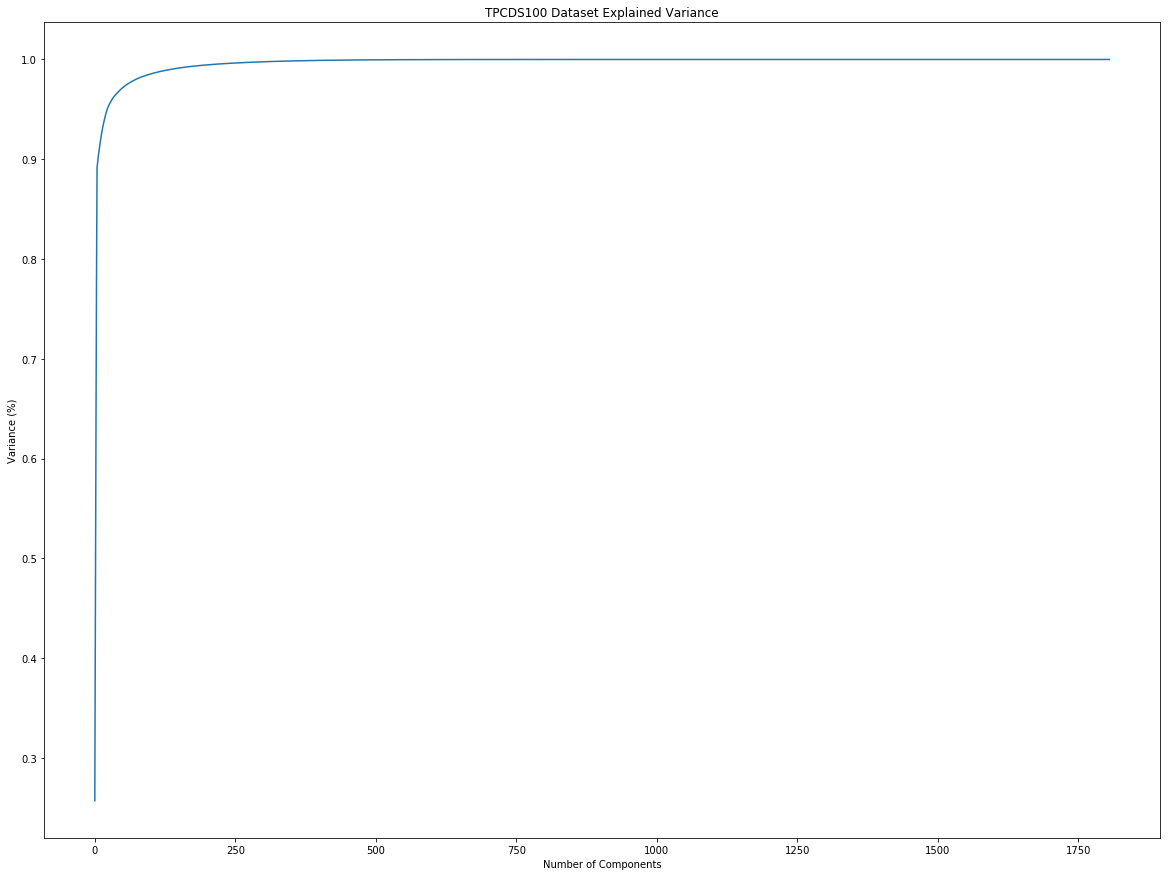

------------------------------
   Component_0  Component_1  Component_2  Component_3  Component_4  \
0    -3.424521     1.499234     0.037402     7.197860     0.734260   
1     9.350525     0.404161     1.240316    -4.756271    -2.240849   
2    -5.999859     0.632041    -2.375426    -5.302183     6.357776   
3    -6.308394    -2.602926     7.257870     6.770633    -4.057384   
4     7.634575     8.145926    -4.907078    -0.015407    -4.359670   

   Component_5  Component_6  Component_7  Component_8  Component_9  \
0     1.168779     0.110166    -0.332391    -0.720633    -1.041240   
1     0.063589     1.273496     0.341650    -0.076658    -0.705056   
2     0.069009     0.584599     0.447319    -0.370936    -0.470099   
3     0.151817     0.716504     0.647205    -1.072696     0.356649   
4    -0.477335     0.894722    -1.174477     0.652911     0.601735   

       ...        Component_125  Component_126  Component_127  Component_128  \
0      ...             0.093888      -0.102577 

In [19]:
class PrincipalComponentAnalysisClass:
    """
    This class handles logic related to PCA data transformations.
    https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
    """
    def __init__(self, X_df):
        """
        Cosntructor method.
        :param X_df: (Pandas) Dataframe consisting of input features, which will be subject to PCA.
        :return: None
        """
        self.__X_df = X_df
        
    def get_default_component_variances(self):
        """
        Fitting the PCA algorithm with our Data.
        :return: (Numpy array) Array of feature variances.
        """
        pca = PCA().fit(self.__X_df.values)
        return np.cumsum(pca.explained_variance_ratio_)
        
    def get_default_component_count(self, threshold=.99):
        """
        Retrieves the recommended number of component decomposition, above which very little variance 
        gain is achieved. This treshold will be set at a 0.999 variance threshold.
        :param threshold: (Float) Threshold value between 0 and 1. Stops immediately as soon the number
                                  of required components exceeds the threshold value.
        :return: (Integer) Returns the number of recommended components.
        """
        variance_ratios = self.get_default_component_variances()
        n = 0
        for val in variance_ratios:
            if val < threshold:
                n += 1
        return n
    
    def plot_variance_per_reduction(self):
        """
        This method subjects the feature matrix to a PCA decomposition. The number of components is plot
        vs the amount of retained variance.
        :return: None
        """
        variance_ratios = self.get_default_component_variances()
        
        #Plotting the Cumulative Summation of the Explained Variance
        plt.figure()
        plt.plot(variance_ratios)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance (%)') #for each component
        plt.title(tpcds + ' Dataset Explained Variance')
        plt.show()
        
    def apply_PCA(self, n_components):
        """
        Applies Principle Component Analysis on the constructor passed data matrix, on a number of components.
        A new pandas data matrix is returned, with renamed 'Principal Component' headers.
        :param n_components: (Integer) Denotes number of component breakdown.
        :return: (Pandas) Dataframe consisting of new decomposed components.
        """
        pca = PCA(n_components=n_components)
        dataset = pca.fit_transform(self.__X_df.values)
        header_list = []
        for i in range(dataset.shape[1]):
            header_list.append('Component_' + str(i))
        return pd.DataFrame(data=dataset, columns=header_list)

print(X_df.head())
print(X_df.shape)

pcac = PrincipalComponentAnalysisClass(X_df=X_df)
pcac.plot_variance_per_reduction()
component_count = pcac.get_default_component_count()
X_df = pcac.apply_PCA(n_components=component_count)

print('-'*30)
print(X_df.head())
print(X_df.shape)

## Neural Network (Keras + Tensorflow backend)
### Designing the network

- The first step is to define your network.
- Neural networks are defined in Keras as a sequence of layers. The container for these layers is the **Sequential class**.
- The first step is to create an instance of the Sequential class. Then you can create your layers and add them in the order that they should be connected.
- This experiment assumes a classical Feed Forward Network.

### Relavent Links

Network structure pointers [https://www.heatonresearch.com/2017/06/01/hidden-layers.html]. Rough heuristics to start with:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

--------------------------------------------------------------------------------------------

* https://machinelearningmastery.com/models-sequence-prediction-recurrent-neural-networks/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
* https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/
* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
* https://arxiv.org/pdf/1312.6026.pdf
* https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
* https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

In [20]:
# NeuralNet Class
class NeuralNet:
    """
    NeuralNet Class
    """

    def __init__(self, X, y, lag, loss_func, activation, optimizer='sgd', layers=1, dropout=.0,
                 y_labels=None, initializer='uniform'):
        """
        Initiating the class creates a net with the established parameters
        :param X             - (Numpy 2D Array) Training data used to train the model (Features).
        :param y             - (Numpy 2D Array) Test data used to test the model (Labels
        :param lag           - (Integer) Denotes lag step value
        :param loss_function - (String)  Denotes mode of measure fitting of model (Fitting function).
        :param activation    - (String)  Neuron activation function used to activate/trigger neurons.
        :param optimizer     - (String)  Denotes which function to us to optimize the model build (eg: Gradient Descent).
        :param layers        - (Integer) Denotes the number of Neuron layers to be included in the model build.
        :param dropout       - (Float)   Denotes amount of dropout for model. This parameter must be a value between 0 and 1.
        :param: y_labels     - (List)    List of target label names.
        :param: initializer  - (String)  String initializer which denotes starting weights.
        """
        self.__lag = lag
        self.__model = ke.models.Sequential()
        self.__y_labels = y_labels

        if dropout > 1 and dropout < 0:
            raise ValueError('Dropout parameter exceeded! Must be a value between 0 and 1.')

        for i in range(0, layers):
            self.__model.add(ke.layers.Dense(X.shape[1],
                                             kernel_initializer=initializer,
                                             activation=activation,
                                             input_shape=(X.shape[1],)))
            self.__model.add(ke.layers.Dropout(dropout))
        self.__model.add(ke.layers.Dense(X.shape[1],
                                         kernel_initializer=initializer,
                                         activation=activation,
                                         input_shape=(X.shape[1],)))
        self.__model.add(ke.layers.Dropout(dropout))

        self.__model.add(ke.layers.Dense(y.shape[1],
                                         kernel_initializer=initializer,
                                         activation='sigmoid'))
        self.__model.compile(loss=loss_func, optimizer=optimizer, metrics=['mse','mae'])
        print(self.__model.summary())

    def fit_model(self, X_train=None, X_test=None, y_train=None, y_test=None, epochs=50, batch_size=50, verbose=2,
                  shuffle=False, plot=False):
        """
        Fit data to model & validate. Trains a number of epochs.

        :param: X_train    - (Numpy 2D Array) Numpy matrix consisting of input training features
        :param: X_test     - (Numpy 2D Array) Numpy matrix consisting of input validation/testing features
        :param: y_train    - (Numpy 2D Array) Numpy matrix consisting of output training labels
        :param: y_test     - (Numpy 2D Array) Numpy matrix consisting of output validation/testing labels
        :param: epochs     - (Integer) Integer value denoting number of trained epochs
        :param: verbose    - (Integer) Integer value denoting net verbosity (Amount of information shown to user during NeuralNet training)
        :param: shuffle    - (Bool) Boolean value denoting whether or not to shuffle data. This parameter must always remain 'False' for time series datasets.
        :param: plot       - (Bool) Boolean value denoting whether this function should plot out it's evaluation

        :return: None
        """
        if X_test is not None and y_test is not None:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       validation_data=(X_test, y_test),
                                       verbose=verbose,
                                       shuffle=shuffle)
        else:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       verbose=verbose,
                                       shuffle=shuffle)

        if plot:
            plt.rcParams['figure.figsize'] = [20, 15]
            plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
            plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()

    def predict(self, X, batch_size):
        """
        Predicts label/s from input feature 'X'
        :param: X - Numpy matrix consisting of a single feature vector
        :param: batch_size - (Integer) Denotes prediction batch size
        :return: Numpy matrix of predicted label output
        """
        yhat = self.__model.predict(X, batch_size=batch_size)
        return yhat

#     def evaluate(self, y, yhat, plot=False):
#         """
#         Receives 2D matrix of input features and 2D matrix of output labels, and evaluates input data and target predictions.
#         :param: y    - Numpy array consisting of output label vectors (Test Set)
#         :param: yhat - Numpy array consisting of output label vectors (Prediction Set)
#         :param: plot     - (Bool) Boolean value denoting whether this function should plot out it's evaluation
#         :return: None
#         """
#         # RMSE Evaluation
#         if self.mode == 'regression':
#             rmse = math.sqrt(mean_squared_error(y, yhat))
#             if not plot:
#                 return rmse
#             print('Reported: ' + str(rmse) + ' rmse')

#         elif self.mode == 'classification':
#             column_names = []
#             for i in range(len(self.__y_labels)):
#                 column_names.append("column" + str(i))

#             y = BinClass.discretize_value(y, bin_value)
#             yhat = BinClass.discretize_value(yhat, bin_value)
#             y = y.flatten()
#             yhat = yhat.flatten()

#             # F1-Score Evaluation
#             print(y)
#             print(yhat)
#             accuracy = accuracy_score(y, yhat)
#             f1 = f1_score(y,
#                           yhat,
#                           average='macro')  # Calculate metrics globally by counting the total true positives, false negatives and false positives.
#             print('Accuracy [' + str(accuracy) + ']')
#             print('FScore [' + str(f1) + ']')

#             if not plot:
#                 return accuracy, f1

#         if plot:
#             plt.rcParams['figure.figsize'] = [20, 15]
#             plt.plot(y, label='actual')
#             plt.plot(yhat, label='predicted')
#             plt.legend(['actual', 'predicted'], loc='upper left')
#             plt.title('Actual vs Predicted')
#             plt.show()

    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, batch, dropout, epoch, layer, activation, initializer,
                              rmse, accuracy, f_score, time_train):
        """
        Static method which is used for test harness utilities. This method attempts a grid search across many
        trained NeuralNet models, each denoted with different configurations.

        Attempted configurations:
        * Varied data test split
        * Varied batch sizes
        * Varied epoch counts

        Each configuration is denoted with a score, and used to identify the most optimal configuration.

        :param: path       - (String) String denoting result csv output.
        :param: iteration  - (Integer) Integer denoting test iteration (Unique per test configuration).
        :param: lag        - (Integer) Denotes lag time shift
        :param: test_split - (Float) Float denoting data sample sizes.
        :param: epoch      - (Integer) Integer denoting number of NeuralNet training iterations.
        :param: layer      - (Integer) Integer denoting number of NeuralNet layers.
        :param: activation - (String) String denoting activation for NeuralNet layers.
        :param: initializer- (String) String denoting NeuralNet initializing weights.
        :param: dropout    - (Float) Float denoting model dropout layer.
        :param: rmse       - (Float) Float denoting experiment configuration RSME score.
        :param: accuracy   - (Float) Float denoting experiment accuracy score.
        :param: fscore     - (Float) Float denoting experiment fscore score.
        :param: time_train - (Integer) Integer denoting number of seconds taken by NeuralNet training iteration.

        :return: None
        """
        file_exists = os.path.isfile(path)
        with open(path, 'a+') as csvfile:
            headers = ['iteration', 'test_split', 'batch', 'epoch', 'layer', 'dropout', 'activation', 'initializer',
                       'rmse', 'accuracy', 'f_score', 'time_train', 'lag']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'test_split': test_split,
                             'batch': batch,
                             'epoch': epoch,
                             'layer': layer,
                             'dropout': dropout,
                             'activation': activation,
                             'initializer': initializer,
                             'rmse': rmse,
                             'accuracy': accuracy,
                             'f_score': f_score,
                             'time_train': time_train,
                             'lag': lag})

    @staticmethod
    def lag_multiple(X, lag):
        """
        Divides the total number of rows by the lag value, until a perfect multiple amount is retrieved.
        :param X: (Numpy) 2D array consisting of input.
        :param lag: (Integer) Denotes time shift value.
        :return: (Numpy) 2D array consisting of a perfect lag multiple rows.
        """
        n_rows = X.shape[0]
        multiple = int(n_rows/lag)
        max_new_rows = multiple * lag
        return X[0:max_new_rows,:]

## Neural Net (Feed Foward) Training (Week Prior: Day 1 - 7) (CPU)

A neural net model is trained on a week worth of data. Once the model is fit, it will then be used to establish predictions for upcoming days.

* https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
* https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
* https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
* https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks


Reshaping Training Frames
X_train shape [(6333, 135)] Type - <class 'numpy.ndarray'>
X_validate shape [(6333, 135)] Type - <class 'numpy.ndarray'>
y_train shape [(6333, 13)] Type - <class 'numpy.ndarray'>
y_validate shape [(6333, 13)] Type - <class 'numpy.ndarray'>


INFO:plaidml:Opening device "opencl_amd_tonga.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 135)               18360     
_________________________________________________________________
dropout_1 (Dropout)          (None, 135)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 135)               18360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 135)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 135)               18360     
_________________________________________________________________
dropout_3 (Dropout)          (None, 135)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 13)                1768      
Total para

Epoch 40/600
 - 3s - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.0900 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.0918
Epoch 41/600
 - 3s - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.0899 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.0917
Epoch 42/600
 - 3s - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.0898 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.0917
Epoch 43/600
 - 3s - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.0897 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.0916
Epoch 44/600
 - 3s - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.0896 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.0916
Epoch 45/600
 - 3s - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.0895 - val_loss: 

Epoch 86/600
 - 3s - loss: 0.0209 - mean_squared_error: 0.0209 - mean_absolute_error: 0.0856 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.0930
Epoch 87/600
 - 3s - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute_error: 0.0855 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.0931
Epoch 88/600
 - 3s - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute_error: 0.0854 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.0932
Epoch 89/600
 - 3s - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.0853 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.0934
Epoch 90/600
 - 3s - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.0853 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.0935
Epoch 91/600
 - 3s - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.0852 - val_loss: 

Epoch 132/600
 - 3s - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0796 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1009
Epoch 133/600
 - 3s - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0796 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1003
Epoch 134/600
 - 3s - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.0798 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.0976
Epoch 135/600
 - 3s - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.0795 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.0968
Epoch 136/600
 - 3s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0791 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.0968
Epoch 137/600
 - 3s - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.0788 - val_

Epoch 178/600
 - 3s - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0690 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1042
Epoch 179/600
 - 3s - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0687 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1043
Epoch 180/600
 - 3s - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0685 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1044
Epoch 181/600
 - 3s - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0682 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1045
Epoch 182/600
 - 3s - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0679 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1047
Epoch 183/600
 - 3s - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0677 - val_

Epoch 224/600
 - 3s - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0596 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1083
Epoch 225/600
 - 3s - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0597 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1070
Epoch 226/600
 - 3s - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0598 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1055
Epoch 227/600
 - 3s - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0601 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1041
Epoch 228/600
 - 3s - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0605 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1030
Epoch 229/600
 - 3s - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0607 - val_

Epoch 270/600
 - 3s - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0484 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1143
Epoch 271/600
 - 3s - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0482 - val_loss: 0.0406 - val_mean_squared_error: 0.0406 - val_mean_absolute_error: 0.1146
Epoch 272/600
 - 3s - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0480 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1149
Epoch 273/600
 - 3s - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0478 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1153
Epoch 274/600
 - 3s - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0476 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1156
Epoch 275/600
 - 3s - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0474 - val_

Epoch 316/600
 - 3s - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0430 - val_loss: 0.0435 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1182
Epoch 317/600
 - 3s - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0429 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1185
Epoch 318/600
 - 3s - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0427 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1186
Epoch 319/600
 - 3s - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0427 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1186
Epoch 320/600
 - 3s - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0427 - val_loss: 0.0437 - val_mean_squared_error: 0.0437 - val_mean_absolute_error: 0.1184
Epoch 321/600
 - 3s - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0428 - val_

Epoch 362/600
 - 3s - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0433 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1266
Epoch 363/600
 - 3s - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0443 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1264
Epoch 364/600
 - 3s - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0456 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1264
Epoch 365/600
 - 3s - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0464 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1253
Epoch 366/600
 - 3s - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0461 - val_loss: 0.0475 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1258
Epoch 367/600
 - 3s - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0459 - val_

Epoch 408/600
 - 3s - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0397 - val_loss: 0.0467 - val_mean_squared_error: 0.0467 - val_mean_absolute_error: 0.1243
Epoch 409/600
 - 3s - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0396 - val_loss: 0.0466 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1241
Epoch 410/600
 - 3s - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0397 - val_loss: 0.0471 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1250
Epoch 411/600
 - 3s - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0397 - val_loss: 0.0482 - val_mean_squared_error: 0.0482 - val_mean_absolute_error: 0.1269
Epoch 412/600
 - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0398 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1277
Epoch 413/600
 - 3s - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0402 - val_

Epoch 454/600
 - 3s - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0370 - val_loss: 0.0509 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1315
Epoch 455/600
 - 3s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0365 - val_loss: 0.0508 - val_mean_squared_error: 0.0508 - val_mean_absolute_error: 0.1313
Epoch 456/600
 - 3s - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0361 - val_loss: 0.0507 - val_mean_squared_error: 0.0507 - val_mean_absolute_error: 0.1311
Epoch 457/600
 - 3s - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0357 - val_loss: 0.0506 - val_mean_squared_error: 0.0506 - val_mean_absolute_error: 0.1309
Epoch 458/600
 - 3s - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0353 - val_loss: 0.0505 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1308
Epoch 459/600
 - 3s - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0350 - val_

Epoch 500/600
 - 3s - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0411 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1184
Epoch 501/600
 - 3s - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0407 - val_loss: 0.0441 - val_mean_squared_error: 0.0441 - val_mean_absolute_error: 0.1195
Epoch 502/600
 - 4s - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0402 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1207
Epoch 503/600
 - 3s - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0396 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1218
Epoch 504/600
 - 3s - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0390 - val_loss: 0.0458 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1228
Epoch 505/600
 - 3s - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0384 - val_

Epoch 546/600
 - 3s - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0315 - val_loss: 0.0469 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1248
Epoch 547/600
 - 3s - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0313 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1248
Epoch 548/600
 - 3s - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0311 - val_loss: 0.0469 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1248
Epoch 549/600
 - 3s - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0311 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1248
Epoch 550/600
 - 3s - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0314 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - val_mean_absolute_error: 0.1250
Epoch 551/600
 - 3s - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0323 - val_

Epoch 592/600
 - 3s - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0355 - val_loss: 0.0461 - val_mean_squared_error: 0.0461 - val_mean_absolute_error: 0.1229
Epoch 593/600
 - 3s - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0350 - val_loss: 0.0465 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1235
Epoch 594/600
 - 3s - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0346 - val_loss: 0.0466 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1236
Epoch 595/600
 - 3s - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0341 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1231
Epoch 596/600
 - 3s - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0338 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1221
Epoch 597/600
 - 3s - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0334 - val_

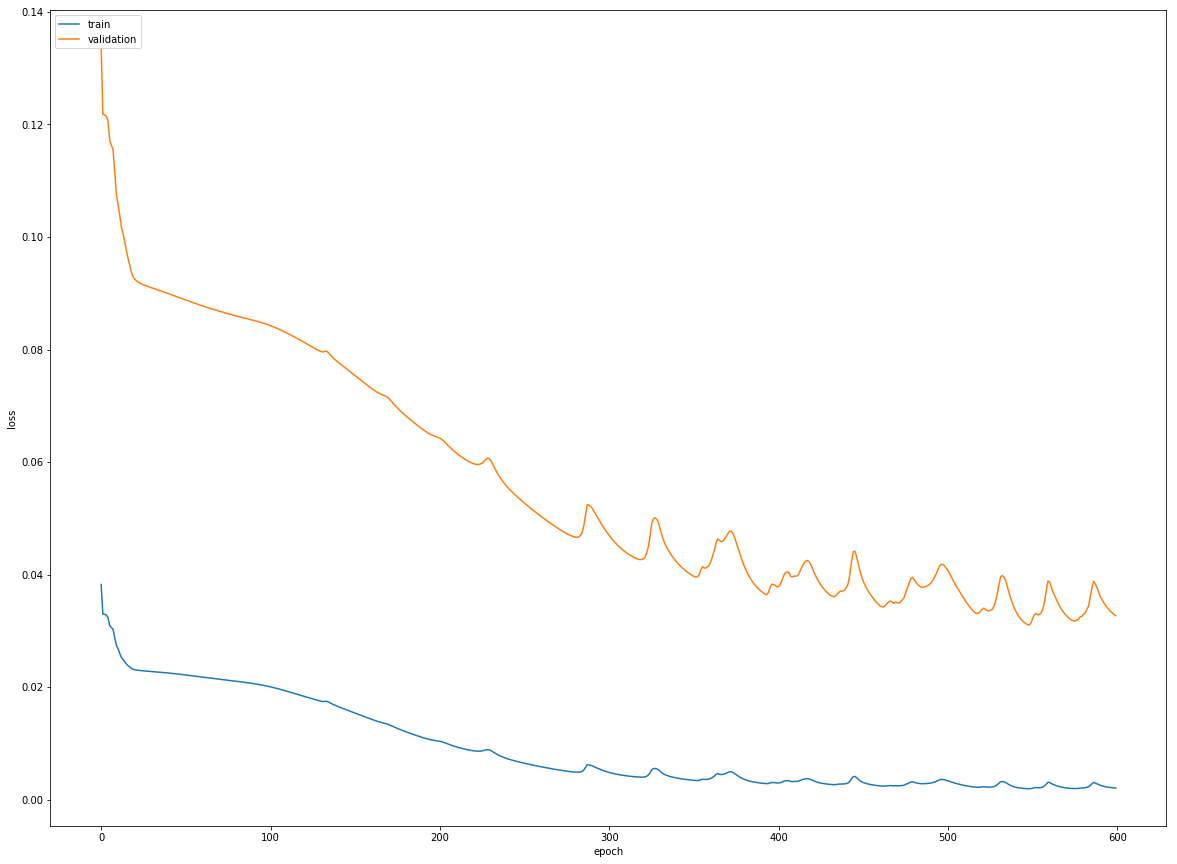

Wall time: 33min 25s


In [21]:
%%time
y_labels2 = []
for label in y_df.columns:
    if 'var1' in label:
        y_labels2.append(label)
y_df2 = y_df[y_labels2]
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df2, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = NeuralNet(X=X_train,
                  y=y_train,
                  lag=lag,
                  loss_func='mean_squared_error',
                  activation=activation,
                  optimizer='adam',
                  layers=layer,
                  dropout=dropout,
                  y_labels=y_label,
                  initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

## Neural Net (Feed Foward) Validation: Day 8 - 14 (CPU)

Evaluating model fit to day 1 forecasts. 

Day 1
Feature vectors: (904, 135)
Label vectors: (904, 13)
Label: 0
Accuracy: 0.713495575221239
F1Score: 0.03717472118959108
--------------------------
Label: 1
Accuracy: 0.7079646017699115
F1Score: 0.06382978723404255
--------------------------
Label: 2
Accuracy: 0.7035398230088495
F1Score: 0.0821917808219178
--------------------------
Label: 3
Accuracy: 0.6913716814159292
F1Score: 0.05423728813559322
--------------------------
Label: 4
Accuracy: 0.6957964601769911
F1Score: 0.13249211356466878
--------------------------
Label: 5
Accuracy: 0.6935840707964602
F1Score: 0.061016949152542375
--------------------------
Label: 6
Accuracy: 0.6836283185840708
F1Score: 0.15384615384615383
--------------------------
Label: 7
Accuracy: 0.6393805309734514
F1Score: 0.22009569377990434
--------------------------
Label: 8
Accuracy: 0.7831858407079646
F1Score: 0.5829787234042553
--------------------------
Label: 9
Accuracy: 0.8860619469026548
F1Score: 0.8189806678383129
--------------------------
Labe

Label: 0
Accuracy: 0.5785398230088495
F1Score: 0.3110307414104882
--------------------------
Label: 1
Accuracy: 0.6006637168141593
F1Score: 0.31238095238095237
--------------------------
Label: 2
Accuracy: 0.577433628318584
F1Score: 0.3274647887323943
--------------------------
Label: 3
Accuracy: 0.547566371681416
F1Score: 0.3102866779089376
--------------------------
Label: 4
Accuracy: 0.5641592920353983
F1Score: 0.40483383685800606
--------------------------
Label: 5
Accuracy: 0.5497787610619469
F1Score: 0.3089983022071307
--------------------------
Label: 6
Accuracy: 0.5221238938053098
F1Score: 0.31645569620253167
--------------------------
Label: 7
Accuracy: 0.5254424778761062
F1Score: 0.3663220088626293
--------------------------
Label: 8
Accuracy: 0.8174778761061947
F1Score: 0.708994708994709
--------------------------
Label: 9
Accuracy: 0.8838495575221239
F1Score: 0.7671840354767183
--------------------------
Label: 10
Accuracy: 0.8241150442477876
F1Score: 0.7185840707964603
---

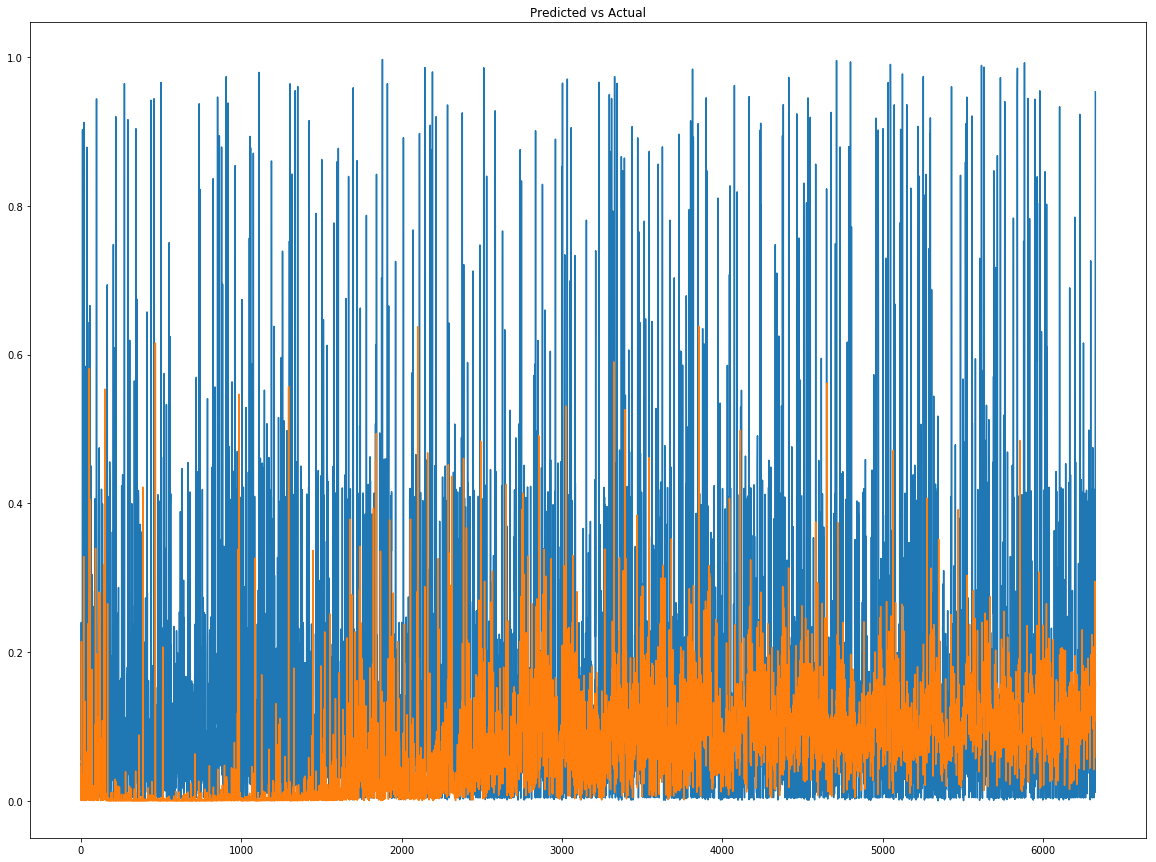

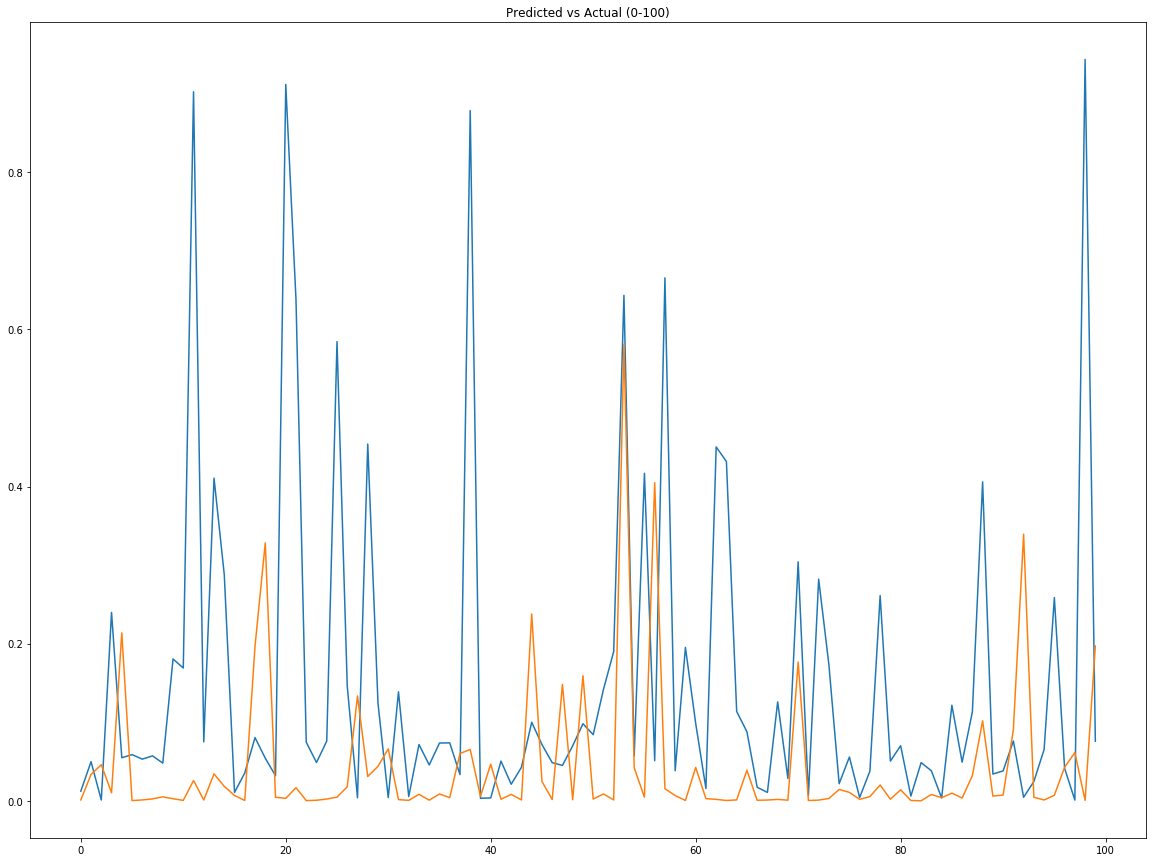

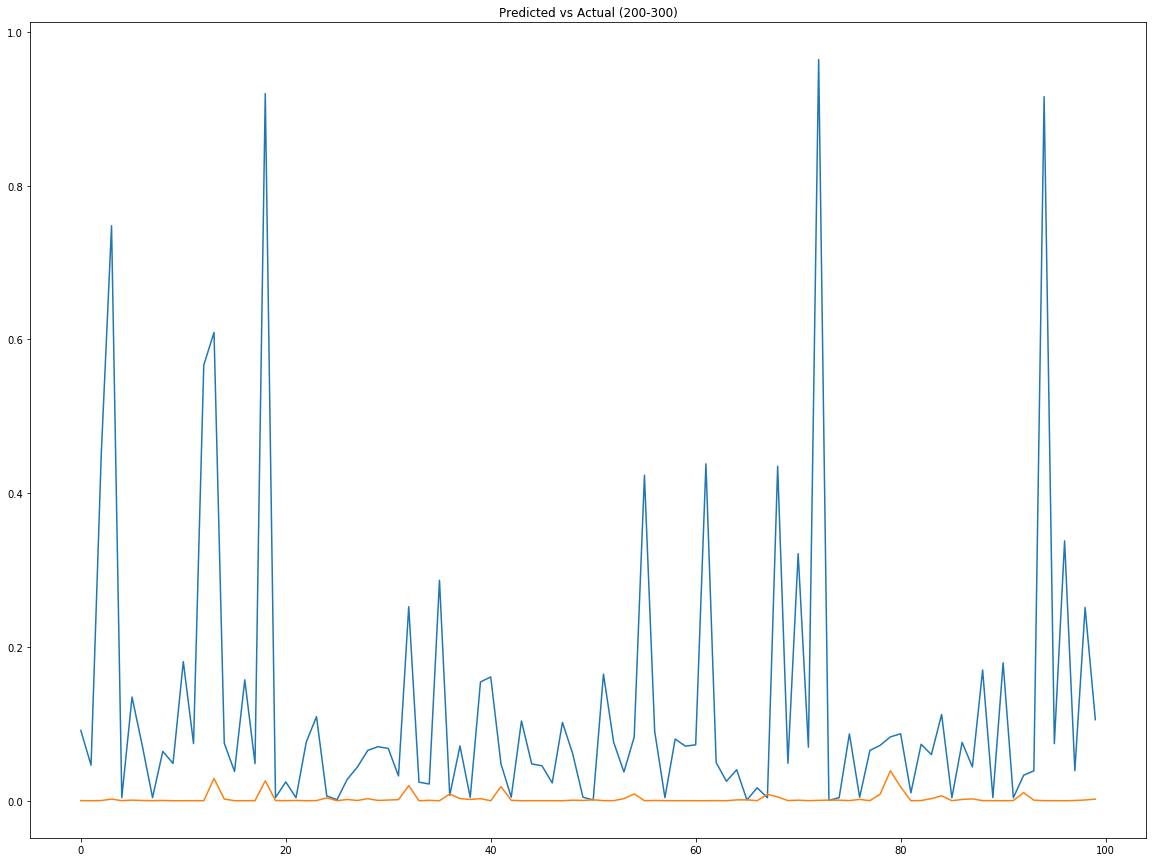

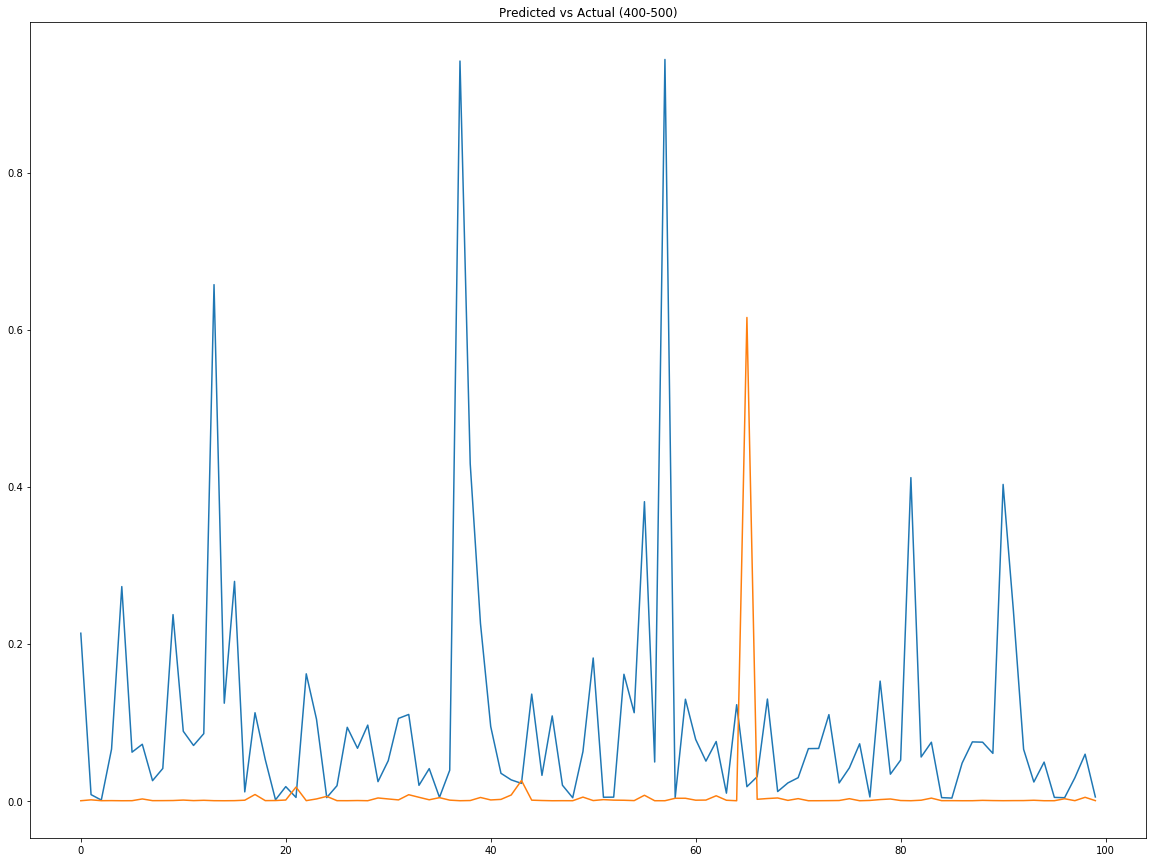

Wall time: 2min 56s


In [22]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
#NEW
y_actual, y_predicted = [],[]
#NEW
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = X_validate_temp[j,:]
        X = X.reshape(1,-1)
        #X = X.reshape((int(X.shape[0] / lag), lag, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        #NEW
        y_actual.append(y[0])
        y_predicted.append(yhat[0])
        #NEW
        
        for z in range(yhat.shape[0]):
            y[z] = BinClass.discretize_value(y[z], cpu_avg)
            yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(len(y_labels2)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)
    
#NEW
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual, label='y_actual')
plt.plot(y_predicted, label='y_predicted')
plt.title('Predicted vs Actual')
plt.show()

plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[0:100], label='y_actual')
plt.plot(y_predicted[0:100], label='y_predicted')
plt.title('Predicted vs Actual (0-100)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[200:300], label='y_actual')
plt.plot(y_predicted[200:300], label='y_predicted')
plt.title('Predicted vs Actual (200-300)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[400:500], label='y_actual')
plt.plot(y_predicted[400:500], label='y_predicted')
plt.title('Predicted vs Actual (400-500)')
plt.show()
#NEW

## Scoring per day (CPU)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

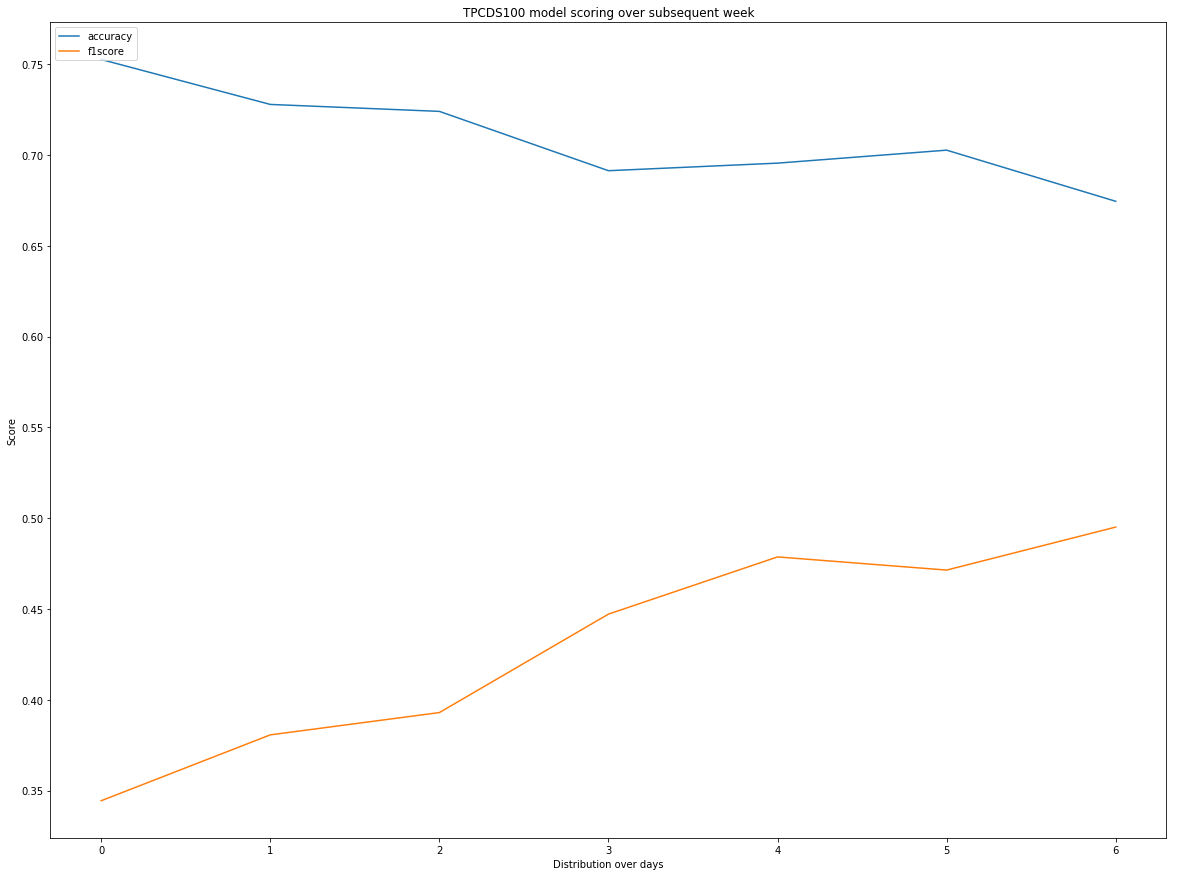

In [23]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

## Neural Net (Feed Foward) Training (Week Prior: Day 1 - 7) (IO)

A neural net model is trained on a week worth of data. Once the model is fit, it will then be used to establish predictions for upcoming days.

* https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
* https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
* https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
* https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks


Reshaping Training Frames
X_train shape [(6333, 135)] Type - <class 'numpy.ndarray'>
X_validate shape [(6333, 135)] Type - <class 'numpy.ndarray'>
y_train shape [(6333, 13)] Type - <class 'numpy.ndarray'>
y_validate shape [(6333, 13)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 135)               18360     
_________________________________________________________________
dropout_4 (Dropout)          (None, 135)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 135)               18360     
_________________________________________________________________
dropout_5 (Dropout)          (None, 135)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 135)               18360     
_______

 - 3s - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0850 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0854
Epoch 39/600
 - 3s - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0849 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0854
Epoch 40/600
 - 3s - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0849 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0854
Epoch 41/600
 - 3s - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0849 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0855
Epoch 42/600
 - 3s - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0849 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0855
Epoch 43/600
 - 3s - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0849 - val_loss: 0.0120 - val_

Epoch 84/600
 - 3s - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0829 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0863
Epoch 85/600
 - 3s - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0828 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0863
Epoch 86/600
 - 3s - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0827 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0863
Epoch 87/600
 - 3s - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0826 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0864
Epoch 88/600
 - 3s - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0824 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0864
Epoch 89/600
 - 3s - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0823 - val_loss: 

Epoch 130/600
 - 3s - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0734 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0885
Epoch 131/600
 - 3s - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0731 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0885
Epoch 132/600
 - 3s - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0728 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0886
Epoch 133/600
 - 3s - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0726 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0887
Epoch 134/600
 - 3s - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0723 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0888
Epoch 135/600
 - 3s - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0720 - val_

Epoch 176/600
 - 3s - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0609 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0928
Epoch 177/600
 - 3s - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0607 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0929
Epoch 178/600
 - 3s - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0604 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0930
Epoch 179/600
 - 3s - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0602 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0932
Epoch 180/600
 - 3s - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0599 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0933
Epoch 181/600
 - 3s - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0597 - val_

Epoch 222/600
 - 4s - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0508 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0983
Epoch 223/600
 - 3s - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0506 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0984
Epoch 224/600
 - 3s - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0504 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.0986
Epoch 225/600
 - 3s - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0502 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0987
Epoch 226/600
 - 3s - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0500 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0988
Epoch 227/600
 - 3s - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0498 - val_

Epoch 268/600
 - 3s - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0431 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1038
Epoch 269/600
 - 3s - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0430 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1039
Epoch 270/600
 - 3s - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0429 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1040
Epoch 271/600
 - 3s - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0427 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1041
Epoch 272/600
 - 3s - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0426 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1043
Epoch 273/600
 - 3s - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0425 - val_

Epoch 314/600
 - 3s - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0401 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1082
Epoch 315/600
 - 3s - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0398 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1083
Epoch 316/600
 - 3s - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0396 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1083
Epoch 317/600
 - 3s - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0393 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1084
Epoch 318/600
 - 3s - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0391 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1085
Epoch 319/600
 - 3s - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0388 - val_

Epoch 360/600
 - 3s - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0338 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1127
Epoch 361/600
 - 4s - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0337 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1128
Epoch 362/600
 - 4s - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0336 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1129
Epoch 363/600
 - 3s - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0336 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1129
Epoch 364/600
 - 3s - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0335 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1130
Epoch 365/600
 - 3s - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0334 - val_

Epoch 406/600
 - 3s - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0358 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1132
Epoch 407/600
 - 3s - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0353 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1132
Epoch 408/600
 - 3s - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0349 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1133
Epoch 409/600
 - 4s - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0345 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1134
Epoch 410/600
 - 3s - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0341 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1135
Epoch 411/600
 - 3s - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0337 - val_

Epoch 452/600
 - 3s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0285 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1175
Epoch 453/600
 - 3s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0285 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1175
Epoch 454/600
 - 3s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0284 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1177
Epoch 455/600
 - 3s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0284 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1177
Epoch 456/600
 - 3s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0283 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1178
Epoch 457/600
 - 3s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0283 - val_

Epoch 498/600
 - 3s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0290 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1175
Epoch 499/600
 - 3s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0287 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1176
Epoch 500/600
 - 3s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0285 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1177
Epoch 501/600
 - 3s - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0282 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1178
Epoch 502/600
 - 4s - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0280 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1180
Epoch 503/600
 - 4s - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0278 - val_

Epoch 544/600
 - 3s - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0266 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1217
Epoch 545/600
 - 3s - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0275 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1219
Epoch 546/600
 - 3s - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0294 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1219
Epoch 547/600
 - 3s - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0319 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1210
Epoch 548/600
 - 3s - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0326 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1206
Epoch 549/600
 - 3s - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0313 - val_

Epoch 590/600
 - 3s - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0255 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1208
Epoch 591/600
 - 3s - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0253 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1209
Epoch 592/600
 - 3s - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0252 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1209
Epoch 593/600
 - 3s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0250 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1210
Epoch 594/600
 - 3s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0249 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1211
Epoch 595/600
 - 3s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0247 - val_

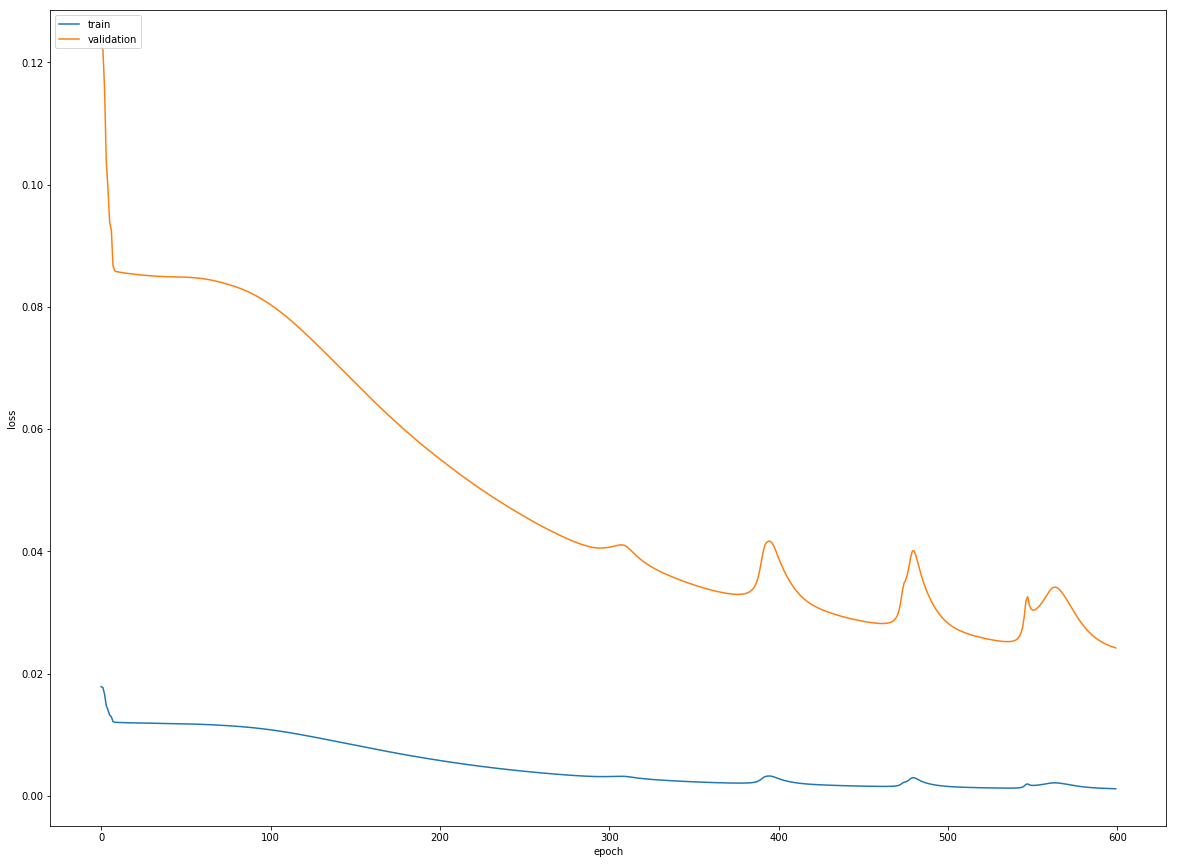

Wall time: 34min


In [24]:
%%time
y_labels2 = []
for label in y_df.columns:
    if 'var2' in label:
        y_labels2.append(label)
y_df2 = y_df[y_labels2]
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df2, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = NeuralNet(X=X_train,
                  y=y_train,
                  lag=lag,
                  loss_func='mean_squared_error',
                  activation=activation,
                  optimizer='adam',
                  layers=layer,
                  dropout=dropout,
                  y_labels=y_label,
                  initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

## Neural Net (Feed Foward) Validation: Day 8 - 14 (IO)

Evaluating model fit to day 1 forecasts. 

Day 1
Feature vectors: (904, 135)
Label vectors: (904, 13)
Label: 0
Accuracy: 0.4778761061946903
F1Score: 0.44470588235294123
--------------------------
Label: 1
Accuracy: 0.5287610619469026
F1Score: 0.5782178217821781
--------------------------
Label: 2
Accuracy: 0.5077433628318584
F1Score: 0.535005224660397
--------------------------
Label: 3
Accuracy: 0.49668141592920356
F1Score: 0.4347826086956522
--------------------------
Label: 4
Accuracy: 0.48672566371681414
F1Score: 0.45153664302600477
--------------------------
Label: 5
Accuracy: 0.5165929203539823
F1Score: 0.5005714285714287
--------------------------
Label: 6
Accuracy: 0.5154867256637168
F1Score: 0.5369978858350951
--------------------------
Label: 7
Accuracy: 0.4745575221238938
F1Score: 0.45339470655926356
--------------------------
Label: 8
Accuracy: 0.870575221238938
F1Score: 0.8647398843930636
--------------------------
Label: 9
Accuracy: 0.911504424778761
F1Score: 0.9095022624434388
--------------------------
Label: 10

Label: 0
Accuracy: 0.5210176991150443
F1Score: 0.5856459330143541
--------------------------
Label: 1
Accuracy: 0.497787610619469
F1Score: 0.4887387387387388
--------------------------
Label: 2
Accuracy: 0.49557522123893805
F1Score: 0.3952254641909815
--------------------------
Label: 3
Accuracy: 0.5022123893805309
F1Score: 0.492099322799097
--------------------------
Label: 4
Accuracy: 0.49557522123893805
F1Score: 0.4227848101265823
--------------------------
Label: 5
Accuracy: 0.48451327433628316
F1Score: 0.52834008097166
--------------------------
Label: 6
Accuracy: 0.5055309734513275
F1Score: 0.5818521983161833
--------------------------
Label: 7
Accuracy: 0.5099557522123894
F1Score: 0.5832549388523047
--------------------------
Label: 8
Accuracy: 0.9557522123893806
F1Score: 0.9578059071729957
--------------------------
Label: 9
Accuracy: 0.952433628318584
F1Score: 0.9532100108813927
--------------------------
Label: 10
Accuracy: 0.9546460176991151
F1Score: 0.954895489548955
------

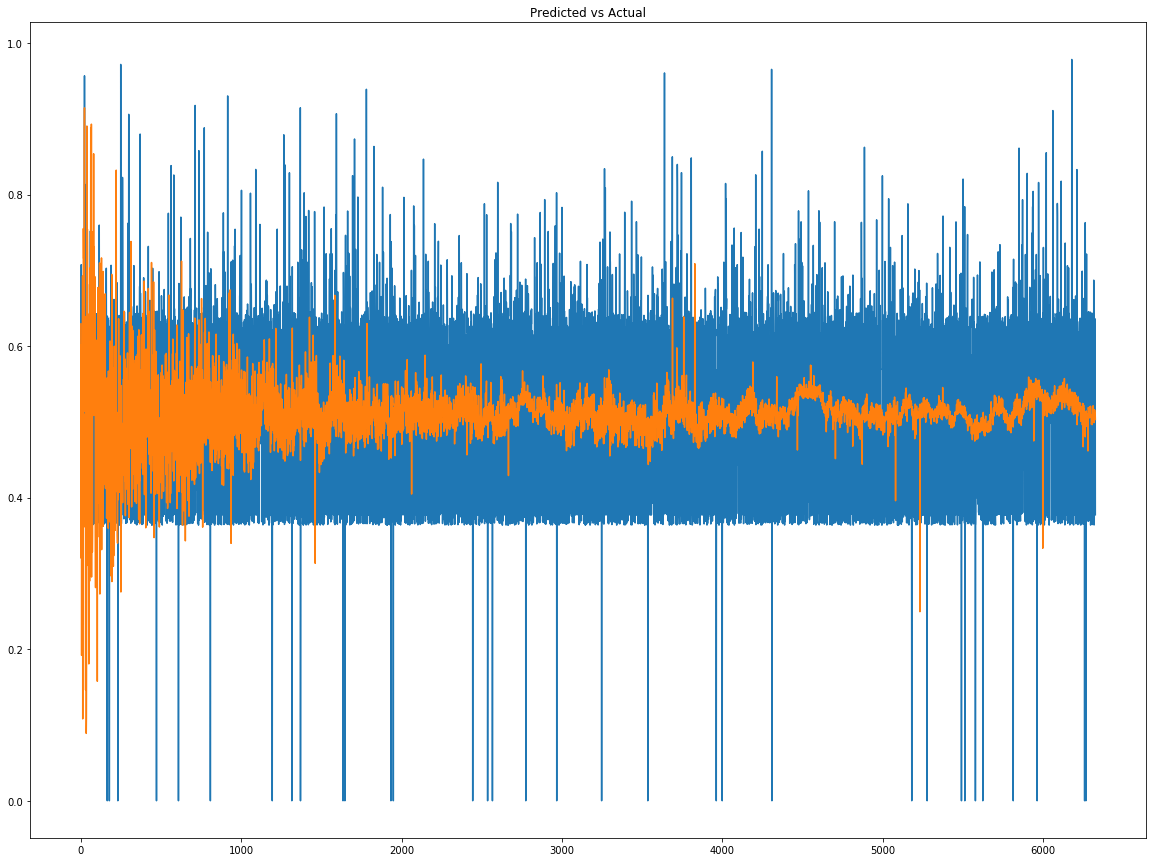

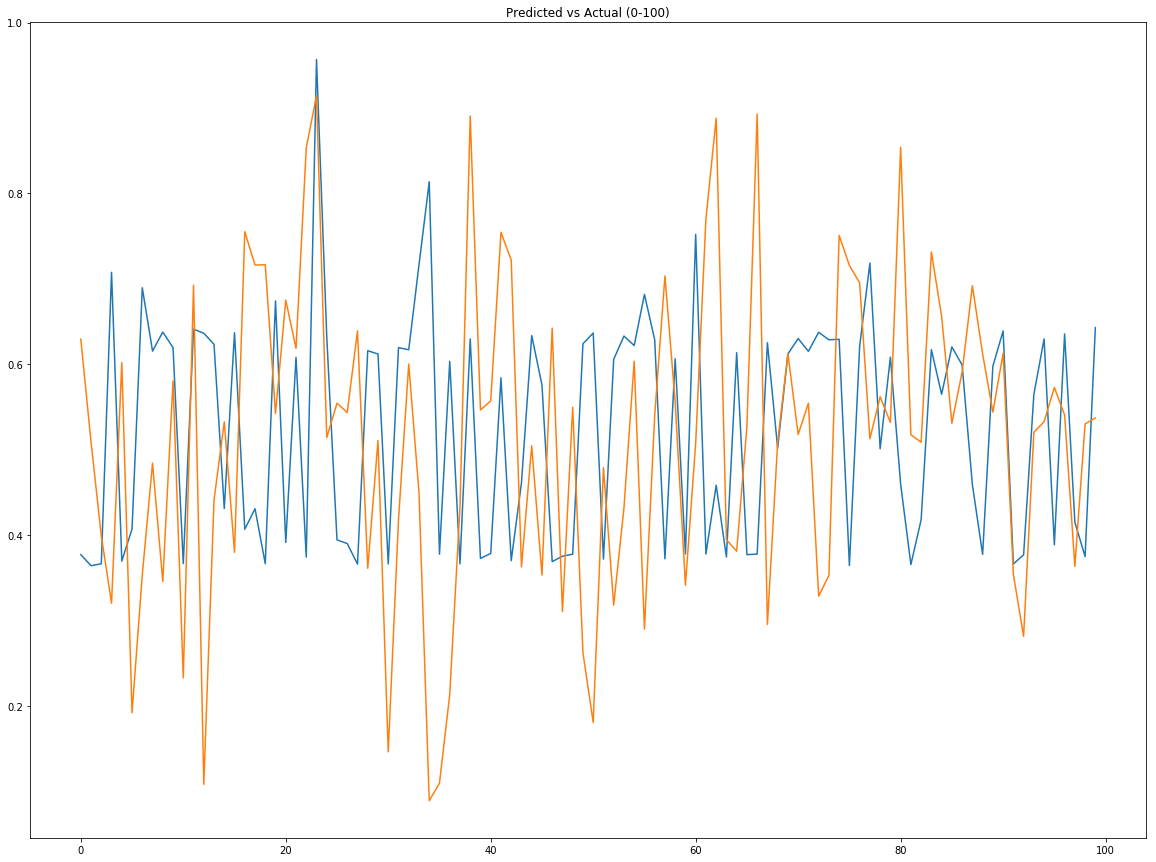

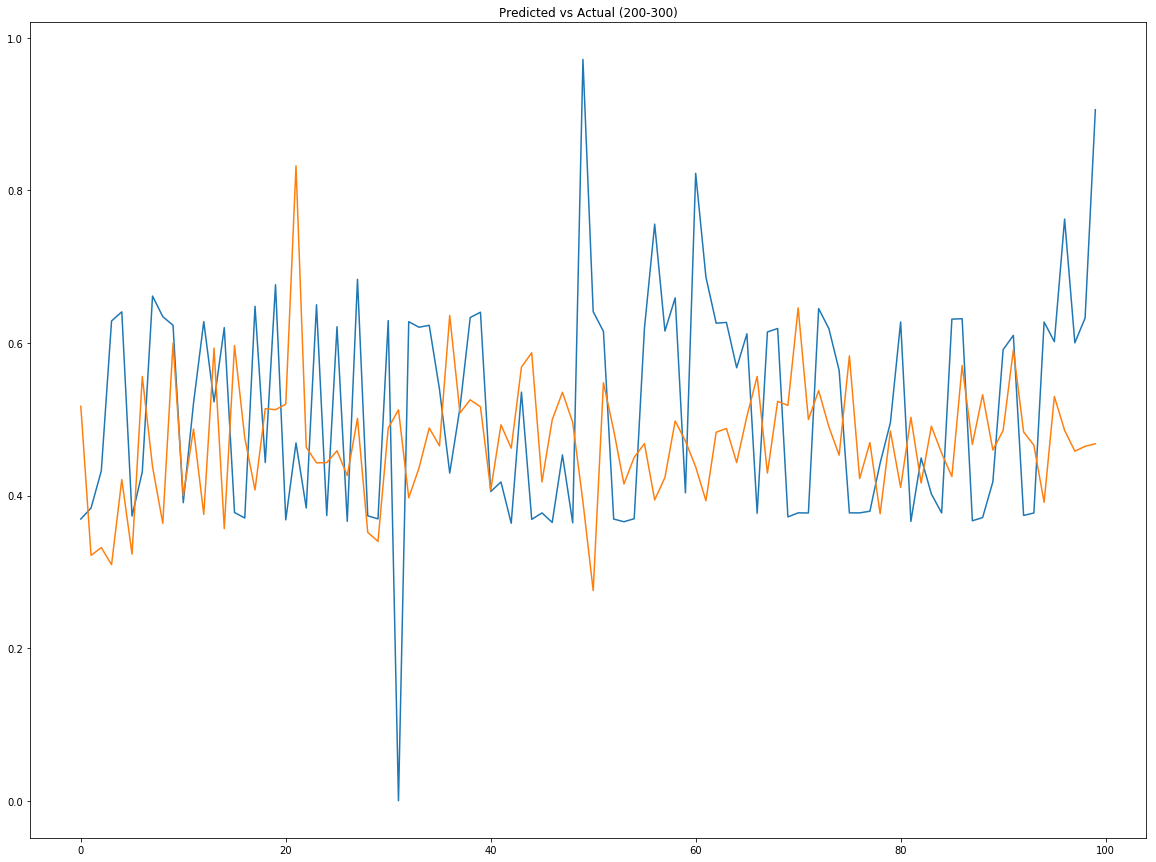

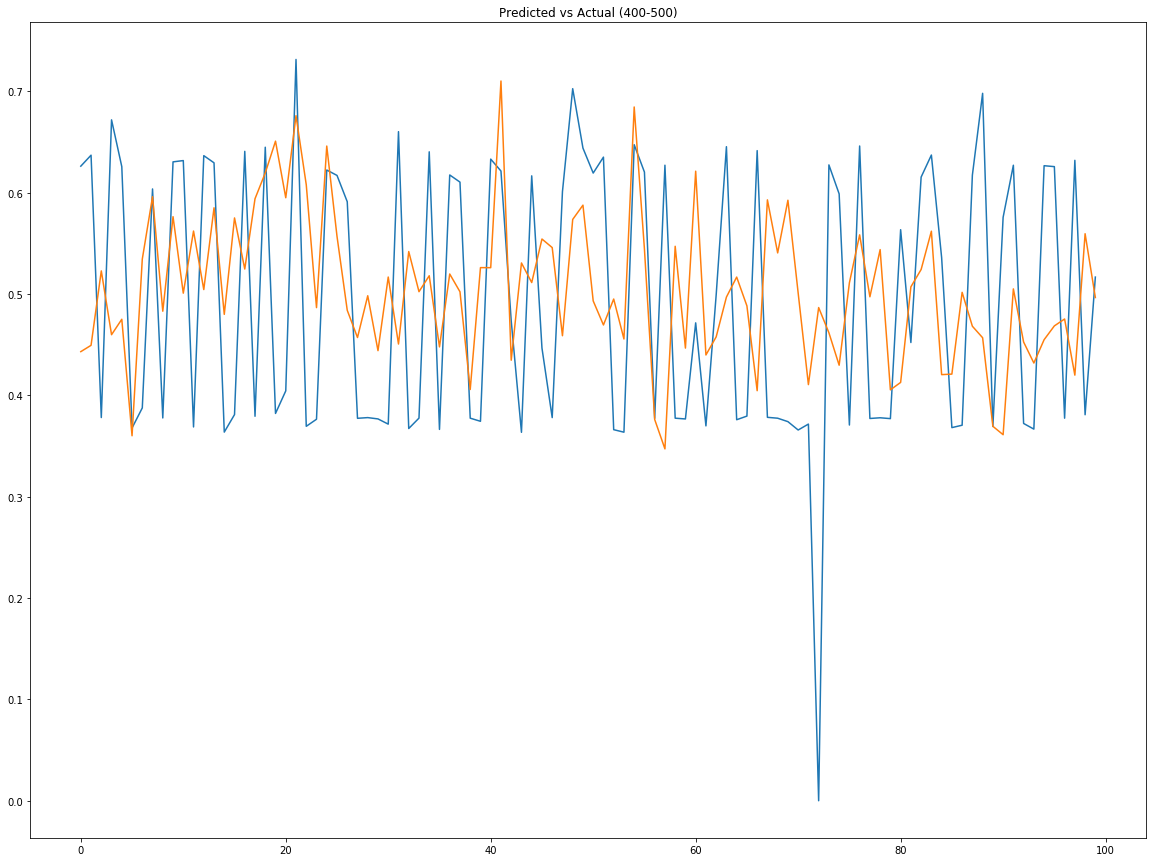

Wall time: 2min 55s


In [25]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
#NEW
y_actual, y_predicted = [],[]
#NEW
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = X_validate_temp[j,:]
        X = X.reshape(1,-1)
        #X = X.reshape((int(X.shape[0] / lag), lag, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        #NEW
        y_actual.append(y[0])
        y_predicted.append(yhat[0])
        #NEW
        
        for z in range(yhat.shape[0]):
            y[z] = BinClass.discretize_value(y[z], io_avg)
            yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(len(y_labels2)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)
    
#NEW
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual, label='y_actual')
plt.plot(y_predicted, label='y_predicted')
plt.title('Predicted vs Actual')
plt.show()

plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[0:100], label='y_actual')
plt.plot(y_predicted[0:100], label='y_predicted')
plt.title('Predicted vs Actual (0-100)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[200:300], label='y_actual')
plt.plot(y_predicted[200:300], label='y_predicted')
plt.title('Predicted vs Actual (200-300)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[400:500], label='y_actual')
plt.plot(y_predicted[400:500], label='y_predicted')
plt.title('Predicted vs Actual (400-500)')
plt.show()
#NEW

## Scoring per day (IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

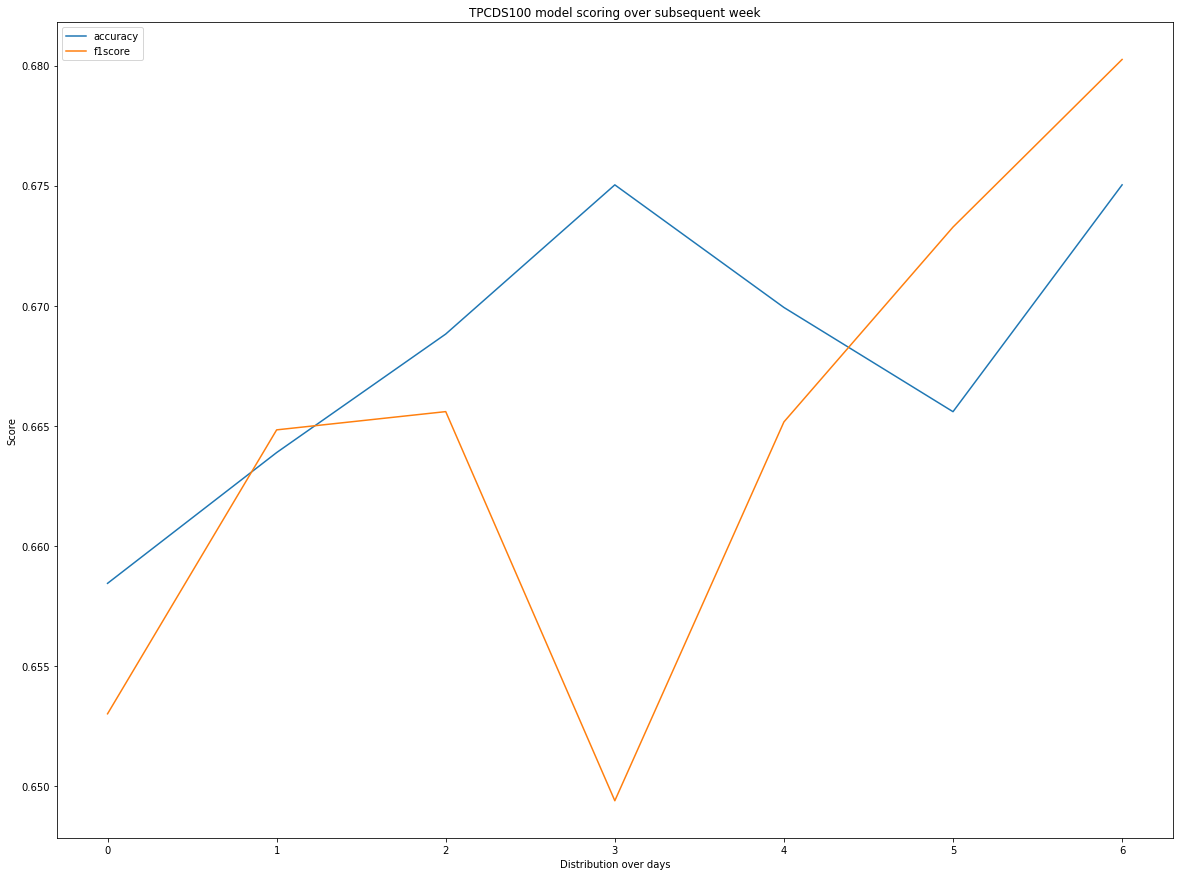

In [26]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

## Neural Net (Feed Foward) Training (Week Prior: Day 1 - 7) (CPU + IO)

A neural net model is trained on a week worth of data. Once the model is fit, it will then be used to establish predictions for upcoming days.

* https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
* https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
* https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
* https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks


Reshaping Training Frames
X_train shape [(6333, 135)] Type - <class 'numpy.ndarray'>
X_validate shape [(6333, 135)] Type - <class 'numpy.ndarray'>
y_train shape [(6333, 26)] Type - <class 'numpy.ndarray'>
y_validate shape [(6333, 26)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 135)               18360     
_________________________________________________________________
dropout_7 (Dropout)          (None, 135)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 135)               18360     
_________________________________________________________________
dropout_8 (Dropout)          (None, 135)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 135)               18360     
_______

 - 3s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0882 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0889
Epoch 39/600
 - 3s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0881 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0888
Epoch 40/600
 - 3s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0880 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0888
Epoch 41/600
 - 3s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0879 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0888
Epoch 42/600
 - 3s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0879 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0888
Epoch 43/600
 - 3s - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.0878 - val_loss: 0.0177 - val_

Epoch 84/600
 - 3s - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0852 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0896
Epoch 85/600
 - 3s - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0851 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0896
Epoch 86/600
 - 3s - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0850 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0896
Epoch 87/600
 - 3s - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0849 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0897
Epoch 88/600
 - 3s - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0849 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0897
Epoch 89/600
 - 3s - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0848 - val_loss: 

Epoch 130/600
 - 3s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0815 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0919
Epoch 131/600
 - 3s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0814 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.0920
Epoch 132/600
 - 3s - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0813 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.0921
Epoch 133/600
 - 3s - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0811 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.0922
Epoch 134/600
 - 3s - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0810 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.0923
Epoch 135/600
 - 3s - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0809 - val_

Epoch 176/600
 - 3s - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0746 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.0960
Epoch 177/600
 - 3s - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0744 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.0961
Epoch 178/600
 - 3s - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0743 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.0962
Epoch 179/600
 - 3s - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0741 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.0963
Epoch 180/600
 - 3s - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0739 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.0964
Epoch 181/600
 - 3s - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0737 - val_

Epoch 222/600
 - 3s - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0673 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.0986
Epoch 223/600
 - 3s - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0671 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.0987
Epoch 224/600
 - 3s - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0670 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.0988
Epoch 225/600
 - 3s - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0668 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.0989
Epoch 226/600
 - 3s - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0666 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.0990
Epoch 227/600
 - 3s - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0665 - val_

Epoch 268/600
 - 3s - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0615 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1043
Epoch 269/600
 - 3s - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0614 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1044
Epoch 270/600
 - 3s - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0613 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1046
Epoch 271/600
 - 3s - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0612 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1047
Epoch 272/600
 - 3s - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0611 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1048
Epoch 273/600
 - 3s - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0610 - val_

Epoch 314/600
 - 3s - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0580 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1057
Epoch 315/600
 - 3s - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0579 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1061
Epoch 316/600
 - 3s - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0579 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1064
Epoch 317/600
 - 3s - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0578 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1067
Epoch 318/600
 - 3s - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0578 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1069
Epoch 319/600
 - 3s - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0577 - val_

Epoch 360/600
 - 3s - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0537 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1090
Epoch 361/600
 - 3s - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0536 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1091
Epoch 362/600
 - 3s - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0535 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1092
Epoch 363/600
 - 3s - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0534 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1094
Epoch 364/600
 - 3s - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0533 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1095
Epoch 365/600
 - 3s - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0532 - val_

Epoch 406/600
 - 3s - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0521 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1128
Epoch 407/600
 - 3s - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0519 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1128
Epoch 408/600
 - 2s - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0518 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1128
Epoch 409/600
 - 3s - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0517 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1128
Epoch 410/600
 - 2s - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0516 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1128
Epoch 411/600
 - 2s - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0514 - val_

Epoch 452/600
 - 2s - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0516 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1114
Epoch 453/600
 - 2s - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0516 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1113
Epoch 454/600
 - 3s - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0515 - val_loss: 0.0330 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1112
Epoch 455/600
 - 2s - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0514 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1111
Epoch 456/600
 - 2s - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0513 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1110
Epoch 457/600
 - 2s - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0512 - val_

Epoch 498/600
 - 2s - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0486 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1173
Epoch 499/600
 - 2s - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0484 - val_loss: 0.0368 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1175
Epoch 500/600
 - 2s - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0483 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1177
Epoch 501/600
 - 2s - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0482 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1179
Epoch 502/600
 - 2s - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0481 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1179
Epoch 503/600
 - 3s - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0480 - val_

Epoch 544/600
 - 2s - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0459 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1138
Epoch 545/600
 - 2s - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0459 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1137
Epoch 546/600
 - 2s - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0459 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1137
Epoch 547/600
 - 2s - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0460 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1137
Epoch 548/600
 - 2s - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0461 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1140
Epoch 549/600
 - 2s - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0463 - val_

Epoch 590/600
 - 2s - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0441 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1201
Epoch 591/600
 - 2s - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0443 - val_loss: 0.0383 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1203
Epoch 592/600
 - 2s - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0446 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1206
Epoch 593/600
 - 2s - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0452 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1209
Epoch 594/600
 - 2s - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0463 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1211
Epoch 595/600
 - 2s - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0475 - val_

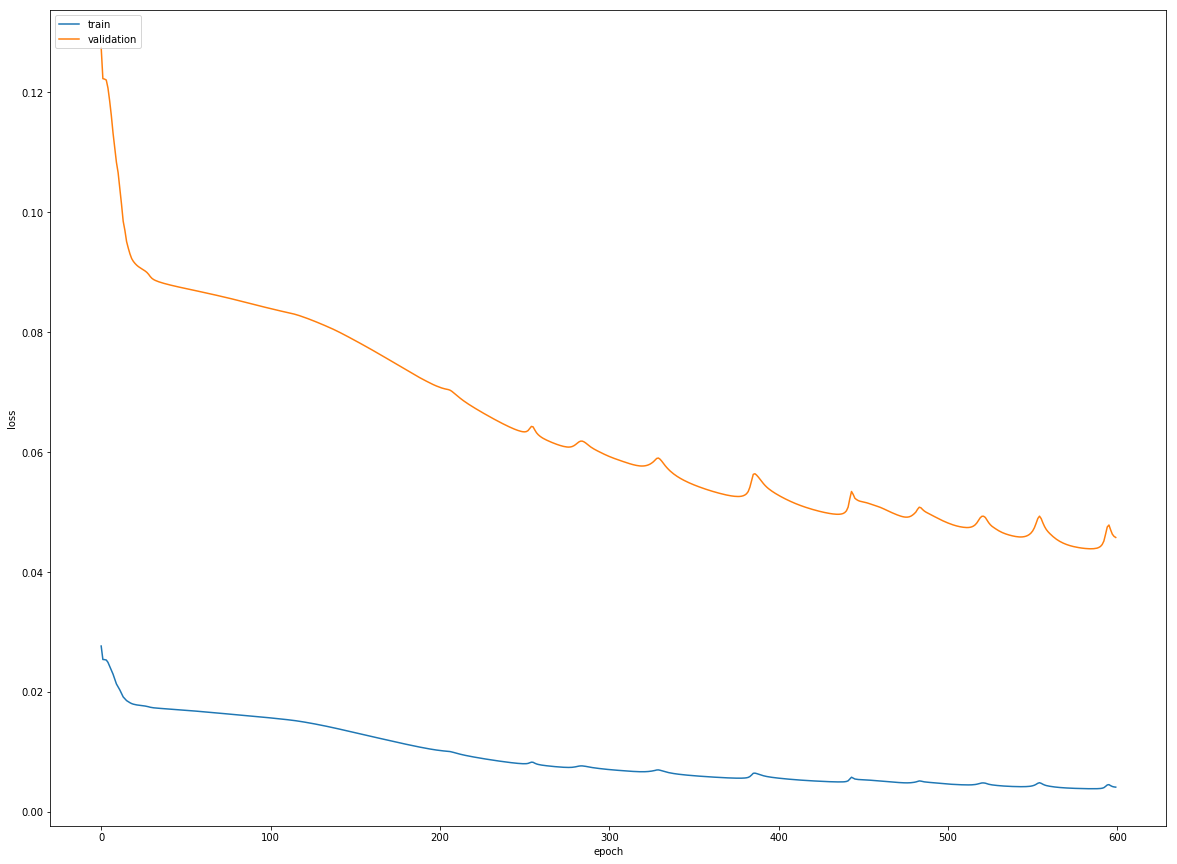

Wall time: 29min 32s


In [27]:
%%time

X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = NeuralNet(X=X_train,
                  y=y_train,
                  lag=lag,
                  loss_func='mean_squared_error',
                  activation=activation,
                  optimizer='adam',
                  layers=layer,
                  dropout=dropout,
                  y_labels=y_label,
                  initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

## Neural Net (Feed Foward) Validation: Day 8 - 14 (CPU + IO)

Evaluating model fit to day 1 forecasts. 

In [28]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = X_validate_temp[j,:]
        X = X.reshape(1,-1)
        #X = X.reshape((int(X.shape[0] / lag), lag, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
            if z % 2 == 0:
                #print('CPU')
                y[z] = BinClass.discretize_value(y[z], cpu_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
            else:
                #print('IO')
                y[z] = BinClass.discretize_value(y[z], io_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(lag * len(y_label)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (904, 135)
Label vectors: (904, 26)
Label: 0
Accuracy: 0.7013274336283186
F1Score: 0.08163265306122448
--------------------------
Label: 1
Accuracy: 0.5176991150442478
F1Score: 0.5301724137931034
--------------------------
Label: 2
Accuracy: 0.6946902654867256
F1Score: 0.0547945205479452
--------------------------
Label: 3
Accuracy: 0.4745575221238938
F1Score: 0.48313384113166485
--------------------------
Label: 4
Accuracy: 0.6692477876106194
F1Score: 0.11275964391691394
--------------------------
Label: 5
Accuracy: 0.504424778761062
F1Score: 0.5203426124197001
--------------------------
Label: 6
Accuracy: 0.702433628318584
F1Score: 0.0627177700348432
--------------------------
Label: 7
Accuracy: 0.5199115044247787
F1Score: 0.5460251046025104
--------------------------
Label: 8
Accuracy: 0.7002212389380531
F1Score: 0.0750853242320819
--------------------------
Label: 9
Accuracy: 0.47676991150442477
F1Score: 0.5015806111696522
--------------------------
Label: 10

Label: 0
Accuracy: 0.5940265486725663
F1Score: 0.321626617375231
--------------------------
Label: 1
Accuracy: 0.5110619469026548
F1Score: 0.5044843049327354
--------------------------
Label: 2
Accuracy: 0.5719026548672567
F1Score: 0.3517587939698492
--------------------------
Label: 3
Accuracy: 0.5088495575221239
F1Score: 0.5066666666666667
--------------------------
Label: 4
Accuracy: 0.5508849557522124
F1Score: 0.3344262295081967
--------------------------
Label: 5
Accuracy: 0.49004424778761063
F1Score: 0.5232678386763185
--------------------------
Label: 6
Accuracy: 0.5331858407079646
F1Score: 0.28716216216216217
--------------------------
Label: 7
Accuracy: 0.5
F1Score: 0.5211864406779662
--------------------------
Label: 8
Accuracy: 0.5597345132743363
F1Score: 0.3090277777777778
--------------------------
Label: 9
Accuracy: 0.536504424778761
F1Score: 0.568486096807415
--------------------------
Label: 10
Accuracy: 0.5907079646017699
F1Score: 0.3071161048689139
-------------------

## Scoring per day (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

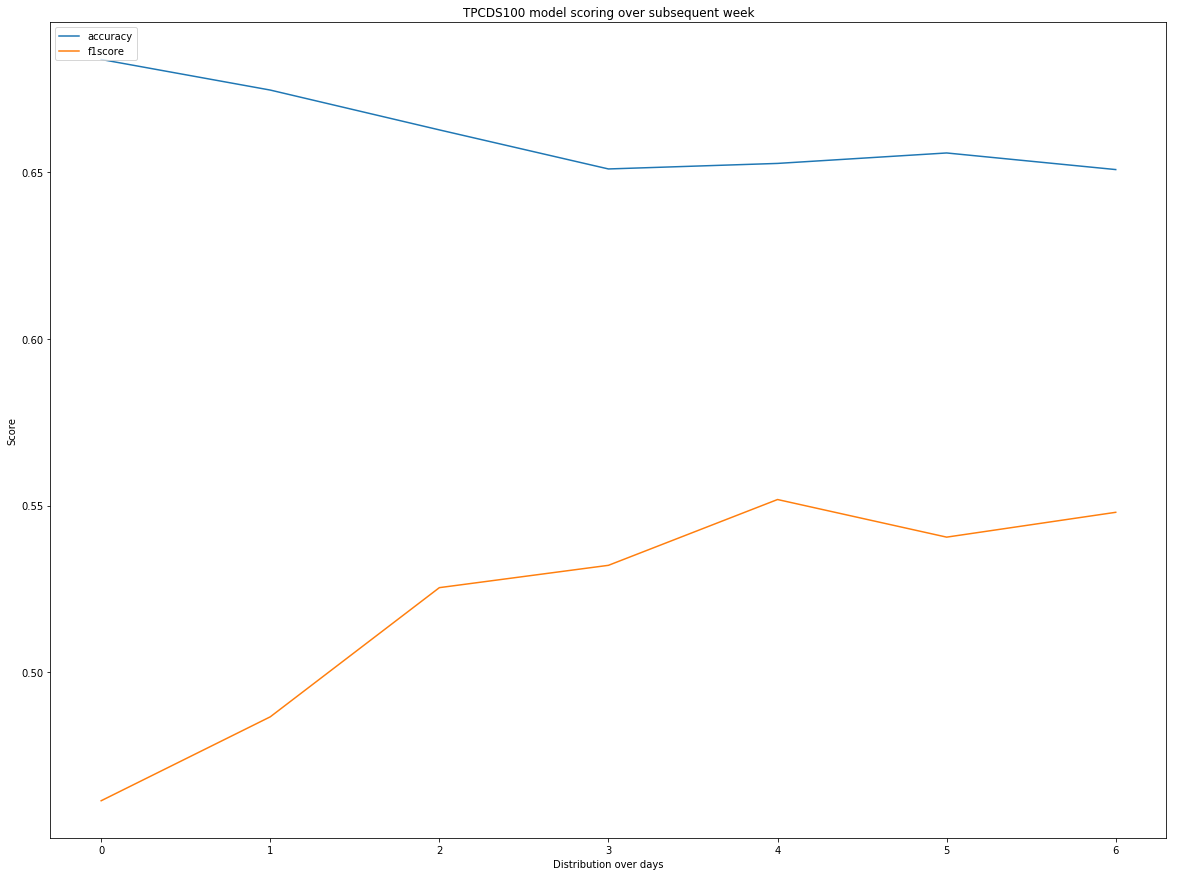

In [29]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()